# Import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.utils import to_categorical
# import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [3]:
! pip install xlsxwriter
import xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 4.1 MB/s 


# Utility functions

In [4]:
!pip install matplotx[all]
import matplotx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.9 MB/s 


In [5]:
def plotVsRatio(exps, results_df, ds_name, x='ood_ratio', y='acc', thrs=['0.0']):
  stability_df = list()
  
  plt.figure(figsize=(20,8))
  ax = plt.gca()
  ax.set_ylim([0, 110])
  
  # colors = ['#ef5350', '#880e4f', '#7b1fa2', '#7e75c2', '#18237e', '#90caf9', '#43a047', '#ffee58', \
  #           '#827717', '#ff6f00', '#8d6e63', '#607d8b', '#76ff03', '#e040fb', '#212121', '#18ffff']

  for idx, exp in enumerate(exps):
    if 'thr' in exp:
      for thr in thrs:
        condition = (results_df['exp']==exp) & (results_df['ds']==ds_name) & (results_df['thr']==thr)
        label = f'{exp} - {thr}'
        sub_results = results_df.loc[condition]
        sub_results.plot(x=x, y=y, ax=ax, label=label ) #, color=colors[idx])
    else:
      condition = (results_df['exp']==exp) & (results_df['ds']==ds_name)
      label = exp
      sub_results = results_df.loc[condition]
      sub_results.plot(x=x, y=y, ax=ax, label=label) #, color=colors[idx])

    mean = round(sub_results[y].mean(), 2)
    std = round(sub_results[y].std(), 2)
    stability_df.append([label, mean, std])

  matplotx.line_labels()
  
  stability_df= pd.DataFrame(stability_df, columns=['exp', 'mean', 'std'])

  display(stability_df)

In [6]:
def plotVsThr(exps, results_df, ds_name, x='thr', y='acc', ratios=['0']):
  stability_df = list()
  is_acc = 'acc' in y
  is_sens = 'sens' in y
  is_spec = 'spec' in y
  
  plt.figure(figsize=(20,8))
  ax = plt.gca()
  ax.set_ylim([0, 110])
  
  # colors = ['#ef5350', '#880e4f', '#7b1fa2', '#7e75c2', '#18237e', '#90caf9', '#43a047', '#ffee58', \
  #           '#827717', '#ff6f00', '#8d6e63', '#607d8b', '#76ff03', '#e040fb', '#212121', '#18ffff']

  for idx, exp in enumerate(exps):
    for ratio in ratios:
      if is_acc or (is_sens and ratio=='0') or (is_spec and ratio=='100'):
        condition = (results_df['exp']==exp) & (results_df['ds']==ds_name) & (results_df['ood_ratio']==ratio)
        label = f'{exp} - {ratio}'
        sub_results = results_df.loc[condition]
        sub_results.plot(x=x, y=y, ax=ax, label=label ) #, color=colors[idx])

        mean = round(sub_results[y].mean(), 2)
        std = round(sub_results[y].std(), 2)
        stability_df.append([label, mean, std])

  matplotx.line_labels()
  
  stability_df= pd.DataFrame(stability_df, columns=['exp', 'mean', 'std'])

  display(stability_df)

In [7]:
def printDiscData(exps, results_df, ds_name, x='ratio', y='acc', ratios=['0']):
  
  is_acc = 'acc' in y
  is_sens = 'sens' in y
  is_spec = 'spec' in y

  print(f"{ds_name} {y} results")
  disc_acc = list()
  for exp in exps:
    exp_acc = [exp]
    for ratio in ratios:
      if is_acc or (is_sens and ratio=='0') or (is_spec and ratio=='100'):
        condition = (results_df['exp']==exp) & (results_df['ds']==ds_name) & (results_df['ood_ratio']==ratio)
        # label = f'{exp} - {ratio}'
        sub_results = results_df.loc[condition]
        exp_acc.append(round(sub_results[y].mean(), 2))

    disc_acc.append(exp_acc)
    
  if is_acc:
    first_header = ['exp'] + [x for _ in range(len(ratios))]
    second_header = [''] + ratios
    columns=[first_header, second_header]
  else:
    columns=['exp', y]

  disc_acc = pd.DataFrame(disc_acc, columns=columns)
  display(disc_acc)

In [23]:
def thrMean(results_df):
  subdf_mean = results_df[['exp','thr','acc']].loc[(results_df['exp'].str.contains('thr'))].groupby('thr').mean()
  subdf_mean.rename(columns = {'acc':'mean'}, inplace = True)

  subdf_std = results_df[['exp','thr','acc']].loc[(results_df['exp'].str.contains('thr'))].groupby('thr').std()
  subdf_std.rename(columns = {'acc':'std'}, inplace = True)

  return subdf_mean, subdf_std

def plotSelection(subdf_mean_a, subdf_std_a, subdf_mean_b, subdf_std_b, lower=90, upper=99):
  subdf_a = pd.concat([subdf_mean_a, subdf_std_a], axis=1)
  subdf_b = pd.concat([subdf_mean_b, subdf_std_b], axis=1)

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), dpi=100)

  ax1.plot(subdf_a)
  ax1.plot([upper, upper], [0,100], linestyle='dashed', color='green')
  ax1.plot([lower, lower], [0,100], linestyle='dashed', color='green')
  ax1.set_ylim([0, 110])
  ax1.set_xlabel('\u03B2 value', size=15)
  ax1.set_ylabel('accuracy', size=15)
  ax1.set_title('(a)', y=-0.25, size=15)
  ax1.set_xticks(range(0, 110, 10))
  ax1.set_yticks(range(0, 110, 10))
  ax1.legend(["average", "standard deviation"])

  ax2.plot(subdf_b)
  ax2.plot([upper, upper], [0,100], linestyle='dashed', color='green')
  ax2.plot([lower, lower], [0,100], linestyle='dashed', color='green')
  ax2.set_ylim([0, 110])
  ax2.set_xlabel('\u03B2 value', size=15)
  ax2.set_ylabel('accuracy', size=15)
  ax2.set_title('(b)', y=-0.25, size=15)
  ax2.set_xticks(range(0, 110, 10))
  ax2.set_yticks(range(0, 110, 10))
  ax2.legend(["average", "standard deviation"])

  # fig.legend(["average", "standard deviation"], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.05))

  plt.subplots_adjust(left=0.2,bottom=0.2, top = 0.9, right = 0.9)
  plt.tight_layout()
  plt.savefig('select_thr.png')
  plt.show()

In [9]:
# def plotThrVsAcc(exps, results_df, x='thr', y='mean'):
#   stability_df = list()
#   is_mean = 'mean' in y
#   is_std = 'std' in y
  
#   plt.figure(figsize=(20,8))
#   ax = plt.gca()
#   ax.set_ylim([0, 110])
  
#   # colors = ['#ef5350', '#880e4f', '#7b1fa2', '#7e75c2', '#18237e', '#90caf9', '#43a047', '#ffee58', \
#   #           '#827717', '#ff6f00', '#8d6e63', '#607d8b', '#76ff03', '#e040fb', '#212121', '#18ffff']

#   for idx, exp in enumerate(exps):
#     condition = (results_df['exp']==exp)
#     label = f'{exp}'
#     sub_results = results_df.loc[condition]
#     sub_results = sub_results[['acc']]
#     sub_results.plot(x=x, y=y, ax=ax, label=label ) #, color=colors[idx])

#     mean = round(sub_results[y].mean(), 2)
#     std = round(sub_results[y].std(), 2)
#     stability_df.append([label, mean, std])

#   matplotx.line_labels()
  
#   stability_df= pd.DataFrame(stability_df, columns=['exp', 'mean', 'std'])

#   display(stability_df)

# Algos plots & results

## load results

In [10]:
data_file = '/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/data/all_results_df_all_arabic.pkl'
all_results_arabic = pd.read_pickle(data_file)
all_results_arabic

exp     ds ood_ratio  thr     acc  acc_balanced  P_macro  \
0            thr  mnist         0  0.0   81.01         81.01    82.04   
1            thr  mnist         5  0.0   77.50         78.73    77.09   
2            thr  mnist        10  0.0   73.82         79.17    75.97   
3            thr  mnist        15  0.0   70.34         79.87    75.58   
4            thr  mnist        20  0.0   66.80         80.62    75.43   
...          ...    ...       ...  ...     ...           ...      ...   
39746  dpmDiscOr    rnd        85  NaN   89.91         34.42    94.88   
39747  dpmDiscOr    rnd        90  NaN   93.24         33.85    94.77   
39748  dpmDiscOr    rnd        95  NaN   96.64         33.29    92.60   
39749  dpmDiscOr    rnd       100  NaN  100.00        100.00   100.00   
39750  dpmDiscOr  clean         0  NaN   24.57         24.58    94.95   

       P_weighted  R_macro  R_weighted  ...  acc_bin  acc_balanced_bin  \
0           82.04    81.01       81.01  ...   100.00            100.00   
1           75.90    78.73       77.50  ...    95.04             50.00   
2           70.84    79.17       73.82  ...    90.02             50.00   
3           66.52    79.87       70.34  ...    85.01             50.00   
4           62.49    80.62       66.80  ...    80.00             50.00   
...           ...      ...         ...  ...      ...               ...   
39746       90.26    34.42       89.91  ...    89.94             66.13   
39747       93.24    33.85       93.24  ...    93.27             65.92   
39748       96.40    33.29       96.64  ...    96.65             65.50   
39749      100.00   100.00      100.00  ...   100.00            100.00   
39750       98.34    23.73       24.57  ...    24.79             24.79   

       P_macro_bin  P_weighted_bin  R_macro_bin  R_weighted_bin  F1_macro_bin  \
0           100.00          100.00       100.00          100.00        100.00   
1            47.52           90.33        50.00           95.04         48.73   
2            45.01           81.04        50.00           90.02         47.37   
3            42.51           72.27        50.00           85.01         45.95   
4            40.00           64.01        50.00           80.00         44.45   
...            ...             ...          ...             ...           ...   
39746        94.72           91.00        66.13           89.94         71.60   
39747        96.53           93.74        65.92           93.27         72.35   
39748        98.30           96.77        65.50           96.65         72.80   
39749       100.00          100.00       100.00          100.00        100.00   
39750        50.00          100.00        12.39           24.79         19.87   

       F1_weighted_bin  sensitivity  specifity  
0               100.00       100.00        NaN  
1                92.62       100.00        0.0  
2                85.29       100.00        0.0  
3                78.13       100.00        0.0  
4                71.12       100.00        0.0  
...                ...          ...        ...  
39746            87.65        32.25      100.0  
39747            91.65        31.85      100.0  
39748            95.80        30.99      100.0  
39749           100.00          NaN      100.0  
39750            39.73        24.79        NaN  

[39751 rows x 22 columns]

In [11]:
data_file = '/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/data/all_results_df_all.pkl'
all_results_num = pd.read_pickle(data_file)
all_results_num

exp     ds ood_ratio  thr     acc  acc_balanced  P_macro  \
0            thr  mnist         0  0.0   94.47         92.60    94.79   
1            thr  mnist         5  0.0   89.76         90.17    86.82   
2            thr  mnist        10  0.0   85.02         90.14    84.26   
3            thr  mnist        15  0.0   80.23         90.06    82.44   
4            thr  mnist        20  0.0   75.49         90.04    81.00   
...          ...    ...       ...  ...     ...           ...      ...   
39746  dpmDiscOr    rnd        85  NaN   93.26         54.00    94.01   
39747  dpmDiscOr    rnd        90  NaN   95.39         52.86    90.94   
39748  dpmDiscOr    rnd        95  NaN   97.80         54.21    91.61   
39749  dpmDiscOr    rnd       100  NaN  100.00        100.00   100.00   
39750  dpmDiscOr  clean         0  NaN   54.93         53.41    95.78   

       P_weighted  R_macro  R_weighted  ...  acc_bin  acc_balanced_bin  \
0           94.65    92.60       94.47  ...   100.00            100.00   
1           87.75    90.17       89.76  ...    95.04             50.00   
2           81.84    90.14       85.02  ...    90.02             50.00   
3           76.23    90.06       80.23  ...    85.01             50.00   
4           70.93    90.04       75.49  ...    80.00             50.00   
...           ...      ...         ...  ...      ...               ...   
39746       93.33    54.00       93.26  ...    93.33             77.53   
39747       95.16    52.86       95.39  ...    95.44             76.93   
39748       97.61    54.21       97.80  ...    97.81             77.38   
39749      100.00   100.00      100.00  ...   100.00            100.00   
39750       98.70    52.00       54.93  ...    55.26             55.26   

       P_macro_bin  P_weighted_bin  R_macro_bin  R_weighted_bin  F1_macro_bin  \
0           100.00          100.00       100.00          100.00        100.00   
1            47.52           90.33        50.00           95.04         48.73   
2            45.01           81.04        50.00           90.02         47.37   
3            42.51           72.27        50.00           85.01         45.95   
4            40.00           64.01        50.00           80.00         44.45   
...            ...             ...          ...             ...           ...   
39746        96.37           93.81        77.53           93.33         83.62   
39747        97.59           95.66        76.93           95.44         83.77   
39748        98.87           97.86        77.38           97.81         84.81   
39749       100.00          100.00       100.00          100.00        100.00   
39750        50.00          100.00        27.63           55.26         35.59   

       F1_weighted_bin  sensitivity  specifity  
0               100.00       100.00        NaN  
1                92.62       100.00        0.0  
2                85.29       100.00        0.0  
3                78.13       100.00        0.0  
4                71.12       100.00        0.0  
...                ...          ...        ...  
39746            92.49        55.06      100.0  
39747            94.82        53.85      100.0  
39748            97.50        54.75      100.0  
39749           100.00          NaN      100.0  
39750            71.18        55.26        NaN  

[39751 rows x 22 columns]

## Pick threshold

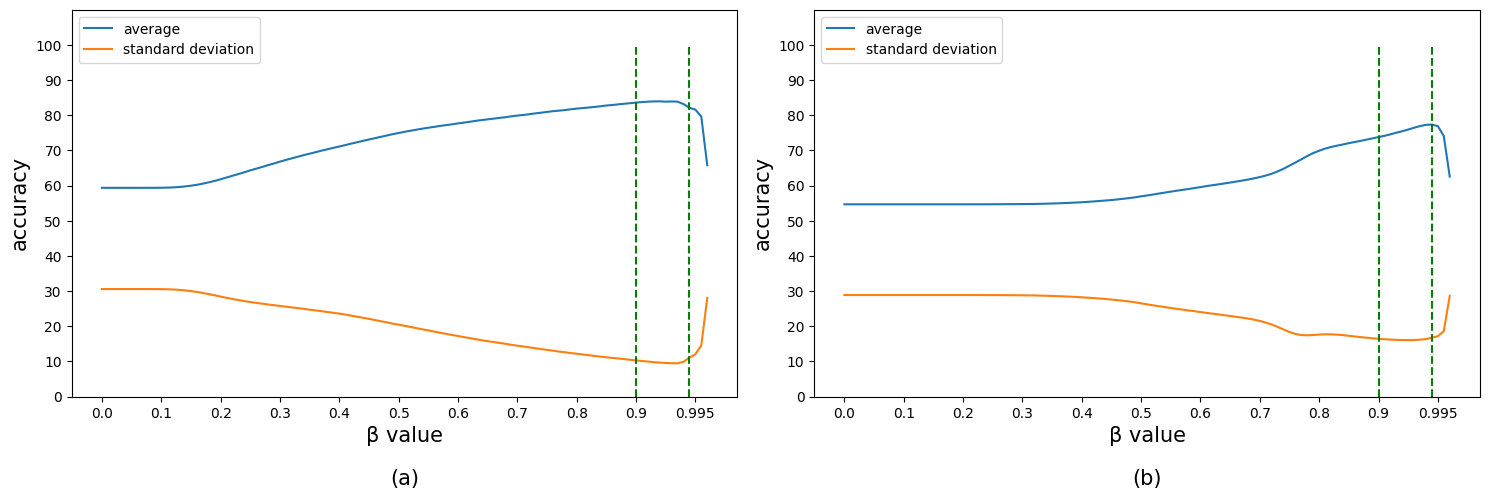

In [25]:
all_results_num_ = all_results_num.loc[(all_results_num['ood_ratio']!='0') | ((all_results_num['ood_ratio']=='0') & (all_results_num['ds']=="clean"))]
all_results_arabic_ = all_results_arabic.loc[(all_results_arabic['ood_ratio']!='0') | ((all_results_arabic['ood_ratio']=='0') & (all_results_arabic['ds']=="clean"))]

subdf_mean_a, subdf_std_a = thrMean(all_results_num_)
subdf_mean_b, subdf_std_b = thrMean(all_results_arabic_)

plotSelection(subdf_mean_a, subdf_std_a, subdf_mean_b, subdf_std_b, lower=90, upper=99)

## define variables

In [ ]:
algorithms = ['thr', 'disc', 'thrDiscAnd', 'thrDiscOr', 'dpm', 'dpmDiscAnd', 'dpmDiscOr']
datasets = ['mnist', 'bmnist', 'kmnist', 'fmnist', 'num', 'rnd']
ratios = [str(n) for n in range(0, 101, 5)]
thrs = [str(i/100) for i in range(100)]
thrs.extend(['0.995', '0.999', '1'])
scores_list = ['acc', 'acc_balanced', 'P_macro', 'P_weighted', 'R_macro', 'R_weighted', 'F1_macro', 'F1_weighted', \
               'acc_bin', 'acc_balanced_bin', 'P_macro_bin', 'P_weighted_bin', 'R_macro_bin', 'R_weighted_bin', 'F1_macro_bin', 'F1_weighted_bin', \
               'sensitivity', 'specifity']

## Tables

### Nums

In [ ]:
results_df = all_results_num.copy()
results_df = results_df.loc[(results_df['ood_ratio']!='0') | ((results_df['ood_ratio']=='0') & (results_df['ds']=="clean"))]

In [ ]:
results_df['thr'] = results_df['thr'].astype(float)
results_df['ood_ratio'] = results_df['ood_ratio'].astype(int)

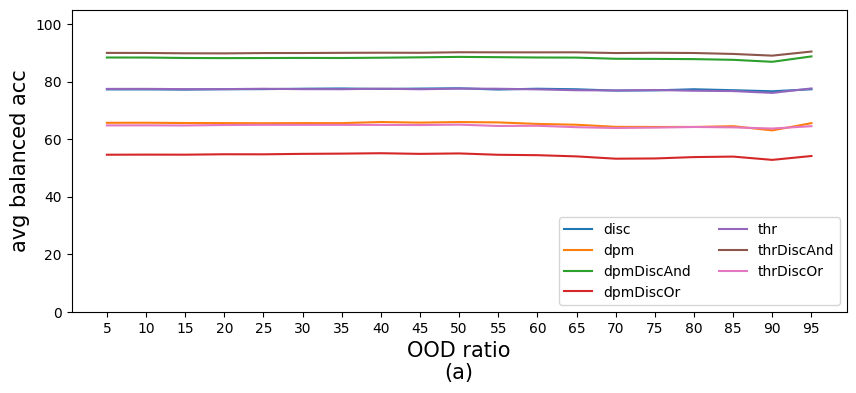

In [ ]:
ratio_low, ratio_high = 5, 95
thr_low, thr_high = 0.9, 0.99

all_plot = results_df.loc[ (results_df['ood_ratio']>=ratio_low) & (results_df['ood_ratio']<=ratio_high) \
                          & (((results_df['thr'] >= thr_low) & (results_df['thr'] <= thr_high)) | (results_df['thr'].isnull()))]

# all_plot_mean = all_plot.groupby(['exp', 'ood_ratio']).mean()
# all_plot_mean.reset_index(inplace=True)
# all_plot_mean.groupby('exp')['ood_ratio'].plot(x='ood_ratio', y='acc', legend=True)

all_plot_pivot = pd.pivot_table(all_plot, index=['exp', 'ood_ratio'], values=['acc_balanced'], aggfunc={'acc_balanced':np.mean}).unstack()

column_names = list()
for col in all_plot_pivot.columns:
  column_names.append(str(col[1]))

# all_plot_pivot.rename(columns=column_names, inplace=True)
all_plot_pivot.columns = column_names
# all_plot_pivot.rename(columns=column_names, inplace=True)
# all_plot_pivot.T.plot()
all_plot_pivot = all_plot_pivot.T

_, ax = plt.subplots(figsize=(10,4), dpi=100)

ax.plot(all_plot_pivot)
ax.set_ylim([0,105])
# ax.xaxis.set_ticks(np.arange(0,100,5))
ax.legend(labels=all_plot_pivot.columns, ncol=2, loc='lower right')
ax.set_xlabel('OOD ratio', size=15)
ax.set_ylabel('avg balanced acc', size=15)
ax.set_title('(a)', y=-0.25, size=15)
plt.show()

In [ ]:
# ratio_low, ratio_high = 5, 95
# thr_low, thr_high = 0.9, 0.99

# all_plot = results_df.loc[ ((results_df['ood_ratio']==ratio_low) | (results_df['ood_ratio']==ratio_high)) \
#                           & (((results_df['thr'] >= thr_low) & (results_df['thr'] <= thr_high)) | (results_df['thr'].isnull()))]

# # all_plot_mean = all_plot.groupby(['exp', 'ood_ratio']).mean()
# # all_plot_mean.reset_index(inplace=True)
# # all_plot_mean.groupby('exp')['ood_ratio'].plot(x='ood_ratio', y='acc', legend=True)

# extreme_pivot = pd.pivot_table(all_plot, index=['exp', 'ood_ratio'], values=['acc'], aggfunc={'acc':np.mean}).unstack()

# column_names = list()
# for col in extreme_pivot.columns:
#   column_names.append(str(col[1]))

# # # all_plot_pivot.rename(columns=column_names, inplace=True)
# extreme_pivot.columns = column_names
# # all_ds_pivot.drop(index=('clean'))
# # # all_plot_pivot.rename(columns=column_names, inplace=True)
# # # all_plot_pivot.T.plot()
# all_ds_pivot = all_ds_pivot.T

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), dpi=100)

# ax1.plot(all_plot_pivot)
# ax1.set_ylim([0, 110])
# ax1.set_xlabel('OOD ratio %', size=15)
# ax1.set_ylabel('Avg balanced Acc', size=15)
# ax1.set_title('(a)', y=-0.25, size=15)
# ax1.legend(labels=all_plot_pivot.columns, ncol=2, loc='lower right')

# ax2.plot(all_ds_pivot)
# ax2.set_ylim([0, 110])
# ax2.set_xlabel('OOD ratio ', size=15)
# ax2.set_ylabel('Avg balanced Acc', size=15)
# ax2.set_title('(b)', y=-0.25, size=15)
# ax2.legend(labels=all_ds_pivot.columns, ncol=2, loc='lower right')

# plt.subplots_adjust(left=0.2,bottom=0.2, top = 0.9, right = 0.9)
# plt.tight_layout()
# plt.savefig('select_thr.png')
# plt.show()

#### Acc and Balanced Acc

In [ ]:
thr = 0.99
Thr_df = results_df[['exp','thr','acc_balanced']].loc[(results_df['thr']==thr)]
noThr_df = results_df[['exp','thr','acc_balanced']].loc[(results_df['exp'].str.contains('thr')==False)]

ratio_mean_df = pd.concat([Thr_df, noThr_df]).groupby('exp').mean()
ratio_mean_df.rename(columns = {'acc_balanced':'mean_balanced'}, inplace = True)
ratio_mean_df.drop(columns=['thr'], inplace=True)
ratio_std_df = pd.concat([Thr_df, noThr_df]).groupby('exp').std()
ratio_std_df.rename(columns = {'acc_balanced':'std_balanced'}, inplace = True)
ratio_std_df.drop(columns=['thr'], inplace=True)

ratio_df = pd.concat([ratio_mean_df, ratio_std_df], axis=1)

ratio_df

mean_balanced  std_balanced
exp                                    
disc            78.096929      4.638520
dpm             65.908661      4.246039
dpmDiscAnd      87.583150      4.756870
dpmDiscOr       56.421811      9.539588
thr             63.679921      6.527990
thrDiscAnd      87.007323      3.197827
thrDiscOr       54.769213     10.127705

In [ ]:
Thr_df = results_df[['exp','thr','acc']].loc[(results_df['thr']==thr)]
noThr_df = results_df[['exp','thr','acc']].loc[(results_df['exp'].str.contains('thr')==False)]

ratio_mean_df = pd.concat([Thr_df, noThr_df]).groupby('exp').mean()
ratio_mean_df.rename(columns = {'acc':'mean'}, inplace = True)
ratio_std_df = pd.concat([Thr_df, noThr_df]).groupby('exp').std()
ratio_std_df.rename(columns = {'acc':'std'}, inplace = True)

ratio_df = pd.concat([ratio_mean_df, ratio_std_df], axis=1)
ratio_df.drop(columns=['thr'], inplace=True)

ratio_df

mean        std
exp                             
disc        87.394173   8.895725
dpm         72.534409   8.578943
dpmDiscAnd  82.999055  10.803604
dpmDiscOr   76.929843  13.462368
thr         78.703386   9.684677
thrDiscAnd  87.927717   8.287711
thrDiscOr   78.169606  13.290917

In [ ]:
ratio = 5
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'acc_balanced']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'acc_balanced':'mean_balanced'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'acc_balanced':'std_balanced'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean_balanced  std_balanced
exp                                    
disc            77.330000      0.411534
dpm             65.720000      0.351283
dpmDiscAnd      88.426667      0.453417
dpmDiscOr       54.625000      0.036742
thr             85.848702     10.236796
thrDiscAnd      90.458643      1.608984
thrDiscOr       72.720354      8.846245

In [ ]:
ratio = 5
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'acc']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'acc':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'acc':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean       std
exp                            
disc        81.566667  0.777346
dpm         65.653333  0.665482
dpmDiscAnd  90.111667  0.861566
dpmDiscOr   57.106667  0.062823
thr         86.457448  9.535195
thrDiscAnd  91.261622  1.601577
thrDiscOr   76.763437  8.922722

In [ ]:
ratio = 95
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'acc_balanced']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'acc_balanced':'mean_balanced'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'acc_balanced':'std_balanced'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean_balanced  std_balanced
exp                                    
disc            77.381667      0.397664
dpm             65.600000      0.378259
dpmDiscAnd      88.805000      0.478445
dpmDiscOr       54.180000      0.068702
thr             86.026445     10.309169
thrDiscAnd      90.881770      1.738821
thrDiscOr       72.526711      8.872657

In [ ]:
ratio = 95
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'acc']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'acc':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'acc':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean        std
exp                             
disc        93.150000  14.329586
dpm         78.710000  13.733694
dpmDiscAnd  75.093333  17.342462
dpmDiscOr   96.770000   2.478984
thr         48.441490  33.748036
thrDiscAnd  46.063024  32.424670
thrDiscOr   95.528850   9.188906

#### Sensitivity

In [ ]:
thr = 0.99
Thr_df = results_df[['exp','thr','sensitivity']].loc[(results_df['thr']==thr)]
noThr_df = results_df[['exp','thr','sensitivity']].loc[(results_df['exp'].str.contains('thr')==False)]

ratio_mean_df = pd.concat([Thr_df, noThr_df]).groupby('exp').mean()
ratio_mean_df.rename(columns = {'sensitivity':'mean'}, inplace = True)
ratio_std_df = pd.concat([Thr_df, noThr_df]).groupby('exp').std()
ratio_std_df.rename(columns = {'sensitivity':'std'}, inplace = True)

ratio_df = pd.concat([ratio_mean_df, ratio_std_df], axis=1)
ratio_df.drop(columns=['thr'], inplace=True)

ratio_df

mean       std
exp                            
disc        85.807826  0.276189
dpm         65.134870  0.456843
dpmDiscAnd  95.577304  0.239613
dpmDiscOr   55.365913  0.487944
thr         66.435043  0.423064
thrDiscAnd  95.529043  0.133259
thrDiscOr   56.714348  0.585433

In [ ]:
ratio = 5
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'sensitivity']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'sensitivity':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'sensitivity':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean        std
exp                             
disc        85.810000   0.000000
dpm         65.170000   0.000000
dpmDiscAnd  95.790000   0.000000
dpmDiscOr   55.190000   0.000000
thr         92.177876  12.481500
thrDiscAnd  99.067788   1.665545
thrDiscOr   78.918850  10.827323

In [ ]:
ratio = 95
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'sensitivity']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'sensitivity':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'sensitivity':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean        std
exp                             
disc        85.120000   0.000000
dpm         65.080000   0.000000
dpmDiscAnd  95.450000   0.000000
dpmDiscOr   54.750000   0.000000
thr         92.161239  12.436413
thrDiscAnd  99.261504   1.708646
thrDiscOr   78.023451  10.785006

#### specificity

In [ ]:
thr = 0.99
Thr_df = results_df[['exp','thr','specifity']].loc[(results_df['thr']==thr)]
noThr_df = results_df[['exp','thr','specifity']].loc[(results_df['exp'].str.contains('thr')==False)]

ratio_mean_df = pd.concat([Thr_df, noThr_df]).groupby('exp').mean()
ratio_mean_df.rename(columns = {'specifity':'mean'}, inplace = True)
ratio_std_df = pd.concat([Thr_df, noThr_df]).groupby('exp').std()
ratio_std_df.rename(columns = {'specifity':'std'}, inplace = True)

ratio_df = pd.concat([ratio_mean_df, ratio_std_df], axis=1)
ratio_df.drop(columns=['thr'], inplace=True)

ratio_df

mean        std
exp                             
disc        93.840250  13.704851
dpm         80.605333  12.133138
dpmDiscAnd  75.400583  15.999387
dpmDiscOr   99.044833   2.123363
thr         91.627250   9.892176
thrDiscAnd  85.471917  13.526118
thrDiscOr   99.995500   0.012289

In [ ]:
ratio = 5
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'specifity']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'specifity':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'specifity':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean        std
exp                             
disc        93.600000  15.578960
dpm         81.523333  13.274259
dpmDiscAnd  75.656667  17.212982
dpmDiscOr   99.466667   1.306395
thr         47.030339  35.695582
thrDiscAnd  44.283879  34.046286
thrDiscOr   96.346313  10.290220

In [ ]:
ratio = 95
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'specifity']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'specifity':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'specifity':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean        std
exp                             
disc        93.810000  15.059539
dpm         79.415000  14.432955
dpmDiscAnd  74.305000  18.228916
dpmDiscOr   98.918333   2.605536
thr         46.375236  35.774486
thrDiscAnd  43.614912  34.117325
thrDiscOr   96.570796   9.725669

#### Pivot table acc vs dataset

In [ ]:
thr_range = [0.90, 0.99]
acc_ds_df = results_df[['exp', 'acc', 'ds', 'thr']]

h_thr_df = acc_ds_df.loc[(acc_ds_df['thr']>=thr_range[0])]
l_thr_df = acc_ds_df.loc[(acc_ds_df['thr']<=thr_range[1])]
no_thr_df = acc_ds_df.loc[(acc_ds_df['exp'].str.contains('thr')==False)]
acc_ds_df = pd.concat([h_thr_df, l_thr_df, no_thr_df])

acc_ds_df.loc[acc_ds_df["ds"]=="mnist", "ds"] = "MNIST"
acc_ds_df.loc[acc_ds_df["ds"]=="fmnist", "ds"] = "F-MNIST"
acc_ds_df.loc[acc_ds_df["ds"]=="bmnist", "ds"] = "B-MNIST"
acc_ds_df.loc[acc_ds_df["ds"]=="kmnist", "ds"] = "K-MNIST"
acc_ds_df.loc[acc_ds_df["ds"]=="rnd", "ds"] = "R-gauss"
acc_ds_df.loc[acc_ds_df["ds"]=="num", "ds"] = "I-gauss"

acc_ds_df_pivot_num = pd.pivot_table(acc_ds_df, index=['exp', 'ds'], values=['acc'], aggfunc={'acc':np.mean}).unstack().reset_index().rename_axis(None)

acc_ds_df_pivot_num.drop(columns=[('acc',  'clean')], inplace=True)

acc_ds_df_pivot_num = acc_ds_df_pivot_num.droplevel(0, axis=1)

cols = ["MNIST", "F-MNIST", "K-MNIST", "B-MNIST", "R-gauss", "I-gauss"]
acc_ds_df_pivot_num = acc_ds_df_pivot_num[cols]

# acc_ds_df_pivot_num.drop(columns=["ds"], inplace=True)

acc_ds_df_pivot_num.columns.names = [None]

acc_ds_df_pivot_num

MNIST    F-MNIST    K-MNIST    B-MNIST    R-gauss    I-gauss
0  90.996500  90.930500  90.994000  90.929000  91.000000  71.735500
1  67.707000  72.027500  77.358500  63.264500  83.367000  74.178500
2  79.963000  84.239500  89.601000  75.476000  95.618000  70.314000
3  78.741500  78.719000  78.750500  78.717000  78.750500  75.600500
4  60.819730  62.566177  70.780199  58.492053  81.579735  65.526204
5  63.256854  64.981159  73.212947  60.904699  84.016137  59.423341
6  88.559425  88.515841  88.561558  88.516628  88.563841  77.838000

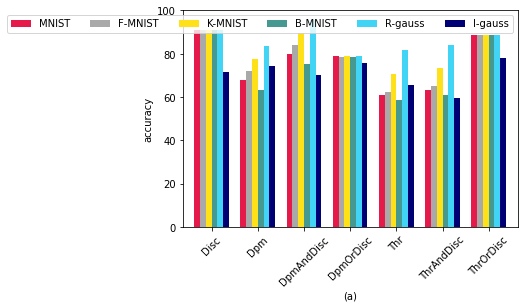

In [ ]:
ticks = ['Disc', 'Dpm', 'DpmAndDisc', 'DpmOrDisc', 'Thr', 'ThrAndDisc', 'ThrOrDisc']

ax = acc_ds_df_pivot_num.plot(kind="bar", width=0.75, color=["#e6194B", "#a9a9a9", "#ffe119", "#469990", "#42d4f4", "#000075"])
ax.set_xticklabels(ticks, rotation=45)
ax.set_xlabel('(a)')
ax.set_ylabel('accuracy')
ax.legend(ncol=len(ticks))

### Arabic

In [ ]:
results_df = all_results_arabic.copy()
results_df = results_df.loc[(results_df['ood_ratio']!='0') | ((results_df['ood_ratio']=='0') & (results_df['ds']=="clean"))]

In [ ]:
results_df['thr'] = results_df['thr'].astype(float)
results_df['ood_ratio'] = results_df['ood_ratio'].astype(int)

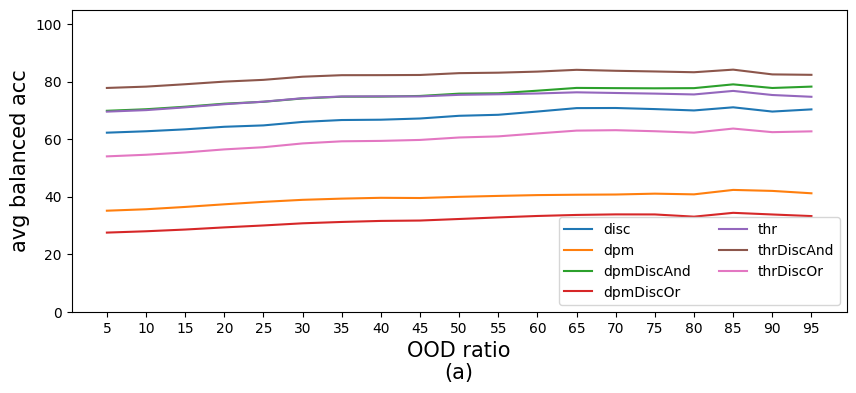

In [ ]:
ratio_low, ratio_high = 5, 95
thr_low, thr_high = 0.9, 0.99

all_plot = results_df.loc[ (results_df['ood_ratio']>=ratio_low) & (results_df['ood_ratio']<=ratio_high) \
                          & (((results_df['thr'] >= thr_low) & (results_df['thr'] <= thr_high)) | (results_df['thr'].isnull()))]

# all_plot_mean = all_plot.groupby(['exp', 'ood_ratio']).mean()
# all_plot_mean.reset_index(inplace=True)
# all_plot_mean.groupby('exp')['ood_ratio'].plot(x='ood_ratio', y='acc', legend=True)

all_plot_pivot_arabic = pd.pivot_table(all_plot, index=['exp', 'ood_ratio'], values=['acc_balanced'], aggfunc={'acc_balanced':np.mean}).unstack()

column_names = list()
for col in all_plot_pivot_arabic.columns:
  column_names.append(str(col[1]))

# all_plot_pivot.rename(columns=column_names, inplace=True)
all_plot_pivot_arabic.columns = column_names
# all_plot_pivot.rename(columns=column_names, inplace=True)
# all_plot_pivot.T.plot()
all_plot_pivot_arabic = all_plot_pivot_arabic.T

_, ax = plt.subplots(figsize=(10,4), dpi=100)

ax.plot(all_plot_pivot_arabic)
ax.set_ylim([0,105])
# ax.xaxis.set_ticks(np.arange(0,100,5))
ax.legend(labels=all_plot_pivot_arabic.columns, ncol=2, loc='lower right')
ax.set_xlabel('OOD ratio', size=15)
ax.set_ylabel('avg balanced acc', size=15)
ax.set_title('(a)', y=-0.25, size=15)
plt.show()

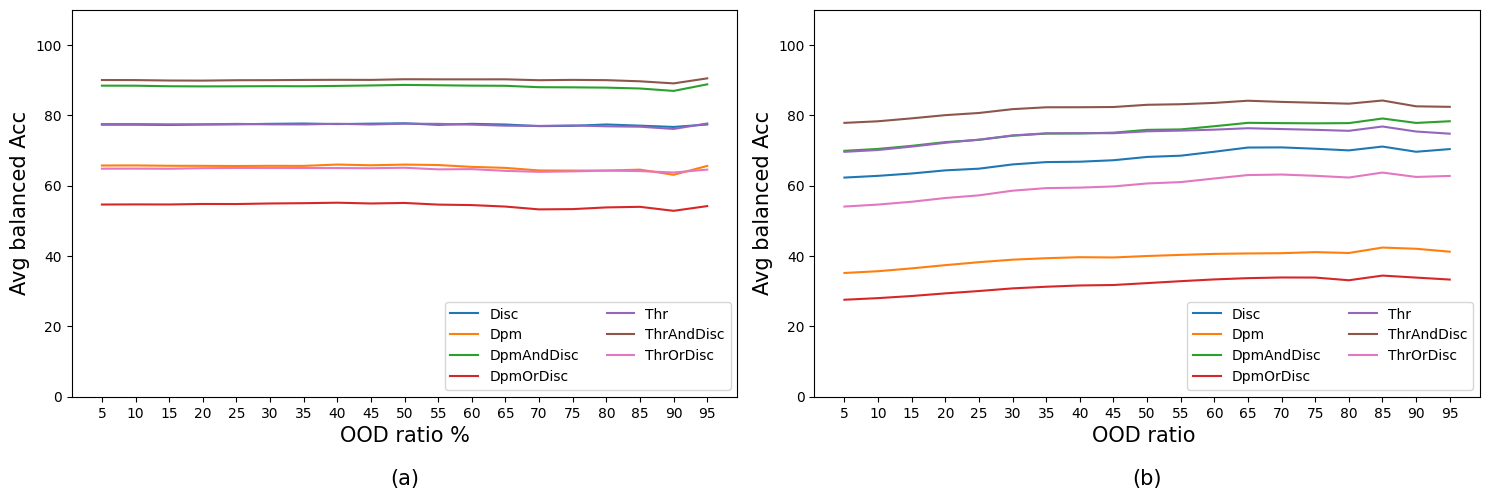

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), dpi=100)

labels = ['Disc', 'Dpm', 'DpmAndDisc', 'DpmOrDisc', 'Thr', 'ThrAndDisc', 'ThrOrDisc']

ax1.plot(all_plot_pivot)
ax1.set_ylim([0, 110])
ax1.set_xlabel('OOD ratio %', size=15)
ax1.set_ylabel('Avg balanced Acc', size=15)
ax1.set_title('(a)', y=-0.25, size=15)
ax1.legend(labels=labels, ncol=2, loc='lower right')

ax2.plot(all_plot_pivot_arabic)
ax2.set_ylim([0, 110])
ax2.set_xlabel('OOD ratio ', size=15)
ax2.set_ylabel('Avg balanced Acc', size=15)
ax2.set_title('(b)', y=-0.25, size=15)
ax2.legend(labels=labels, ncol=2, loc='lower right')

plt.subplots_adjust(left=0.2,bottom=0.2, top = 0.9, right = 0.9)
plt.tight_layout()
plt.savefig('a_num_b_arab.png')
plt.show()

In [ ]:
['disc', 'dpm', 'dpmAndDisc', 'dpmOrDisc', 'thr', 'thrAndDisc', 'thrOrDisc']

In [ ]:
all_plot_pivot_arabic.columns

Index(['disc', 'dpm', 'dpmDiscAnd', 'dpmDiscOr', 'thr', 'thrDiscAnd',
       'thrDiscOr'],
      dtype='object', name='exp')

In [ ]:
Thr_df = results_df[['exp','thr','acc_balanced']].loc[(results_df['thr']==0.9)]
noThr_df = results_df[['exp','thr','acc_balanced']].loc[(results_df['exp'].str.contains('thr')==False)]

ratio_mean_df = pd.concat([Thr_df, noThr_df]).groupby('exp').mean()
ratio_mean_df.rename(columns = {'acc_balanced':'mean_balanced'}, inplace = True)
ratio_std_df = pd.concat([Thr_df, noThr_df]).groupby('exp').std()
ratio_std_df.rename(columns = {'acc_balanced':'std_balanced'}, inplace = True)

ratio_df = pd.concat([ratio_mean_df, ratio_std_df], axis=1)
ratio_df.drop(columns=['thr'], inplace=True)

ratio_df

mean_balanced  std_balanced
exp                                    
disc            68.716614      7.685177
dpm             41.645827     12.106906
dpmDiscAnd      75.773465      5.721680
dpmDiscOr       34.589134     14.850353
thr             76.235669      7.116098
thrDiscAnd      81.298425      7.631254
thrDiscOr       63.654173      8.794750

In [ ]:
Thr_df = results_df[['exp','thr','acc']].loc[(results_df['thr']==0.99)]
noThr_df = results_df[['exp','thr','acc']].loc[(results_df['exp'].str.contains('thr')==False)]

ratio_mean_df = pd.concat([Thr_df, noThr_df]).groupby('exp').mean()
ratio_mean_df.rename(columns = {'acc':'mean'}, inplace = True)
ratio_std_df = pd.concat([Thr_df, noThr_df]).groupby('exp').std()
ratio_std_df.rename(columns = {'acc':'std'}, inplace = True)

ratio_df = pd.concat([ratio_mean_df, ratio_std_df], axis=1)
ratio_df.drop(columns=['thr'], inplace=True)

ratio_df

mean        std
exp                             
disc        82.084567  12.169797
dpm         64.387717  19.938642
dpmDiscAnd  82.808504  10.818063
dpmDiscOr   63.662756  23.056189
thr         73.830079  17.336345
thrDiscAnd  80.713307  16.260241
thrDiscOr   75.201417  16.491912

In [ ]:
ratio = 5
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'acc_balanced']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'acc_balanced':'mean_balanced'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'acc_balanced':'std_balanced'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean_balanced  std_balanced
exp                                    
disc            62.290000      0.000000
dpm             35.161667      0.440292
dpmDiscAnd      69.900000      0.444342
dpmDiscOr       27.550000      0.000000
thr             75.073024      8.383988
thrDiscAnd      78.359853      1.818993
thrDiscOr       59.002920      6.699079

In [ ]:
ratio = 5
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'acc']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'acc':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'acc':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean       std
exp                            
disc        62.873333  0.010328
dpm         36.118333  0.635466
dpmDiscAnd  70.275000  0.639085
dpmDiscOr   28.716667  0.020656
thr         74.285280  7.957172
thrDiscAnd  77.518510  1.731970
thrDiscOr   59.641032  6.589533

In [ ]:
ratio = 95
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'acc_balanced']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'acc_balanced':'mean_balanced'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'acc_balanced':'std_balanced'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean_balanced  std_balanced
exp                                    
disc            70.390000      0.000000
dpm             41.216667      0.506702
dpmDiscAnd      78.308333      0.502650
dpmDiscOr       33.290000      0.000000
thr             78.956003      8.304998
thrDiscAnd      82.242655      1.336502
thrDiscOr       67.101062      7.171257

In [ ]:
ratio = 95
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'acc']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'acc':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'acc':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean        std
exp                             
disc        98.520000   0.000000
dpm         90.376667  13.939179
dpmDiscAnd  92.251667  13.941943
dpmDiscOr   96.640000   0.000000
thr         28.676888  31.515337
thrDiscAnd  28.840885  31.725472
thrDiscOr   98.356254   0.360818

#### Sensitivity

In [ ]:
Thr_df = results_df[['exp','thr','sensitivity']].loc[(results_df['thr']==thr)]
noThr_df = results_df[['exp','thr','sensitivity']].loc[(results_df['exp'].str.contains('thr')==False)]

ratio_mean_df = pd.concat([Thr_df, noThr_df]).groupby('exp').mean()
ratio_mean_df.rename(columns = {'sensitivity':'mean'}, inplace = True)
ratio_std_df = pd.concat([Thr_df, noThr_df]).groupby('exp').std()
ratio_std_df.rename(columns = {'sensitivity':'std'}, inplace = True)

ratio_df = pd.concat([ratio_mean_df, ratio_std_df], axis=1)
ratio_df.drop(columns=['thr'], inplace=True)

ratio_df

mean       std
exp                            
disc        76.726612  2.415043
dpm         37.459752  2.284638
dpmDiscAnd  84.972231  2.275076
dpmDiscOr   29.216612  2.388561
thr         69.981240  2.349086
thrDiscAnd  91.900909  1.226925
thrDiscOr   54.807934  3.333687

In [ ]:
ratio = 5
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'sensitivity']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'sensitivity':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'sensitivity':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean        std
exp                             
disc        85.810000   0.000000
dpm         65.170000   0.000000
dpmDiscAnd  95.790000   0.000000
dpmDiscOr   55.190000   0.000000
thr         92.177876  12.481500
thrDiscAnd  99.067788   1.665545
thrDiscOr   78.918850  10.827323

In [ ]:
ratio = 95
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'sensitivity']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'sensitivity':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'sensitivity':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean        std
exp                             
disc        85.120000   0.000000
dpm         65.080000   0.000000
dpmDiscAnd  95.450000   0.000000
dpmDiscOr   54.750000   0.000000
thr         92.161239  12.436413
thrDiscAnd  99.261504   1.708646
thrDiscOr   78.023451  10.785006

#### Specifity

In [ ]:
thr = 0.99
Thr_df = results_df[['exp','thr','specifity']].loc[(results_df['thr']==thr)]
noThr_df = results_df[['exp','thr','specifity']].loc[(results_df['exp'].str.contains('thr')==False)]

ratio_mean_df = pd.concat([Thr_df, noThr_df]).groupby('exp').mean()
ratio_mean_df.rename(columns = {'specifity':'mean'}, inplace = True)
ratio_std_df = pd.concat([Thr_df, noThr_df]).groupby('exp').std()
ratio_std_df.rename(columns = {'specifity':'std'}, inplace = True)

ratio_df = pd.concat([ratio_mean_df, ratio_std_df], axis=1)
ratio_df.drop(columns=['thr'], inplace=True)

ratio_df

mean        std
exp                              
disc        100.000000   0.000000
dpm          93.160417  13.249167
dpmDiscAnd   93.160417  13.249167
dpmDiscOr   100.000000   0.000000
thr          82.525500  27.479572
thrDiscAnd   82.525500  27.479572
thrDiscOr   100.000000   0.000000

In [ ]:
ratio = 5
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'specifity']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'specifity':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'specifity':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean        std
exp                              
disc        100.000000   0.000000
dpm          93.966667  12.818996
dpmDiscAnd   93.966667  12.818996
dpmDiscOr   100.000000   0.000000
thr          25.796195  33.601576
thrDiscAnd   25.796195  33.601576
thrDiscOr   100.000000   0.000000

In [ ]:
ratio = 95
thr_range = [0.90, 0.99]
ratio_df = results_df[['exp','thr', 'ood_ratio', 'specifity']].loc[(results_df['ood_ratio']==ratio)]
ratio_df['thr'] = ratio_df['thr'].astype(float)

h_thr_df = ratio_df.loc[(ratio_df['thr']>=thr_range[0])]
l_thr_df = ratio_df.loc[(ratio_df['thr']<=thr_range[1])]
no_thr_df = ratio_df.loc[(ratio_df['exp'].str.contains('thr')==False)]

thr_mean_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').mean()
thr_mean_df.rename(columns = {'specifity':'mean'}, inplace = True)
thr_std_df = pd.concat([h_thr_df, l_thr_df, no_thr_df]).groupby('exp').std()
thr_std_df.rename(columns = {'specifity':'std'}, inplace = True)

thr_df = pd.concat([thr_mean_df, thr_std_df], axis=1)
thr_df.drop(columns=['thr', 'ood_ratio'], inplace=True)

thr_df

mean        std
exp                              
disc        100.000000   0.000000
dpm          92.993333  14.648406
dpmDiscAnd   92.993333  14.648406
dpmDiscOr   100.000000   0.000000
thr          26.016637  33.406159
thrDiscAnd   26.016637  33.406159
thrDiscOr   100.000000   0.000000

#### Pivot table acc vs dataset

In [ ]:
thr_range = [0.90, 0.99]
acc_ds_df = results_df[['exp', 'acc', 'ds', 'thr']]

h_thr_df = acc_ds_df.loc[(acc_ds_df['thr']>=thr_range[0])]
l_thr_df = acc_ds_df.loc[(acc_ds_df['thr']<=thr_range[1])]
no_thr_df = acc_ds_df.loc[(acc_ds_df['exp'].str.contains('thr')==False)]
acc_ds_df = pd.concat([h_thr_df, l_thr_df, no_thr_df])

acc_ds_df.loc[acc_ds_df["ds"]=="mnist", "ds"] = "MNIST"
acc_ds_df.loc[acc_ds_df["ds"]=="fmnist", "ds"] = "F-MNIST"
acc_ds_df.loc[acc_ds_df["ds"]=="bmnist", "ds"] = "B-MNIST"
acc_ds_df.loc[acc_ds_df["ds"]=="kmnist", "ds"] = "K-MNIST"
acc_ds_df.loc[acc_ds_df["ds"]=="rnd", "ds"] = "R-gauss"
acc_ds_df.loc[acc_ds_df["ds"]=="arabic", "ds"] = "I-gauss"

acc_ds_df_pivot_arabic = pd.pivot_table(acc_ds_df, index=['exp', 'ds'], values=['acc'], aggfunc={'acc':np.mean}).unstack().reset_index().rename_axis(None)

acc_ds_df_pivot_arabic.drop(columns=[('acc',  'clean')], inplace=True)

acc_ds_df_pivot_arabic = acc_ds_df_pivot_arabic.droplevel(0, axis=1)

cols = ["MNIST", "F-MNIST", "K-MNIST", "B-MNIST", "R-gauss", "I-gauss"]
acc_ds_df_pivot_arabic = acc_ds_df_pivot_arabic[cols]

# acc_ds_df_pivot_num.drop(columns=["ds"], inplace=True)

acc_ds_df_pivot_arabic.columns.names = [None]

acc_ds_df_pivot_arabic

MNIST    F-MNIST    K-MNIST    B-MNIST    R-gauss    I-gauss
0  83.346000  83.353000  83.353000  83.346000  83.353000  83.353000
1  69.843500  67.564000  69.646500  69.783000  69.877000  50.720500
2  87.253500  84.968000  87.052000  87.193000  87.282000  68.124500
3  65.935500  65.947000  65.947000  65.935500  65.947000  65.947000
4  54.328097  52.219226  52.852274  54.627695  55.038226  40.863850
5  55.880013  53.770491  54.403748  56.179637  56.589730  42.415341
6  81.794451  81.801761  81.801761  81.794451  81.801761  81.801761

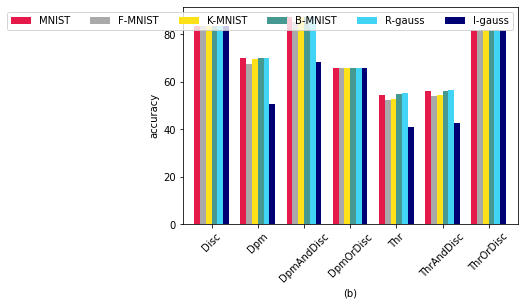

In [ ]:
ticks = ['Disc', 'Dpm', 'DpmAndDisc', 'DpmOrDisc', 'Thr', 'ThrAndDisc', 'ThrOrDisc']

ax = acc_ds_df_pivot_arabic.plot(kind="bar", width=0.75, color=["#e6194B", "#a9a9a9", "#ffe119", "#469990", "#42d4f4", "#000075"])
ax.set_xticklabels(ticks, rotation=45)
ax.set_xlabel('(b)')
ax.set_ylabel('accuracy')
ax.legend(ncol=len(ticks))

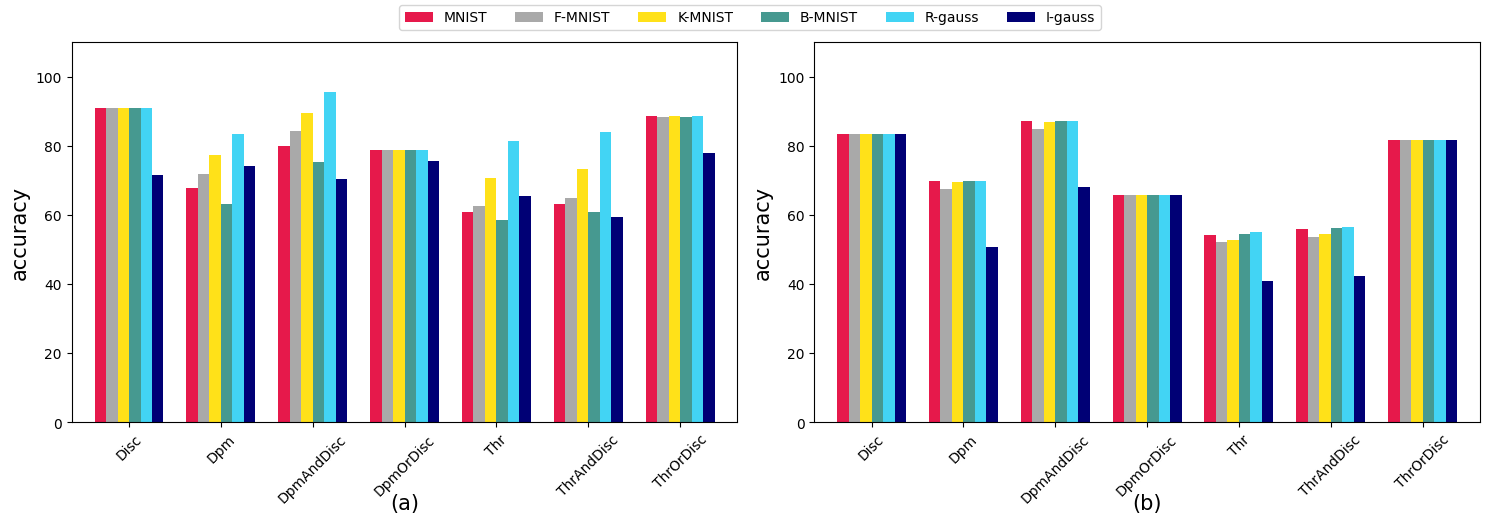

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), dpi=100)

acc_ds_df_pivot_num.plot(ax=ax1, kind="bar", width=0.75, color=["#e6194B", "#a9a9a9", "#ffe119", "#469990", "#42d4f4", "#000075"])
ax1.set_xticklabels(ticks, rotation=45)
ax1.set_ylim([0, 110])
ax1.set_ylabel('accuracy', size=15)
ax1.set_title('(a)', y=-0.25, size=15)
ax1.get_legend().remove()

acc_ds_df_pivot_arabic.plot(ax=ax2, kind="bar", width=0.75, color=["#e6194B", "#a9a9a9", "#ffe119", "#469990", "#42d4f4", "#000075"])
ax2.set_xticklabels(ticks, rotation=45)
ax2.set_ylim([0, 110])
ax2.set_ylabel('accuracy', size=15)
ax2.set_title('(b)', y=-0.25, size=15)
ax2.get_legend().remove()

fig.legend(cols, ncol=len(cols), loc='upper center', bbox_to_anchor=(0.5, 1.05))

fig.tight_layout()
# fig.subplots_adjust(left=0.2, bottom=0.2, top = 0.9, right = 0.9)
fig.savefig('bar_chart.png', bbox_inches='tight')
fig.show()

In [ ]:



fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), dpi=100)

labels = ['Disc', 'Dpm', 'DpmAndDisc', 'DpmOrDisc', 'Thr', 'ThrAndDisc', 'ThrOrDisc']

ax1.plot(all_plot_pivot)
ax1.set_ylim([0, 110])
ax1.set_xlabel('OOD ratio %', size=15)
ax1.set_ylabel('Avg balanced Acc', size=15)
ax1.set_title('(a)', y=-0.25, size=15)
ax1.legend(labels=labels, ncol=2, loc='lower right')

ax2.plot(all_plot_pivot_arabic)
ax2.set_ylim([0, 110])
ax2.set_xlabel('OOD ratio ', size=15)
ax2.set_ylabel('Avg balanced Acc', size=15)
ax2.set_title('(b)', y=-0.25, size=15)
ax2.legend(labels=labels, ncol=2, loc='lower right')

plt.subplots_adjust(left=0.2,bottom=0.2, top = 0.9, right = 0.9)
plt.tight_layout()
plt.savefig('a_num_b_arab.png')
plt.show()

## plotting

### Plot Acc vs. ratio

In [ ]:
y = 'acc'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  81.98  11.46
1               disc  82.25  12.31
2  thrDiscAnd - 0.99  88.80   7.10
3   thrDiscOr - 0.99  75.43  16.69
4                dpm  68.07  20.74
5         dpmDiscAnd  86.36   9.71
6          dpmDiscOr  63.97  23.36

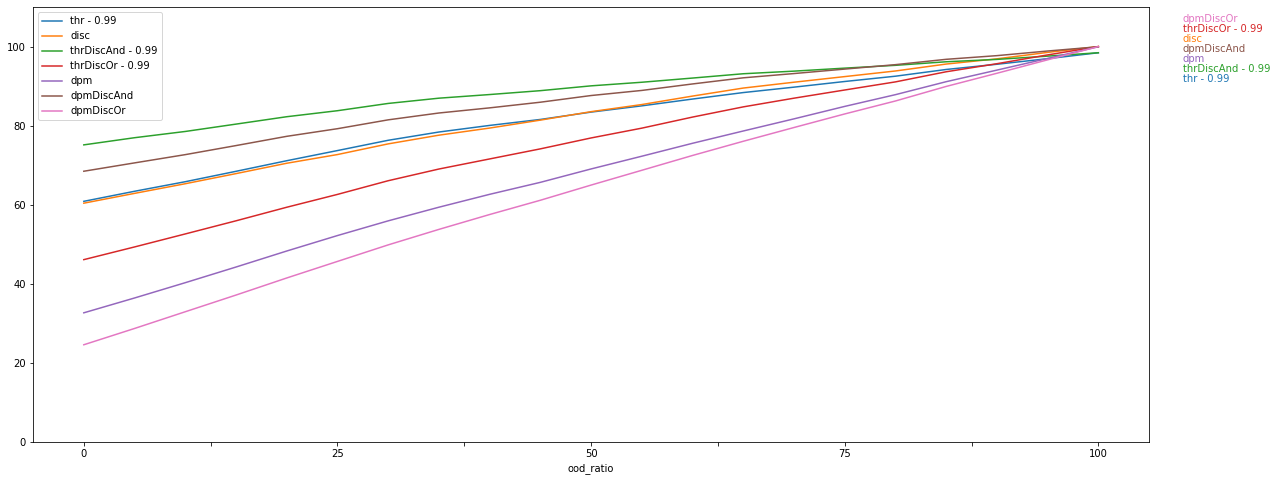

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  81.66  11.21
1               disc  82.25  12.31
2  thrDiscAnd - 0.99  88.49   6.85
3   thrDiscOr - 0.99  75.43  16.69
4                dpm  68.01  20.69
5         dpmDiscAnd  86.30   9.66
6          dpmDiscOr  63.97  23.36

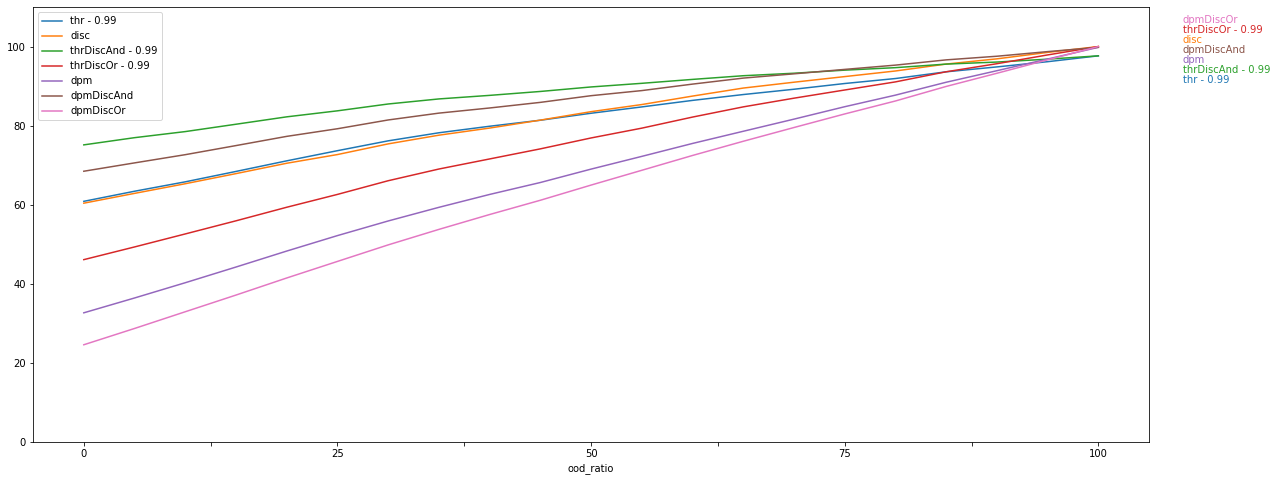

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  77.55   8.67
1               disc  82.26  12.31
2  thrDiscAnd - 0.99  84.38   4.34
3   thrDiscOr - 0.99  75.44  16.69
4                dpm  67.88  20.59
5         dpmDiscAnd  86.17   9.57
6          dpmDiscOr  63.98  23.35

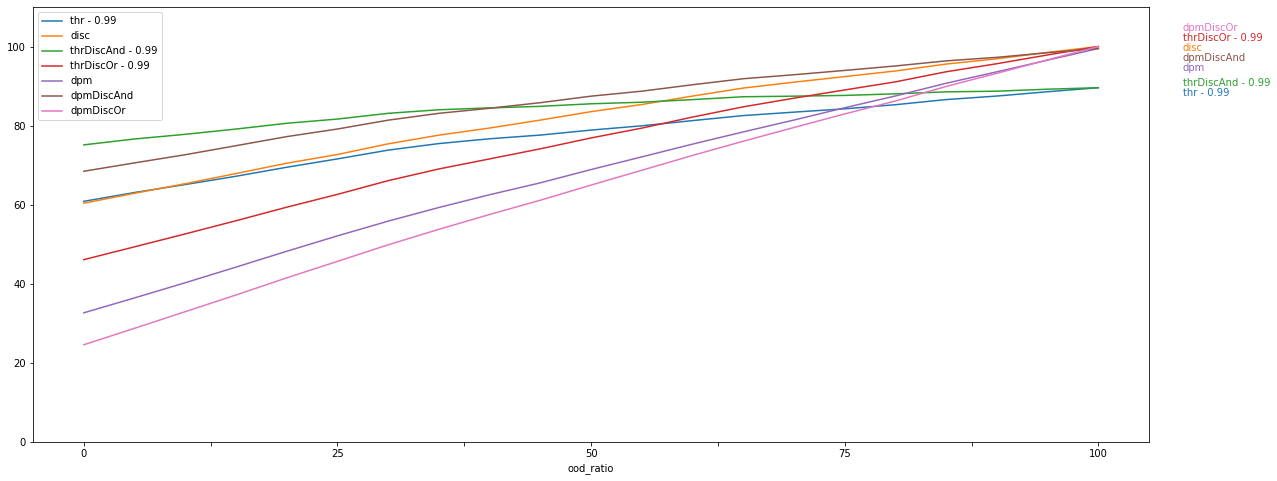

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  76.00   7.74
1               disc  82.26  12.31
2  thrDiscAnd - 0.99  82.82   3.46
3   thrDiscOr - 0.99  75.44  16.69
4                dpm  65.90  19.34
5         dpmDiscAnd  84.18   8.33
6          dpmDiscOr  63.98  23.35

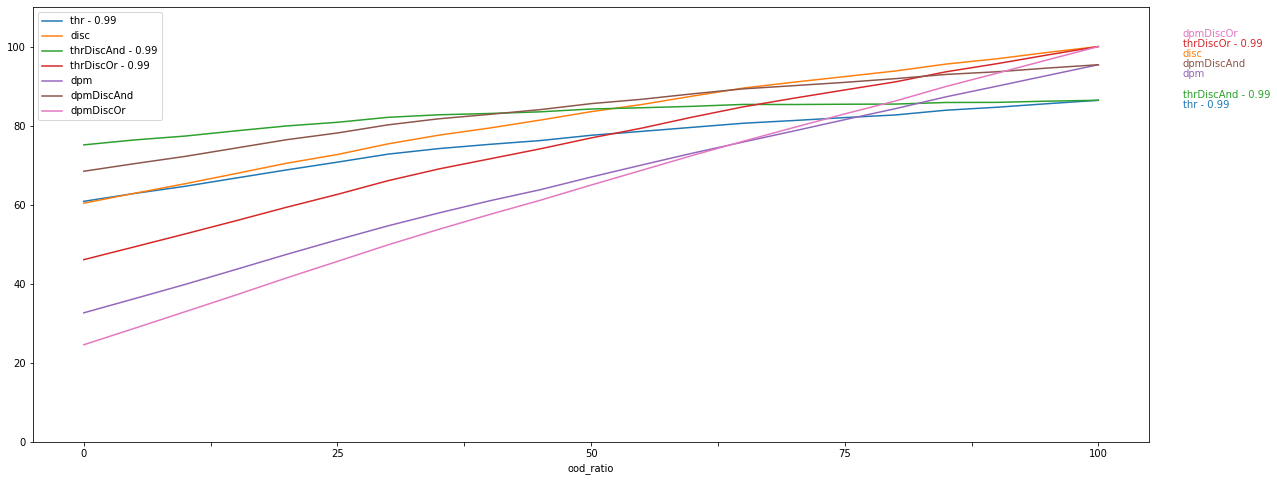

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  43.67  12.60
1               disc  82.26  12.31
2  thrDiscAnd - 0.99  50.49  16.93
3   thrDiscOr - 0.99  75.44  16.69
4                dpm  49.86   9.38
5         dpmDiscAnd  68.14   2.15
6          dpmDiscOr  63.98  23.35

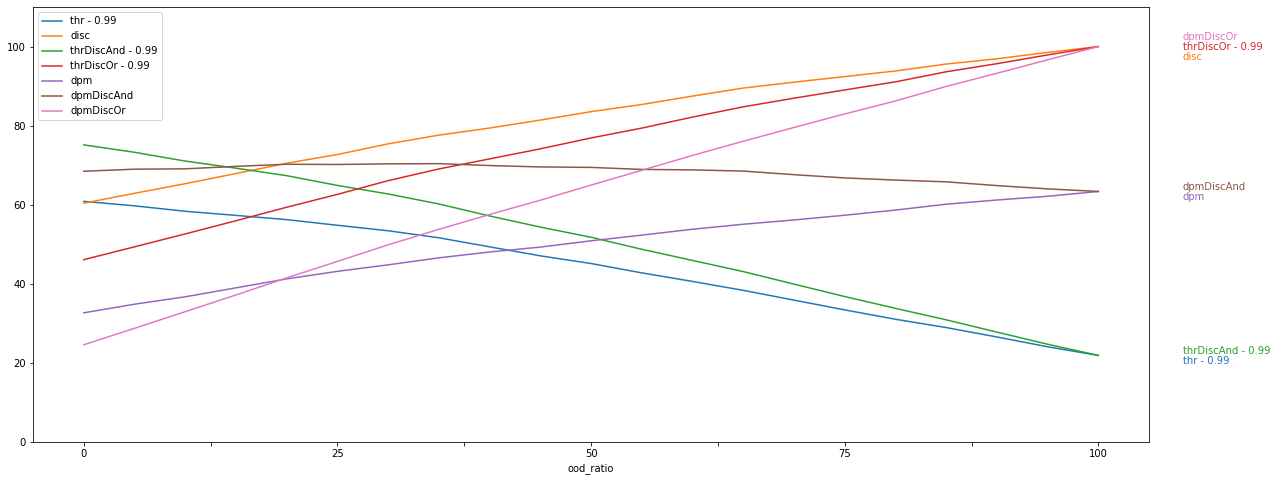

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  82.74  11.92
1               disc  82.26  12.31
2  thrDiscAnd - 0.99  89.56   7.55
3   thrDiscOr - 0.99  75.44  16.69
4                dpm  68.10  20.75
5         dpmDiscAnd  86.39   9.72
6          dpmDiscOr  63.98  23.35

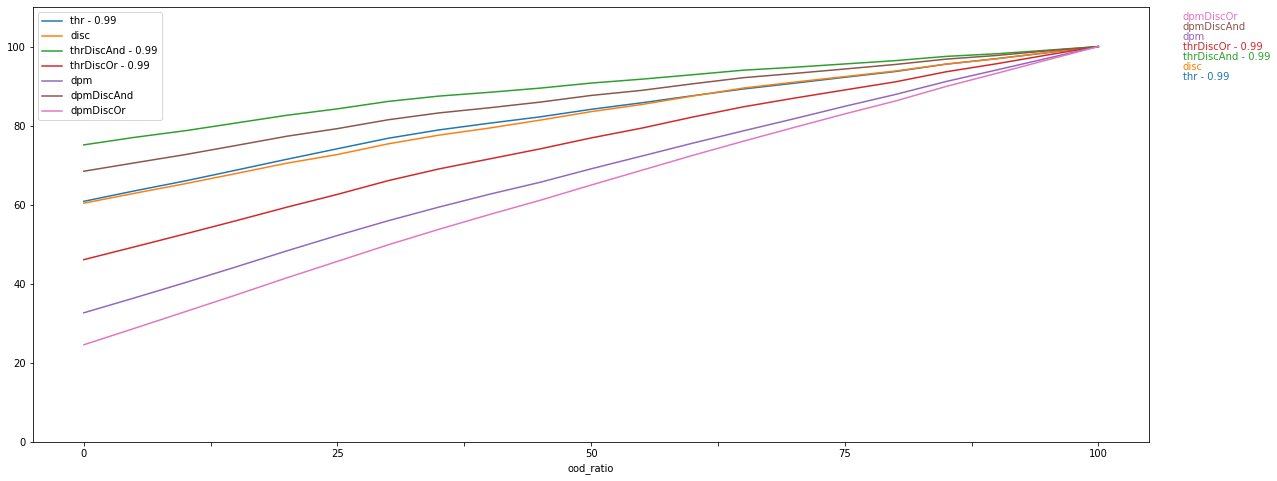

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot balanced Acc vs. ratio

In [ ]:
y = 'acc_balanced'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  69.23   7.24
1               disc  68.78   7.84
2  thrDiscAnd - 0.99  81.67   4.53
3   thrDiscOr - 0.99  56.34  10.61
4                dpm  42.26  13.45
5         dpmDiscAnd  76.37   6.22
6          dpmDiscOr  34.67  15.19

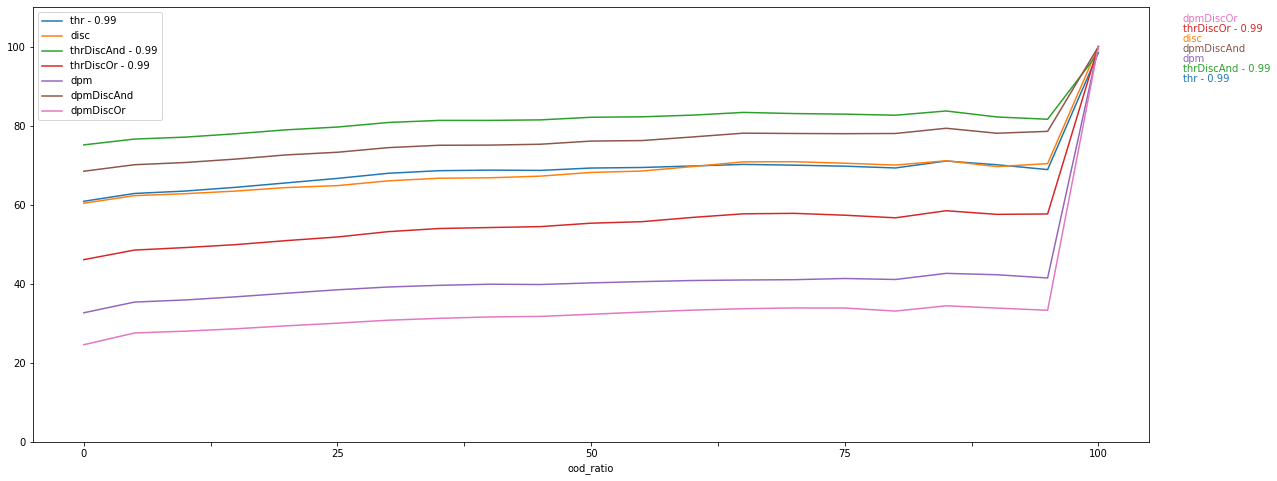

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  69.18   7.09
1               disc  68.78   7.84
2  thrDiscAnd - 0.99  81.62   4.38
3   thrDiscOr - 0.99  56.34  10.61
4                dpm  42.25  13.42
5         dpmDiscAnd  76.36   6.19
6          dpmDiscOr  34.67  15.19

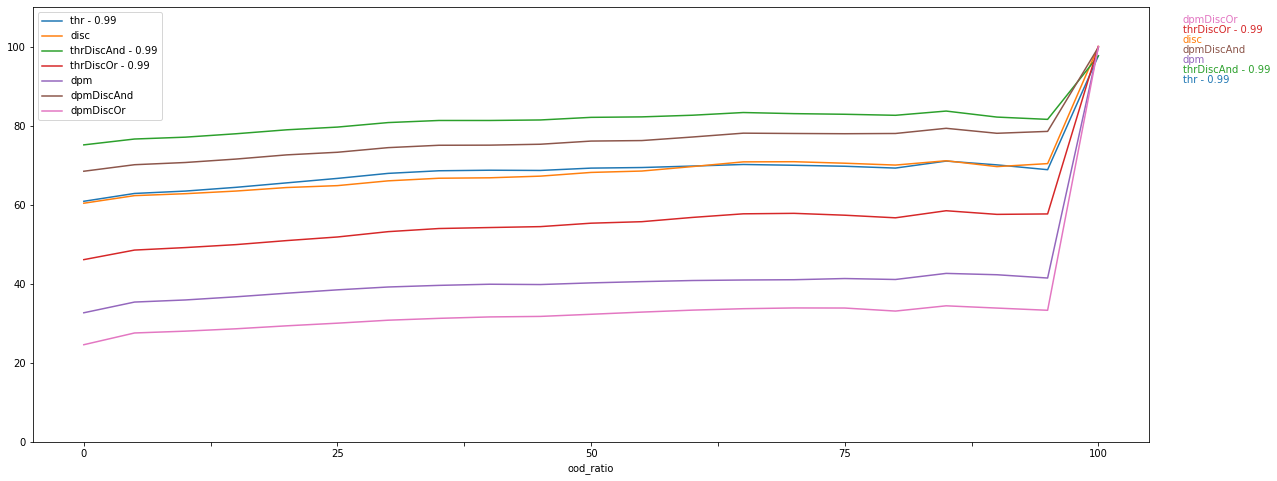

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  68.54   5.54
1               disc  68.78   7.84
2  thrDiscAnd - 0.99  80.98   3.06
3   thrDiscOr - 0.99  56.34  10.61
4                dpm  42.23  13.36
5         dpmDiscAnd  76.34   6.14
6          dpmDiscOr  34.67  15.19

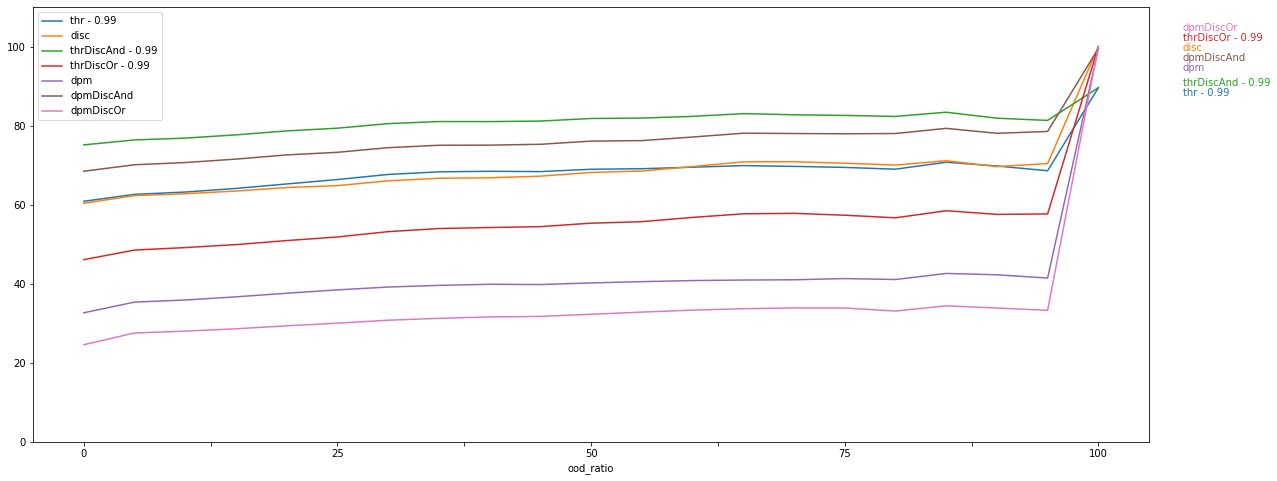

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  68.29   4.97
1               disc  68.78   7.84
2  thrDiscAnd - 0.99  80.73   2.68
3   thrDiscOr - 0.99  56.34  10.61
4                dpm  41.91  12.50
5         dpmDiscAnd  76.02   5.40
6          dpmDiscOr  34.67  15.19

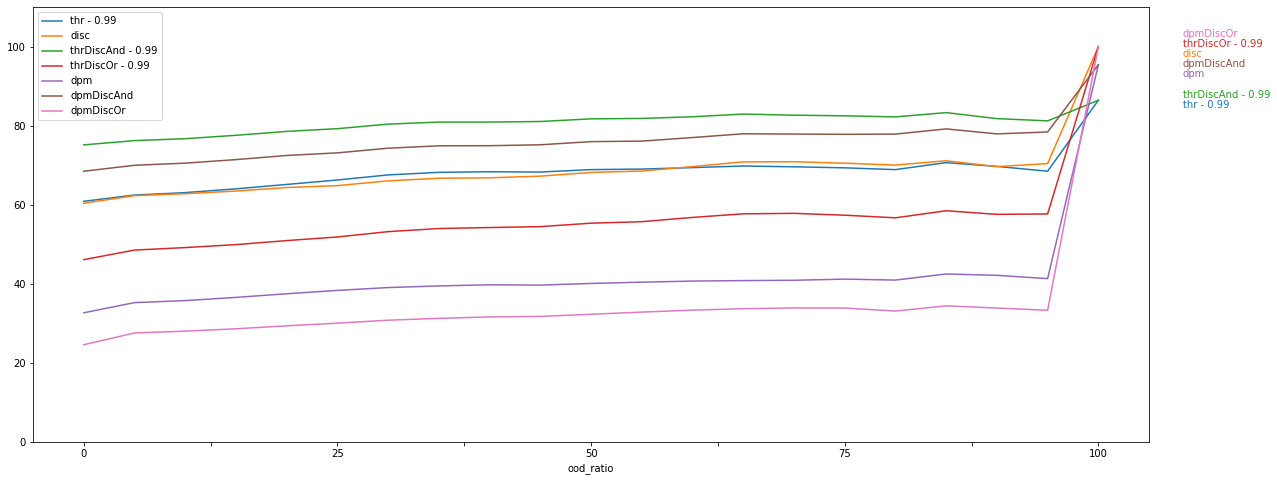

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  63.21   9.79
1               disc  68.78   7.84
2  thrDiscAnd - 0.99  75.65  12.50
3   thrDiscOr - 0.99  56.34  10.61
4                dpm  39.39   5.96
5         dpmDiscAnd  73.51   3.75
6          dpmDiscOr  34.67  15.19

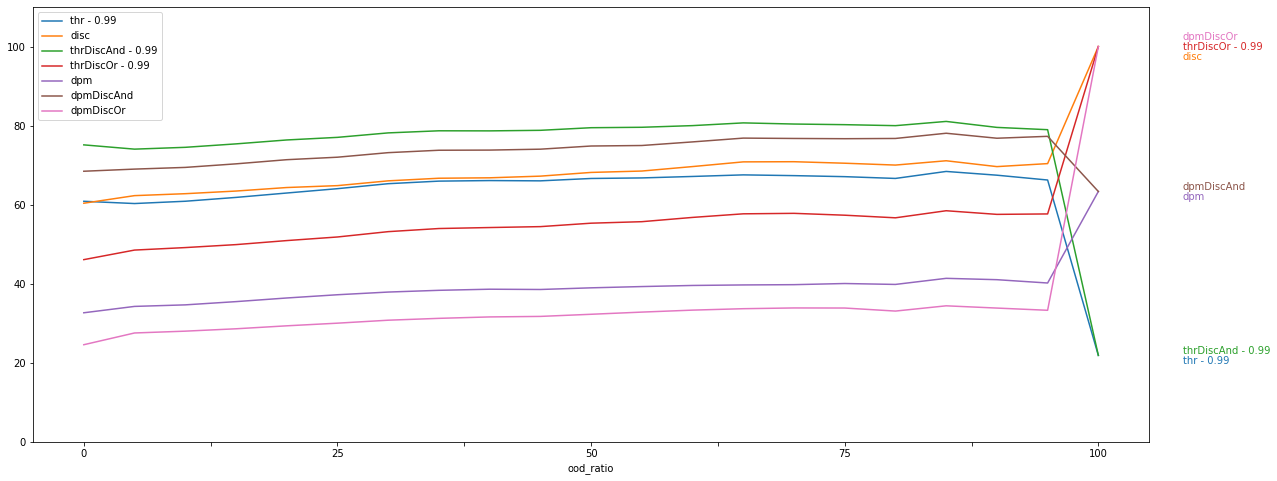

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  69.35   7.55
1               disc  68.78   7.84
2  thrDiscAnd - 0.99  81.79   4.81
3   thrDiscOr - 0.99  56.34  10.61
4                dpm  42.26  13.46
5         dpmDiscAnd  76.38   6.23
6          dpmDiscOr  34.67  15.19

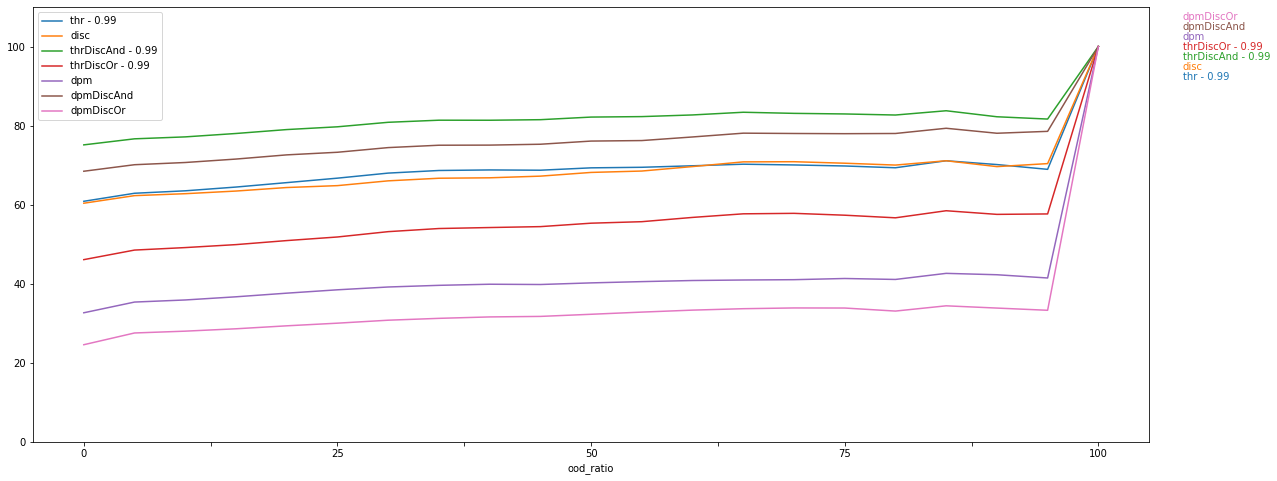

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot macro Precision vs. ratio

In [ ]:
y = 'P_macro'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  88.37  17.06
1               disc  86.69   4.04
2  thrDiscAnd - 0.99  82.39  15.76
3   thrDiscOr - 0.99  94.97   2.03
4                dpm  93.99  13.95
5         dpmDiscAnd  84.49  11.97
6          dpmDiscOr  96.68   1.65

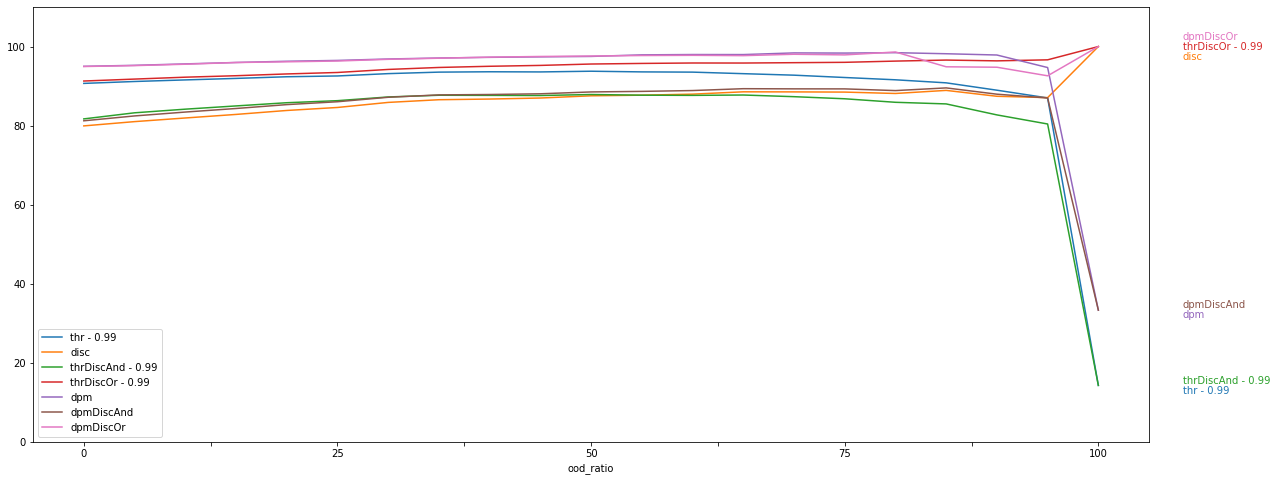

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  87.61  16.96
1               disc  86.69   4.04
2  thrDiscAnd - 0.99  81.74  15.67
3   thrDiscOr - 0.99  94.97   2.03
4                dpm  92.95  16.78
5         dpmDiscAnd  83.55  14.75
6          dpmDiscOr  96.68   1.65

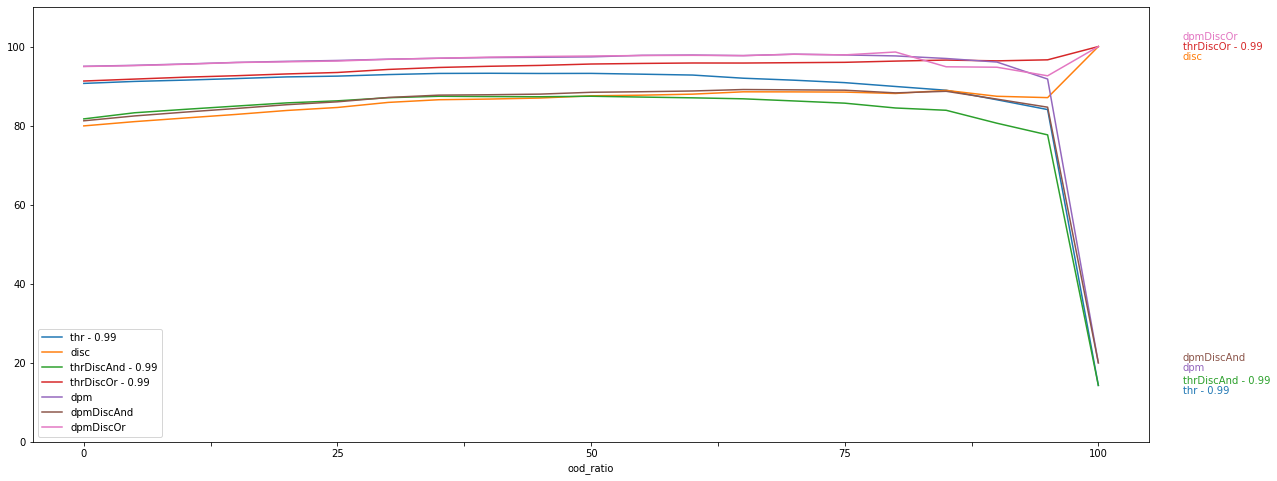

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  86.34  17.34
1               disc  86.69   4.04
2  thrDiscAnd - 0.99  80.69  16.07
3   thrDiscOr - 0.99  94.97   2.03
4                dpm  92.18  16.60
5         dpmDiscAnd  83.30  14.67
6          dpmDiscOr  96.68   1.65

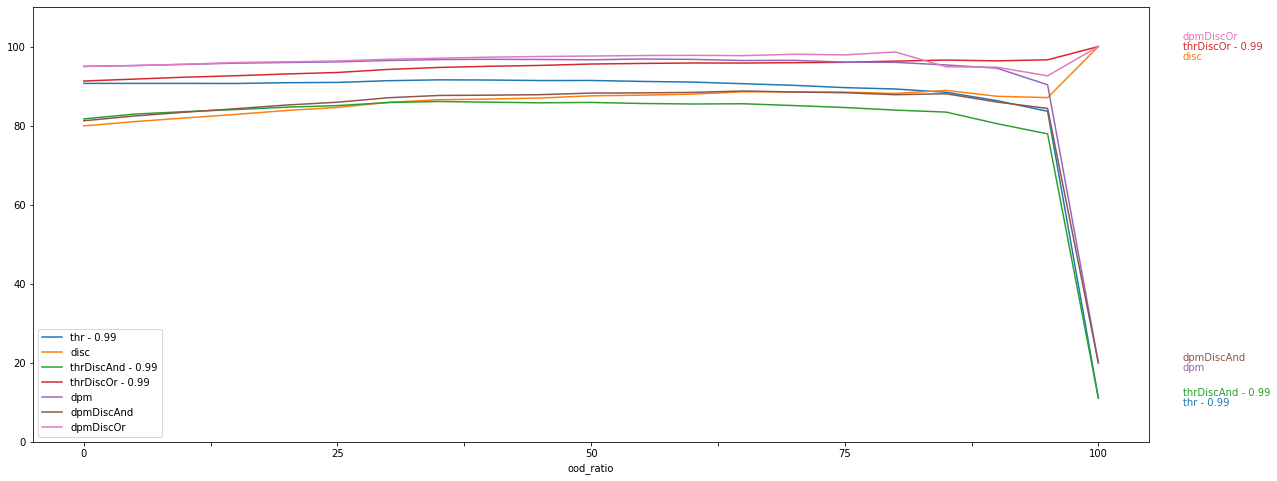

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  85.56  17.20
1               disc  86.69   4.04
2  thrDiscAnd - 0.99  80.08  15.94
3   thrDiscOr - 0.99  94.97   2.03
4                dpm  91.17  16.33
5         dpmDiscAnd  82.26  14.36
6          dpmDiscOr  96.68   1.65

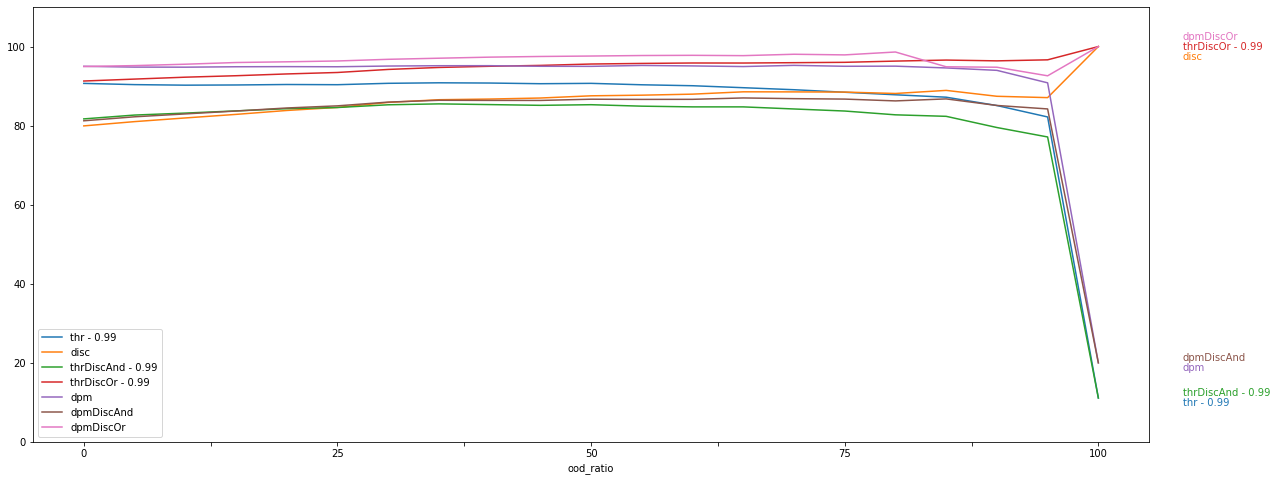

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  86.08  16.47
1               disc  86.69   4.04
2  thrDiscAnd - 0.99  80.39  15.23
3   thrDiscOr - 0.99  94.97   2.03
4                dpm  91.02  13.24
5         dpmDiscAnd  81.95  11.28
6          dpmDiscOr  96.68   1.65

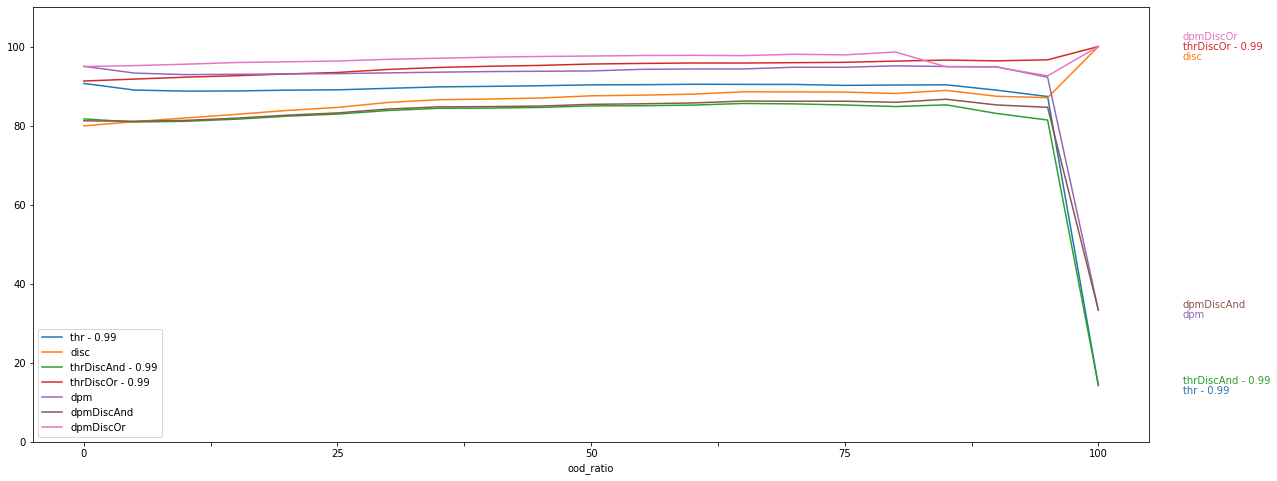

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  94.73  2.10
1               disc  86.69  4.04
2  thrDiscAnd - 0.99  88.24  3.52
3   thrDiscOr - 0.99  94.97  2.03
4                dpm  97.35  1.32
5         dpmDiscAnd  87.78  3.73
6          dpmDiscOr  96.68  1.65

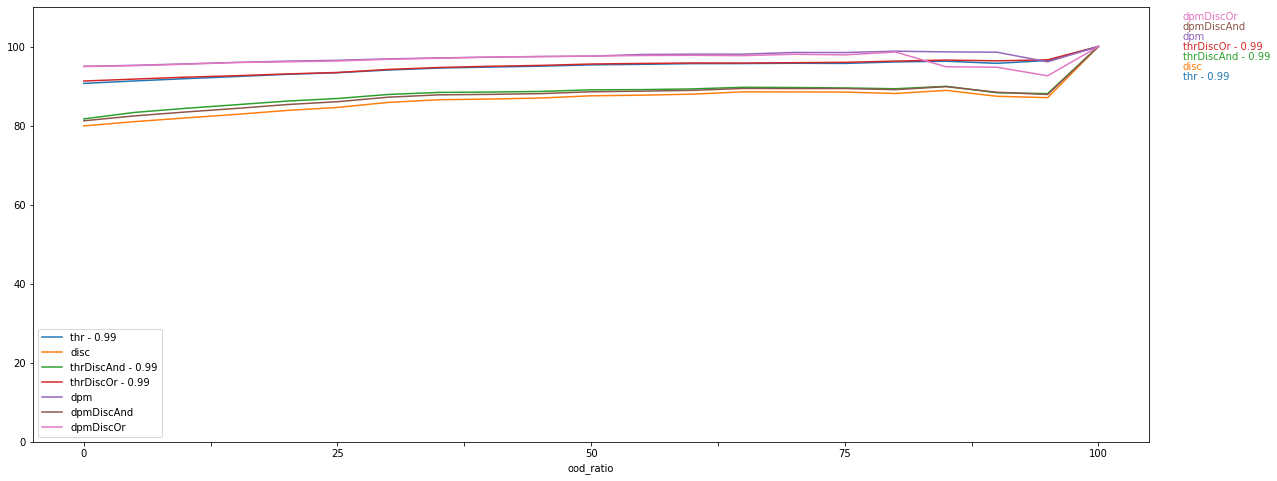

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot weighted Precision vs. ratio

In [ ]:
y = 'P_weighted'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean   std
0         thr - 0.99  89.21  5.07
1               disc  86.42  7.35
2  thrDiscAnd - 0.99  90.23  5.78
3   thrDiscOr - 0.99  87.83  5.87
4                dpm  87.15  6.52
5         dpmDiscAnd  88.69  6.59
6          dpmDiscOr  86.23  6.89

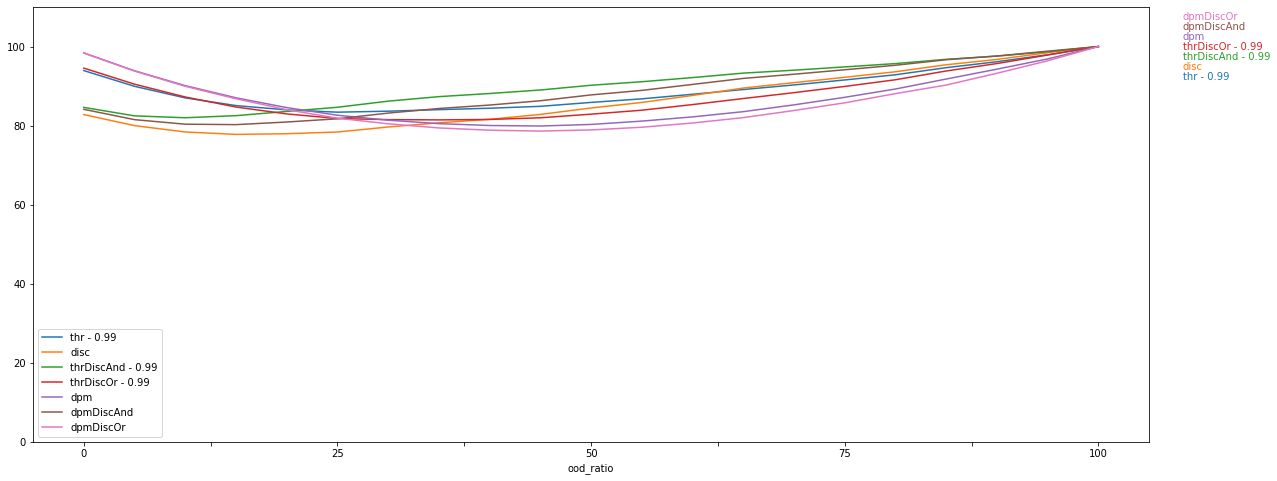

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  88.99  5.08
1               disc  86.42  7.35
2  thrDiscAnd - 0.99  90.06  5.71
3   thrDiscOr - 0.99  87.83  5.87
4                dpm  87.08  6.51
5         dpmDiscAnd  88.63  6.56
6          dpmDiscOr  86.23  6.89

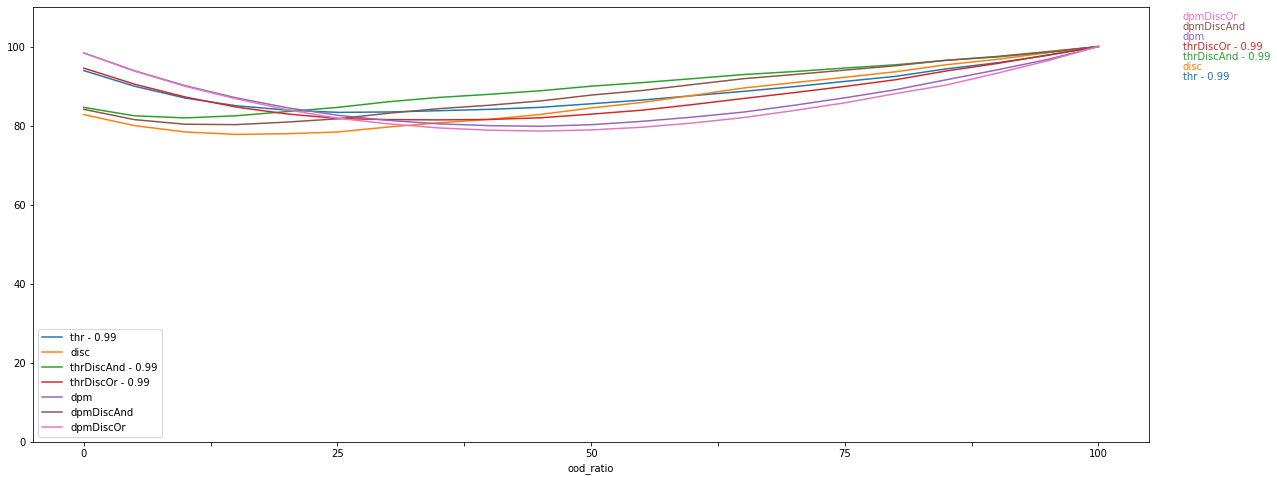

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  87.93  5.69
1               disc  86.42  7.35
2  thrDiscAnd - 0.99  89.36  6.00
3   thrDiscOr - 0.99  87.83  5.87
4                dpm  86.80  6.63
5         dpmDiscAnd  88.55  6.55
6          dpmDiscOr  86.23  6.88

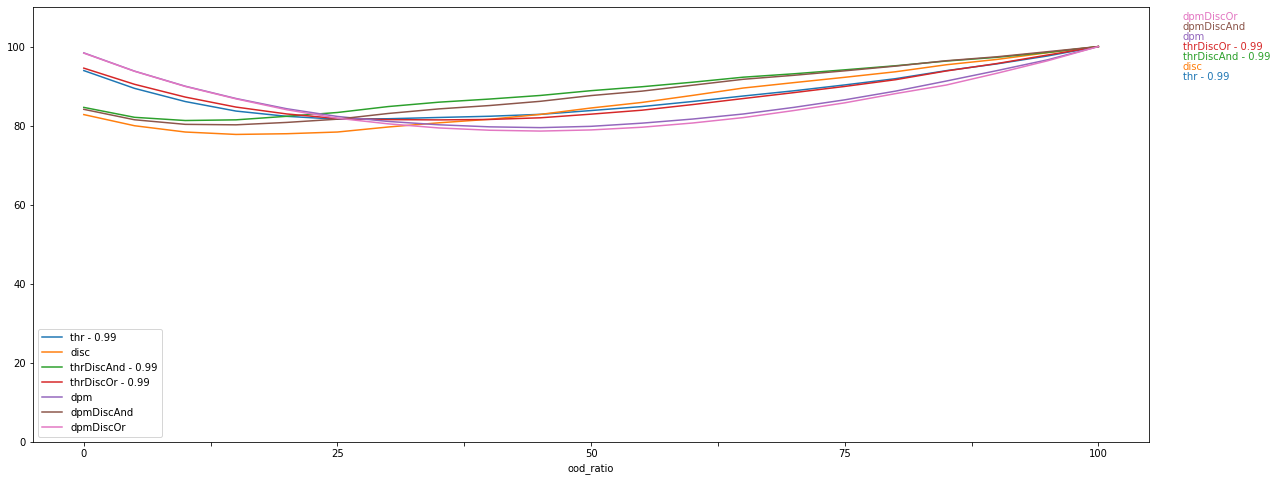

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  87.42  5.90
1               disc  86.42  7.35
2  thrDiscAnd - 0.99  89.02  6.11
3   thrDiscOr - 0.99  87.83  5.87
4                dpm  85.98  7.10
5         dpmDiscAnd  87.92  6.74
6          dpmDiscOr  86.23  6.88

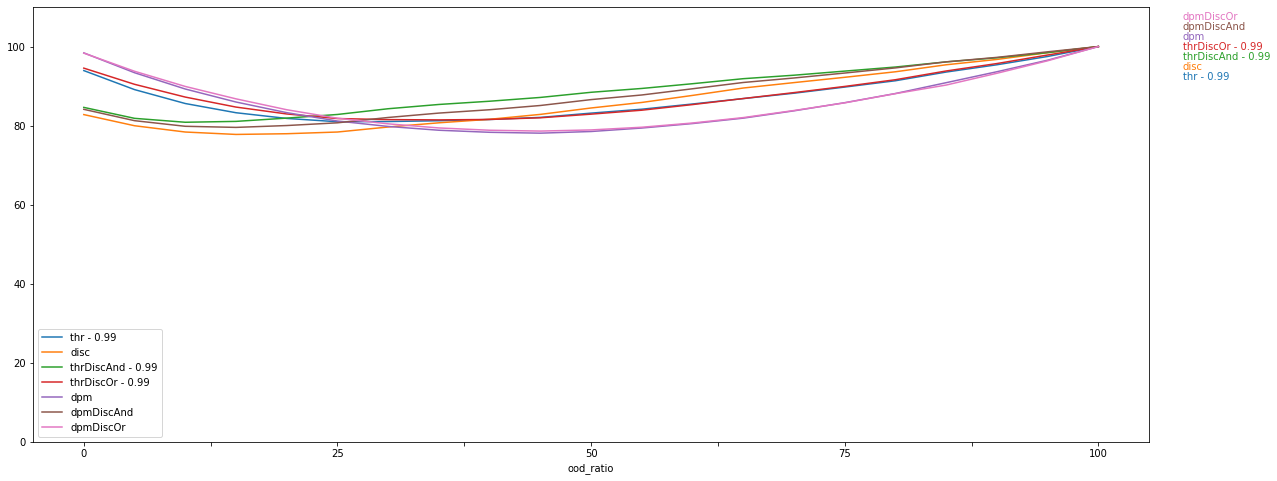

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  77.96  9.82
1               disc  86.42  7.35
2  thrDiscAnd - 0.99  83.61  8.07
3   thrDiscOr - 0.99  87.83  5.87
4                dpm  82.43  8.71
5         dpmDiscAnd  85.75  7.68
6          dpmDiscOr  86.23  6.88

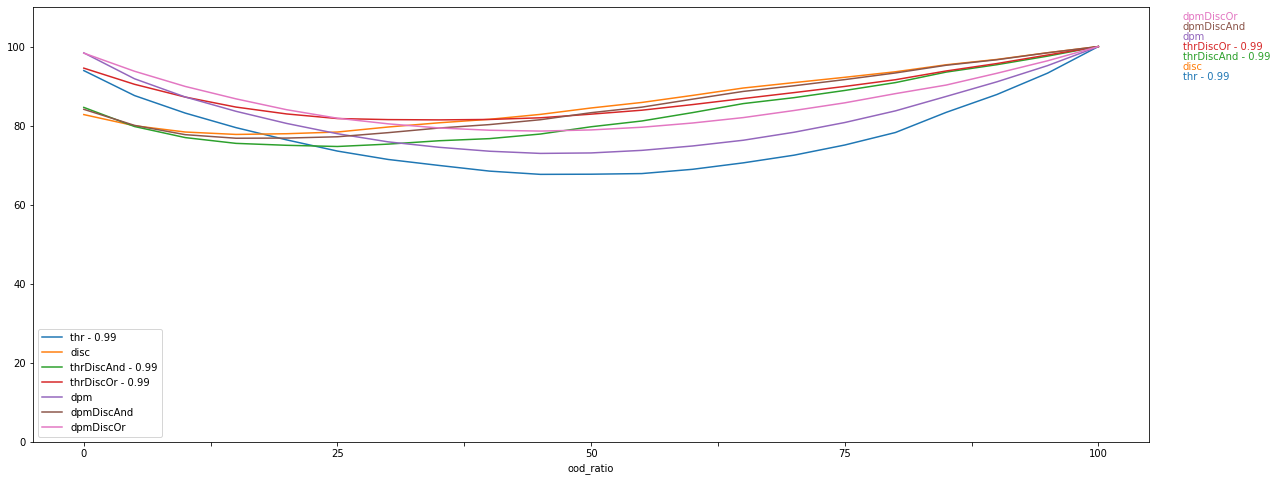

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  89.91  4.97
1               disc  86.42  7.35
2  thrDiscAnd - 0.99  90.73  5.88
3   thrDiscOr - 0.99  87.83  5.87
4                dpm  87.18  6.51
5         dpmDiscAnd  88.71  6.60
6          dpmDiscOr  86.23  6.88

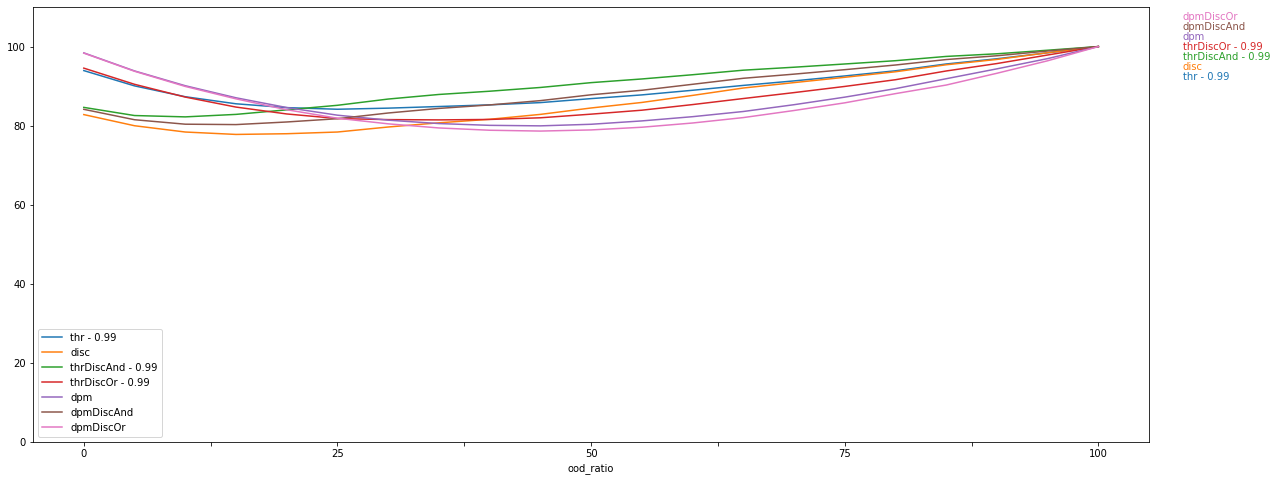

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot macro Recall vs. ratio

In [ ]:
y = 'R_macro'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  65.11  12.09
1               disc  68.68   7.96
2  thrDiscAnd - 0.99  77.53  14.80
3   thrDiscOr - 0.99  56.27  10.70
4                dpm  39.03   2.96
5         dpmDiscAnd  73.09   9.72
6          dpmDiscOr  34.63  15.22

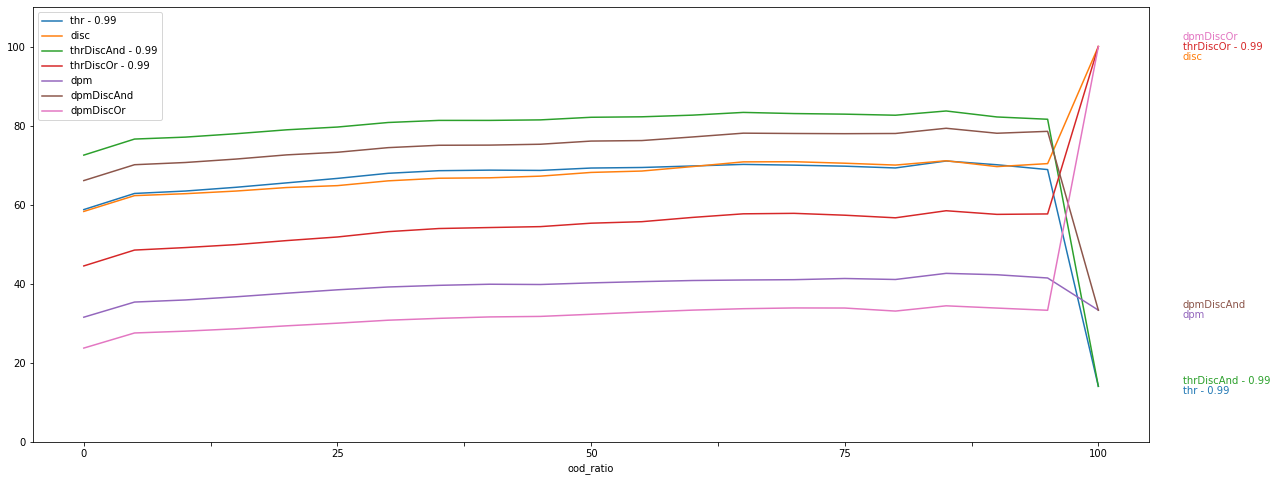

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  65.09  12.11
1               disc  68.68   7.96
2  thrDiscAnd - 0.99  77.51  14.82
3   thrDiscOr - 0.99  56.27  10.70
4                dpm  38.39   4.99
5         dpmDiscAnd  72.45  12.49
6          dpmDiscOr  34.63  15.22

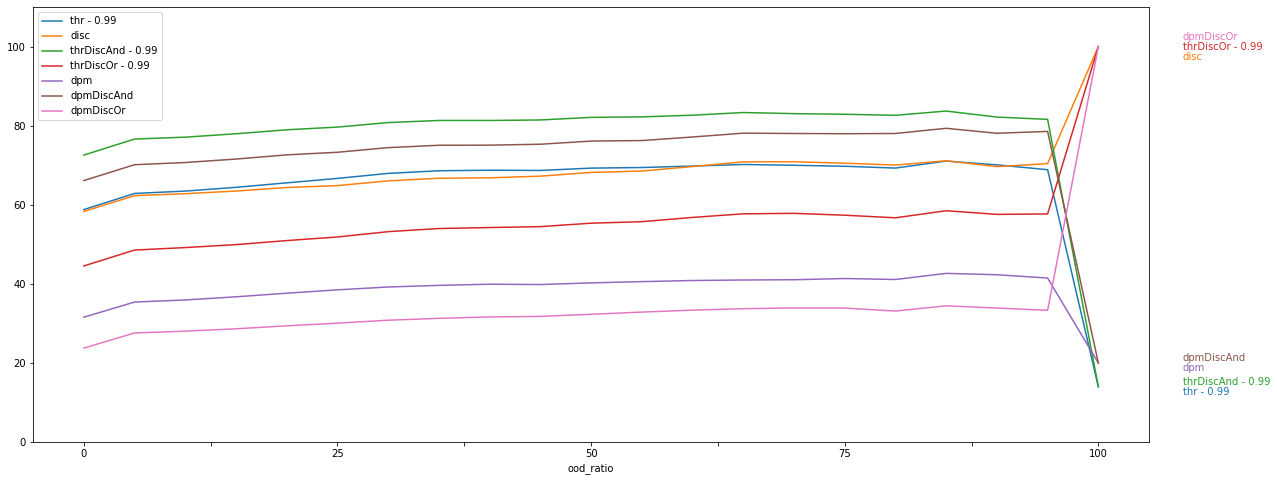

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  64.65  12.89
1               disc  68.68   7.96
2  thrDiscAnd - 0.99  77.07  15.61
3   thrDiscOr - 0.99  56.27  10.70
4                dpm  38.38   4.99
5         dpmDiscAnd  72.44  12.50
6          dpmDiscOr  34.63  15.22

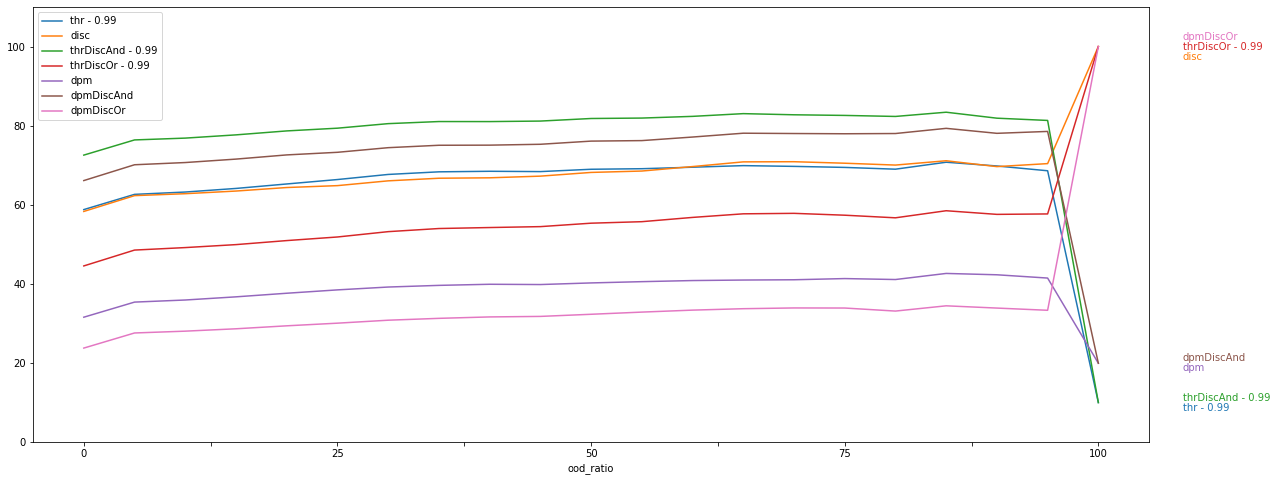

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  64.53  12.94
1               disc  68.68   7.96
2  thrDiscAnd - 0.99  76.95  15.66
3   thrDiscOr - 0.99  56.27  10.70
4                dpm  38.22   5.11
5         dpmDiscAnd  72.28  12.64
6          dpmDiscOr  34.63  15.22

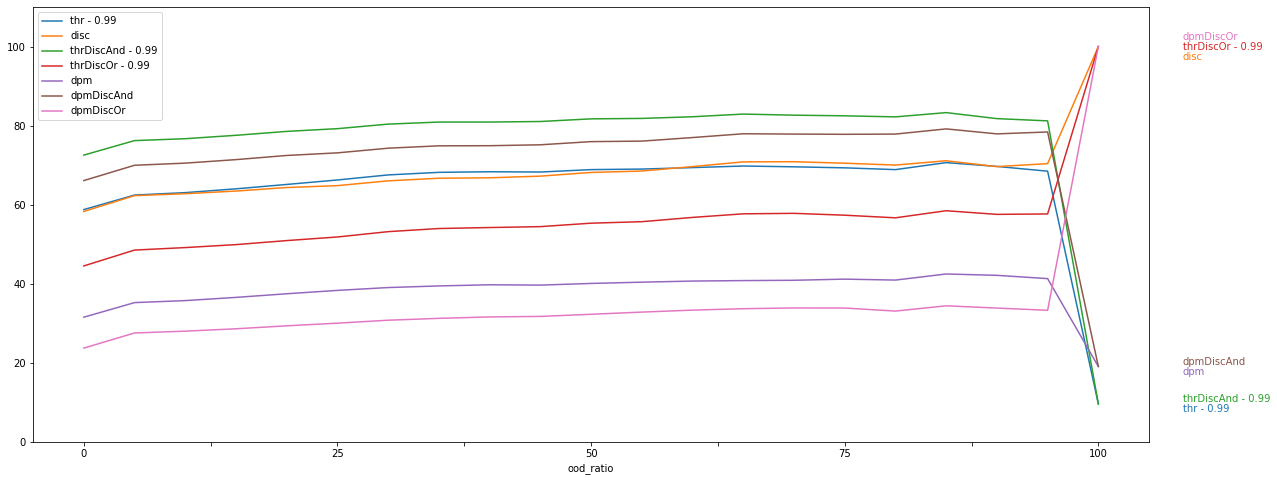

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  62.22  13.80
1               disc  68.68   7.96
2  thrDiscAnd - 0.99  74.63  16.55
3   thrDiscOr - 0.99  56.27  10.70
4                dpm  37.33   4.45
5         dpmDiscAnd  71.38  11.95
6          dpmDiscOr  34.63  15.22

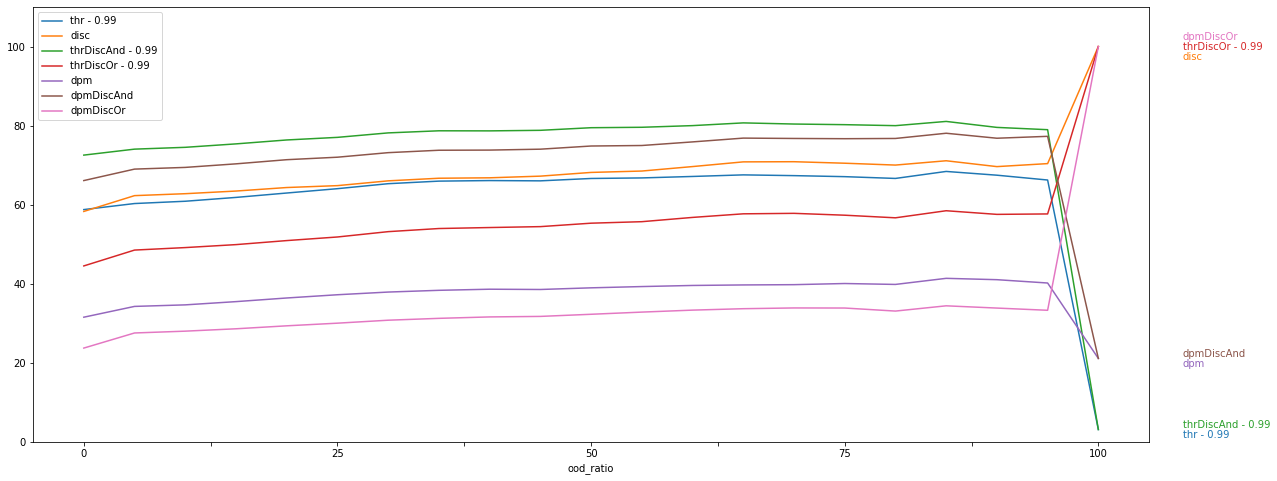

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  69.25   7.68
1               disc  68.68   7.96
2  thrDiscAnd - 0.99  81.67   5.02
3   thrDiscOr - 0.99  56.27  10.70
4                dpm  42.21  13.50
5         dpmDiscAnd  76.27   6.40
6          dpmDiscOr  34.63  15.22

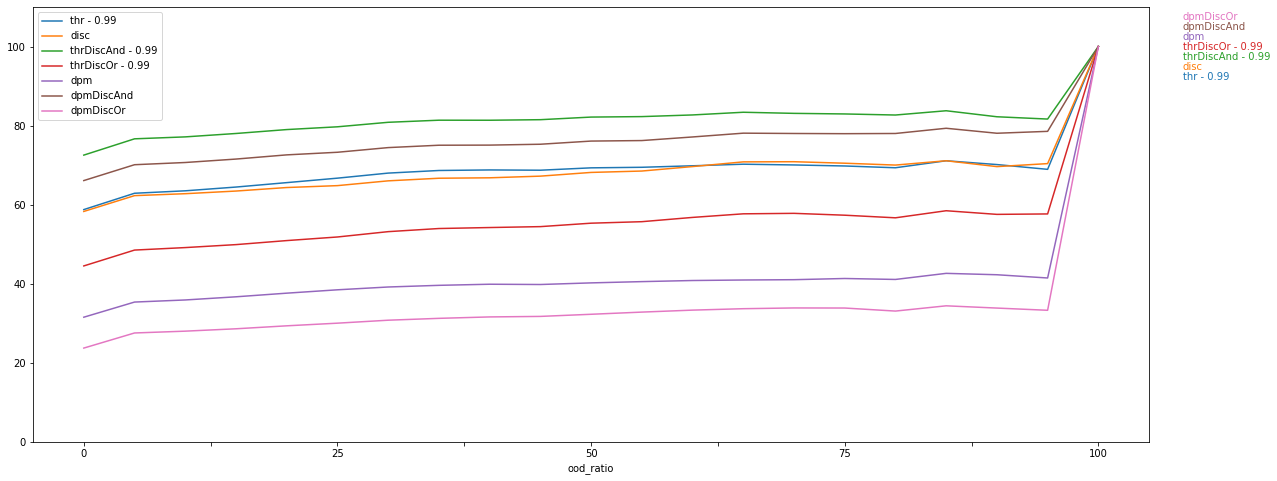

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot weighted Recall vs. ratio

In [ ]:
y = 'R_weighted'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  81.98  11.46
1               disc  82.25  12.31
2  thrDiscAnd - 0.99  88.80   7.10
3   thrDiscOr - 0.99  75.43  16.69
4                dpm  68.07  20.74
5         dpmDiscAnd  86.36   9.71
6          dpmDiscOr  63.97  23.36

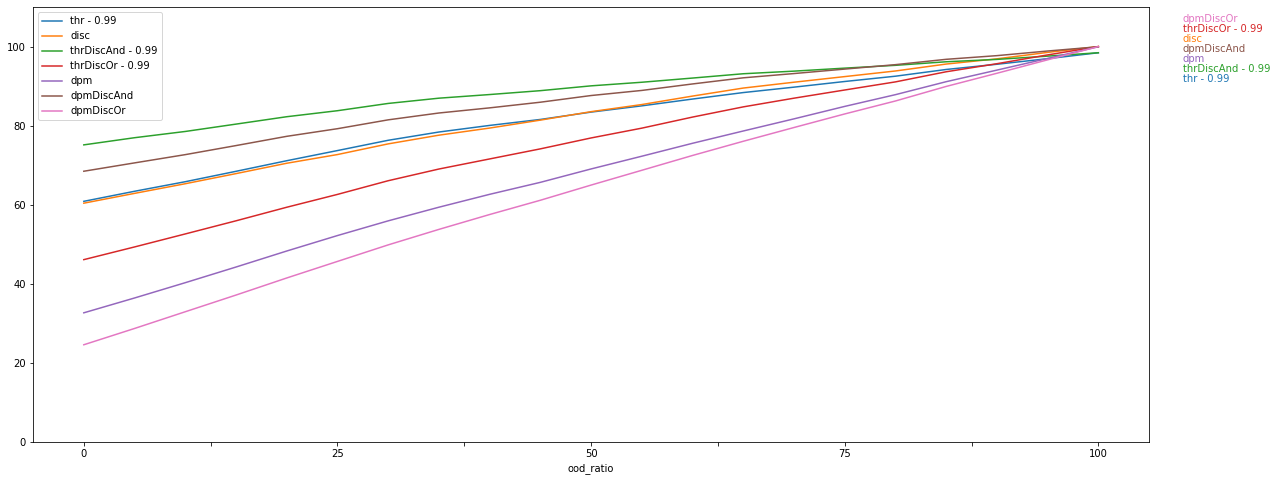

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  81.66  11.21
1               disc  82.25  12.31
2  thrDiscAnd - 0.99  88.49   6.85
3   thrDiscOr - 0.99  75.43  16.69
4                dpm  68.01  20.69
5         dpmDiscAnd  86.30   9.66
6          dpmDiscOr  63.97  23.36

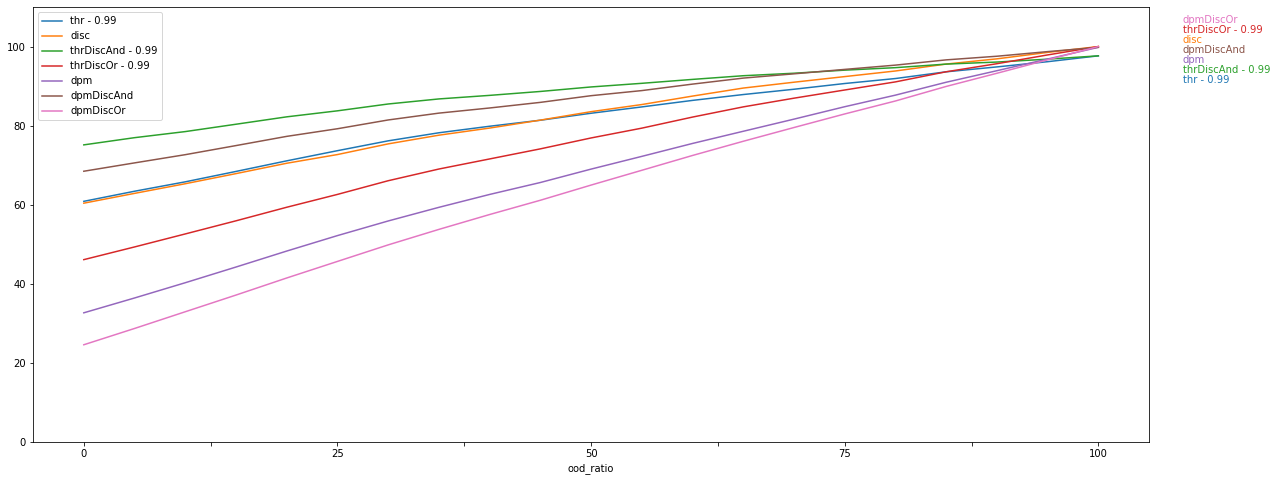

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  77.55   8.67
1               disc  82.26  12.31
2  thrDiscAnd - 0.99  84.38   4.34
3   thrDiscOr - 0.99  75.44  16.69
4                dpm  67.88  20.59
5         dpmDiscAnd  86.17   9.57
6          dpmDiscOr  63.98  23.35

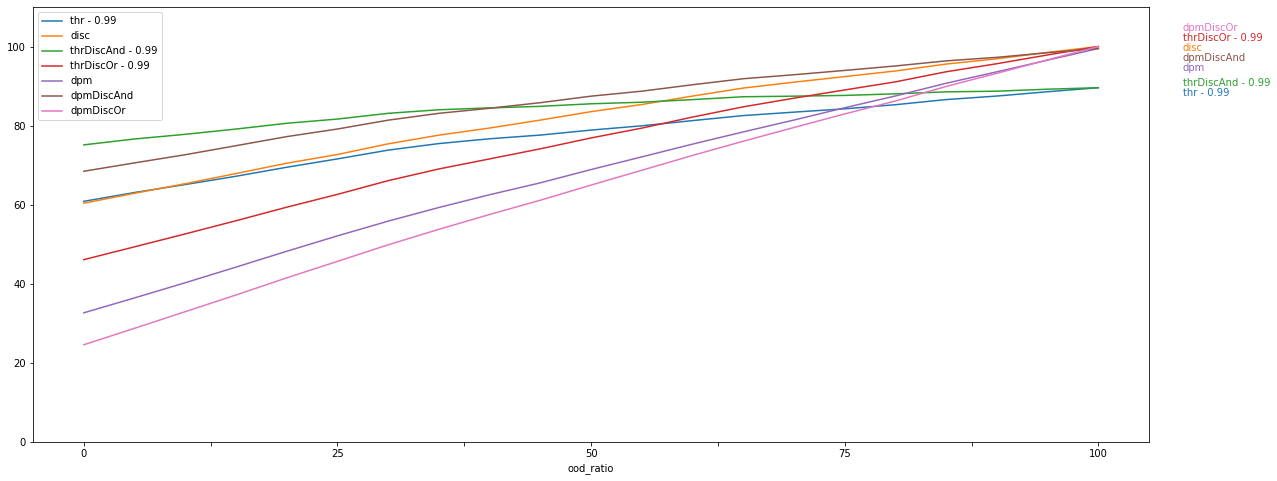

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  76.00   7.74
1               disc  82.26  12.31
2  thrDiscAnd - 0.99  82.82   3.46
3   thrDiscOr - 0.99  75.44  16.69
4                dpm  65.90  19.34
5         dpmDiscAnd  84.18   8.33
6          dpmDiscOr  63.98  23.35

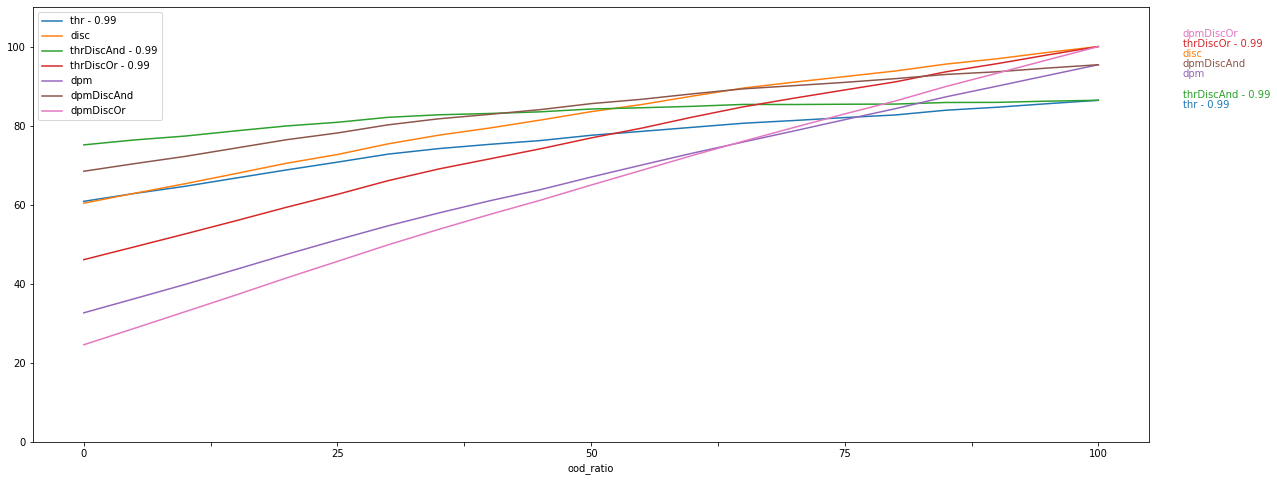

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  43.67  12.60
1               disc  82.26  12.31
2  thrDiscAnd - 0.99  50.49  16.93
3   thrDiscOr - 0.99  75.44  16.69
4                dpm  49.86   9.38
5         dpmDiscAnd  68.14   2.15
6          dpmDiscOr  63.98  23.35

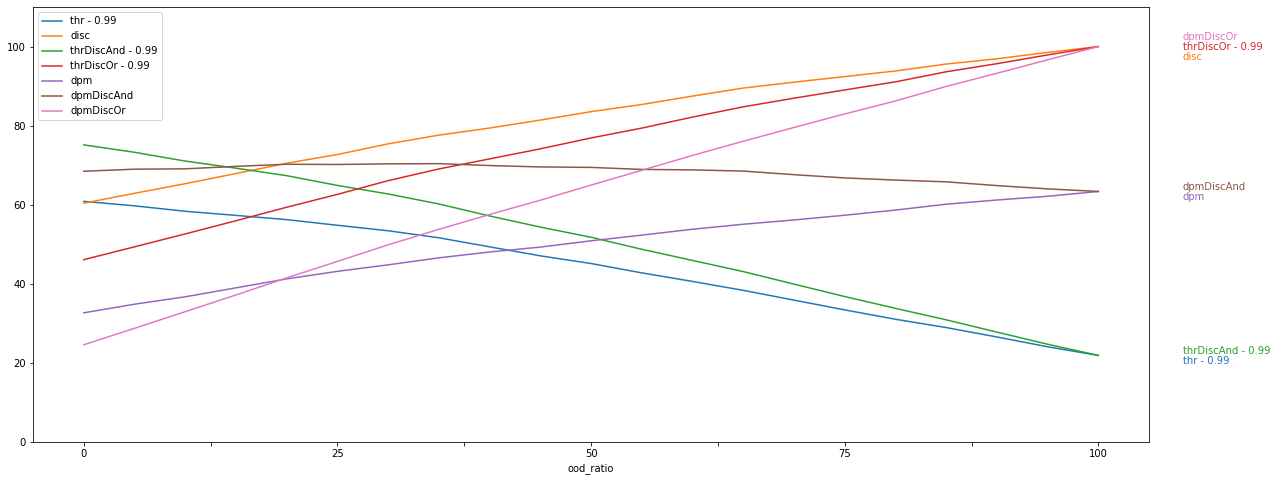

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  82.74  11.92
1               disc  82.26  12.31
2  thrDiscAnd - 0.99  89.56   7.55
3   thrDiscOr - 0.99  75.44  16.69
4                dpm  68.10  20.75
5         dpmDiscAnd  86.39   9.72
6          dpmDiscOr  63.98  23.35

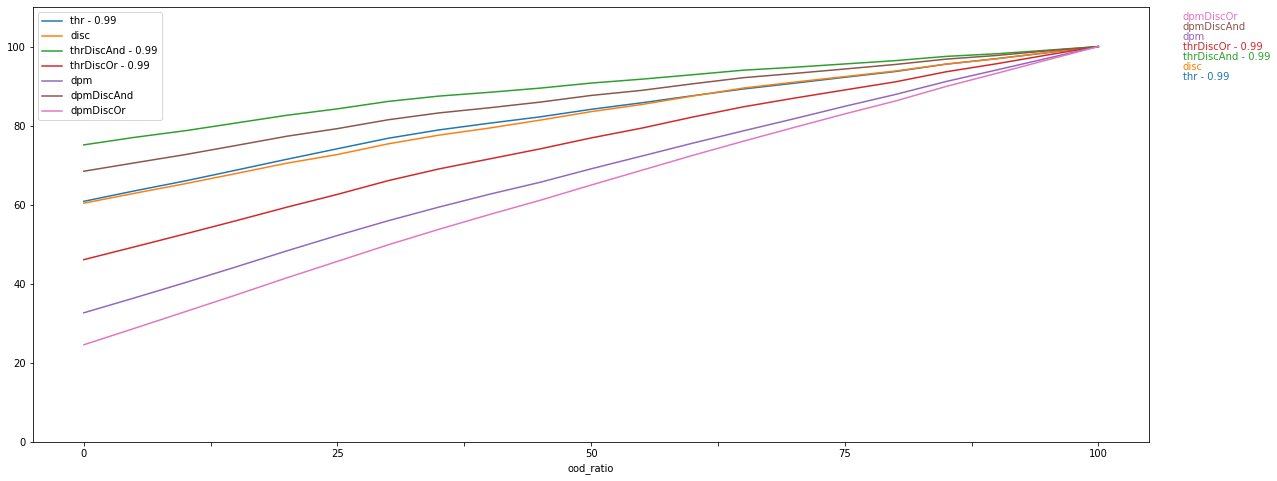

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot macro F1 vs. ratio

In [ ]:
y = 'F1_macro'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  73.80  13.90
1               disc  75.50   6.58
2  thrDiscAnd - 0.99  79.29  15.11
3   thrDiscOr - 0.99  68.52   8.23
4                dpm  49.71   4.95
5         dpmDiscAnd  77.85  10.67
6          dpmDiscOr  45.16  13.06

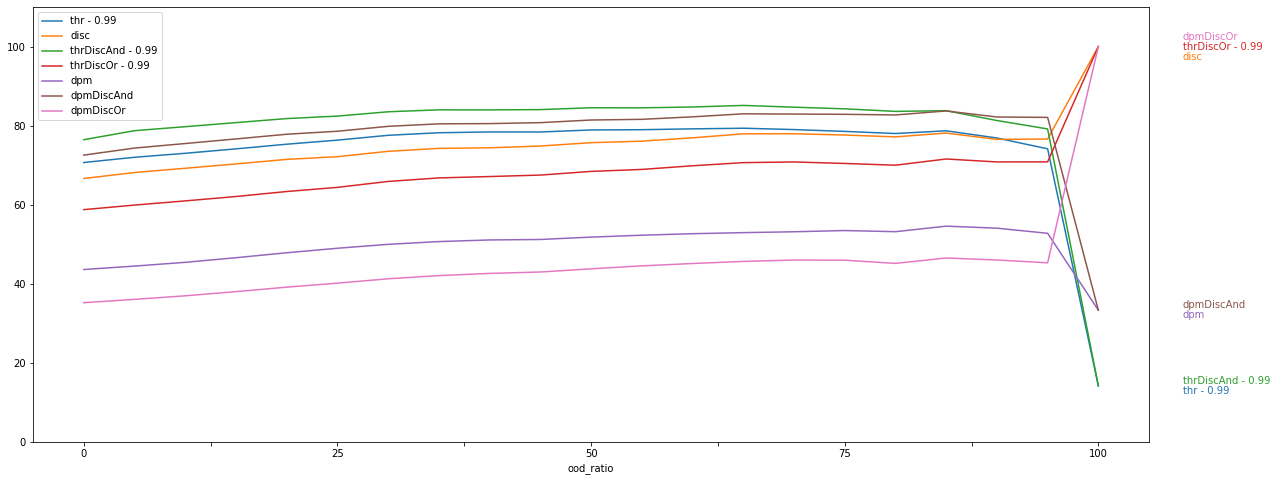

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  73.40  13.82
1               disc  75.50   6.58
2  thrDiscAnd - 0.99  78.88  15.04
3   thrDiscOr - 0.99  68.52   8.23
4                dpm  48.93   7.33
5         dpmDiscAnd  77.07  13.42
6          dpmDiscOr  45.16  13.06

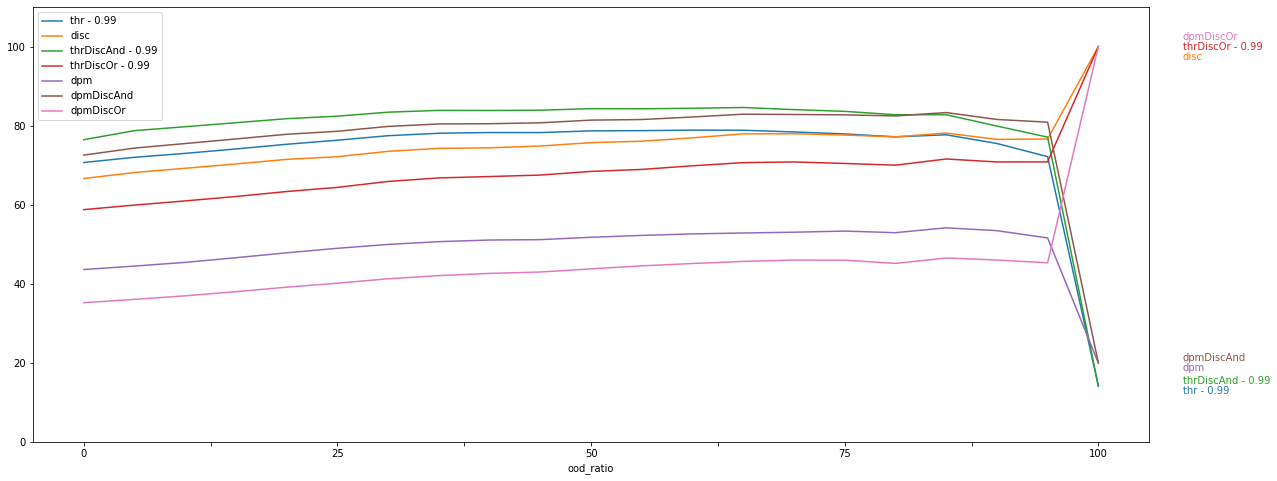

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  72.31  14.32
1               disc  75.50   6.58
2  thrDiscAnd - 0.99  77.77  15.54
3   thrDiscOr - 0.99  68.52   8.23
4                dpm  48.85   7.29
5         dpmDiscAnd  76.91  13.37
6          dpmDiscOr  45.16  13.06

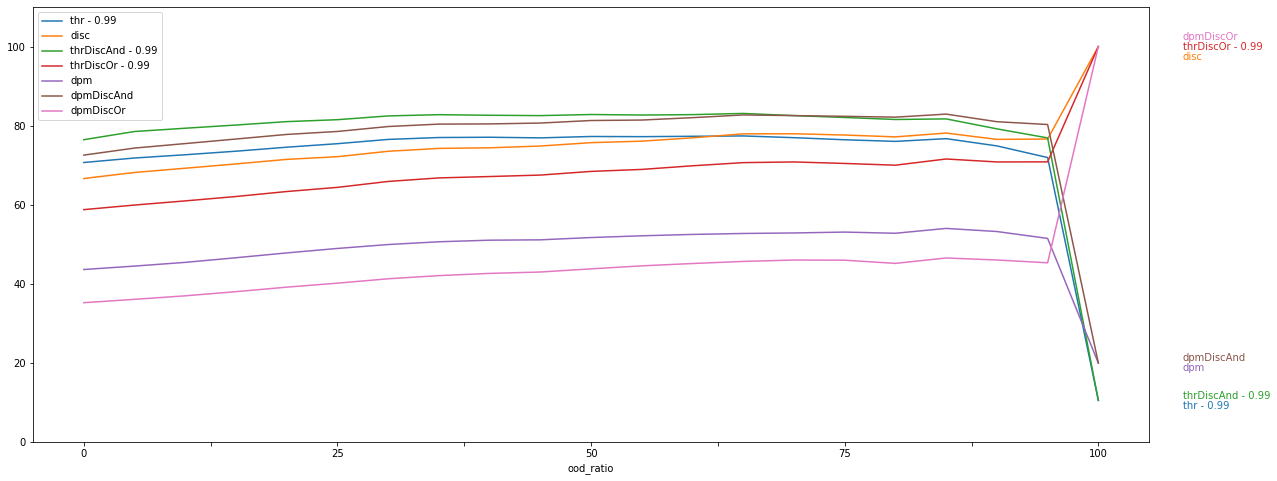

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  71.86  14.24
1               disc  75.50   6.58
2  thrDiscAnd - 0.99  77.27  15.47
3   thrDiscOr - 0.99  68.52   8.23
4                dpm  48.01   7.02
5         dpmDiscAnd  76.02  13.17
6          dpmDiscOr  45.16  13.06

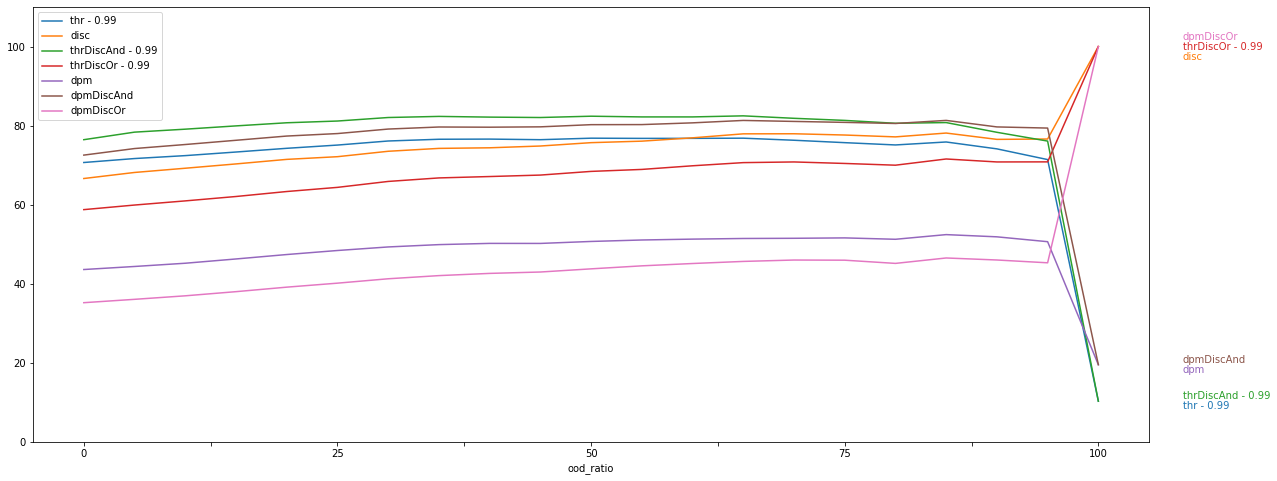

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  70.08  14.97
1               disc  75.50   6.58
2  thrDiscAnd - 0.99  75.35  16.15
3   thrDiscOr - 0.99  68.52   8.23
4                dpm  47.37   5.54
5         dpmDiscAnd  74.92  11.46
6          dpmDiscOr  45.16  13.06

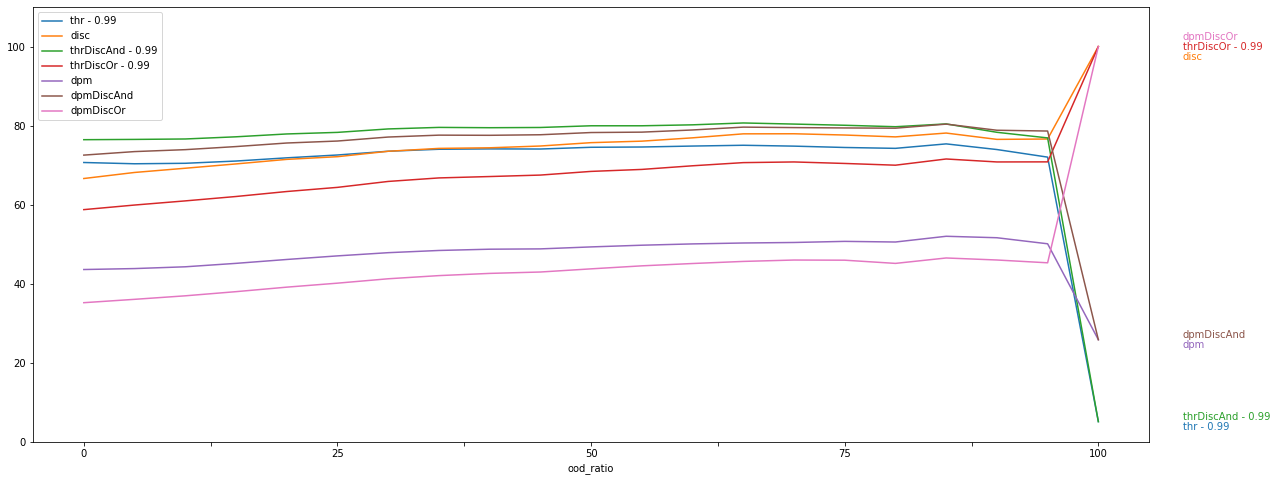

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  78.91   5.70
1               disc  75.50   6.58
2  thrDiscAnd - 0.99  84.39   4.44
3   thrDiscOr - 0.99  68.52   8.23
4                dpm  52.94  11.27
5         dpmDiscAnd  81.08   5.36
6          dpmDiscOr  45.16  13.06

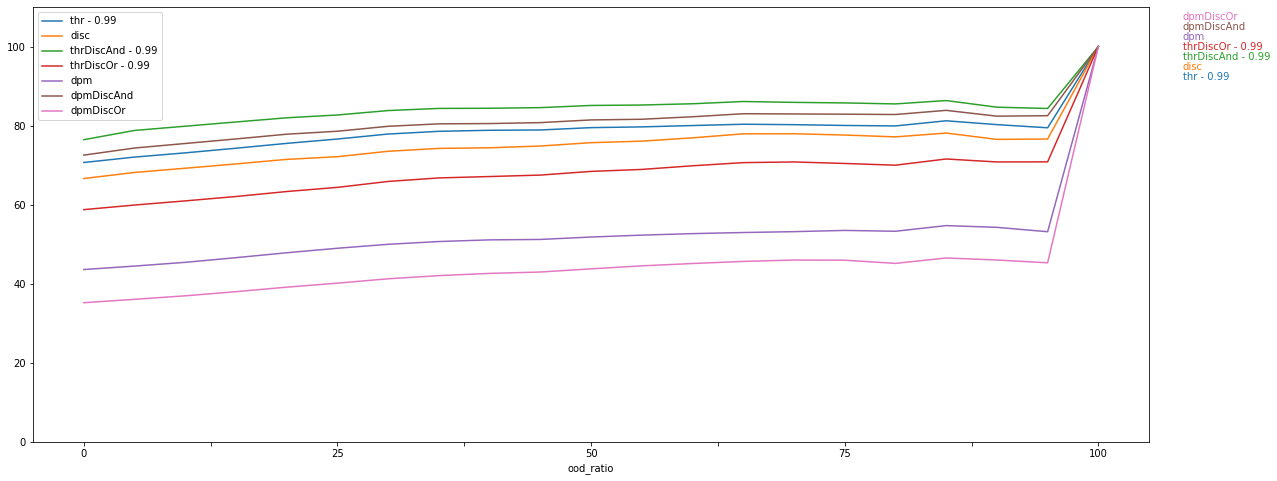

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot weighted F1 vs. ratio

In [ ]:
y = 'F1_weighted'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  83.19   9.33
1               disc  82.51  11.00
2  thrDiscAnd - 0.99  89.07   6.75
3   thrDiscOr - 0.99  76.29  13.86
4                dpm  66.47  18.67
5         dpmDiscAnd  86.64   8.76
6          dpmDiscOr  61.54  21.45

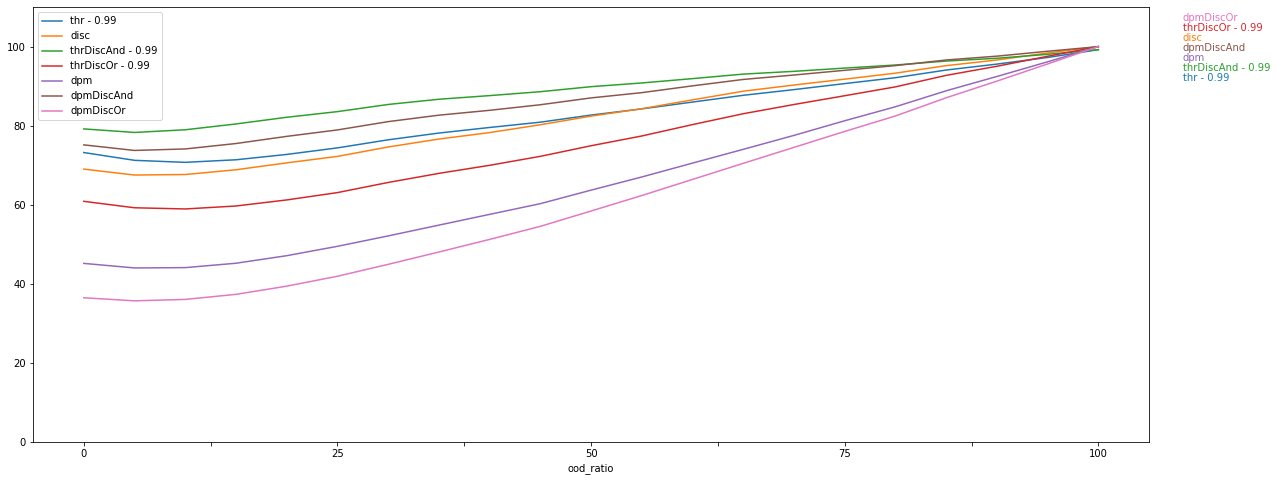

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  82.94   9.15
1               disc  82.51  11.00
2  thrDiscAnd - 0.99  88.82   6.57
3   thrDiscOr - 0.99  76.29  13.86
4                dpm  66.42  18.63
5         dpmDiscAnd  86.59   8.72
6          dpmDiscOr  61.54  21.45

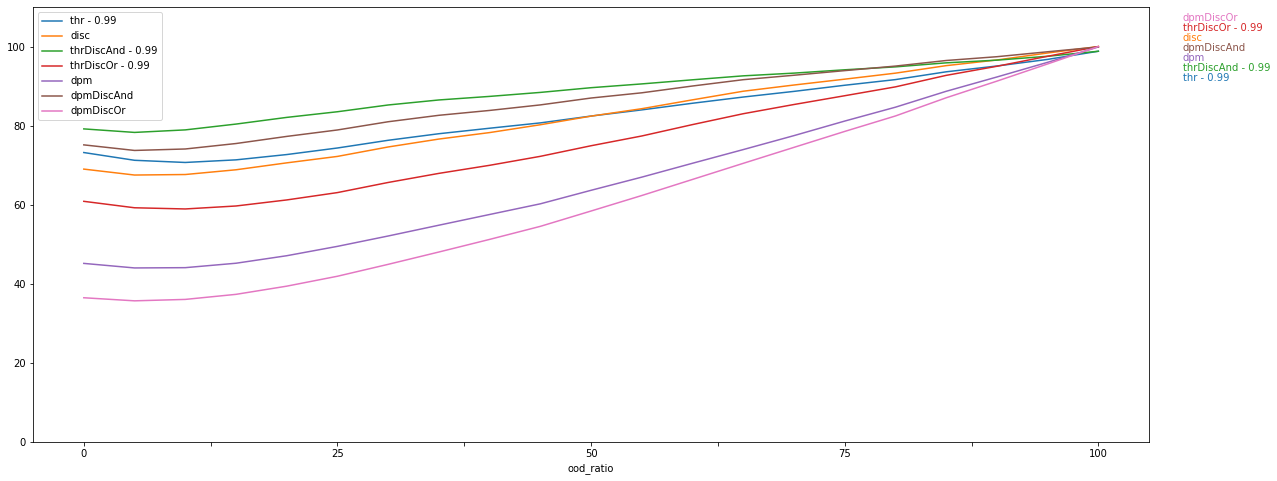

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  80.43   7.87
1               disc  82.51  11.00
2  thrDiscAnd - 0.99  86.26   5.25
3   thrDiscOr - 0.99  76.30  13.86
4                dpm  66.33  18.57
5         dpmDiscAnd  86.48   8.66
6          dpmDiscOr  61.55  21.45

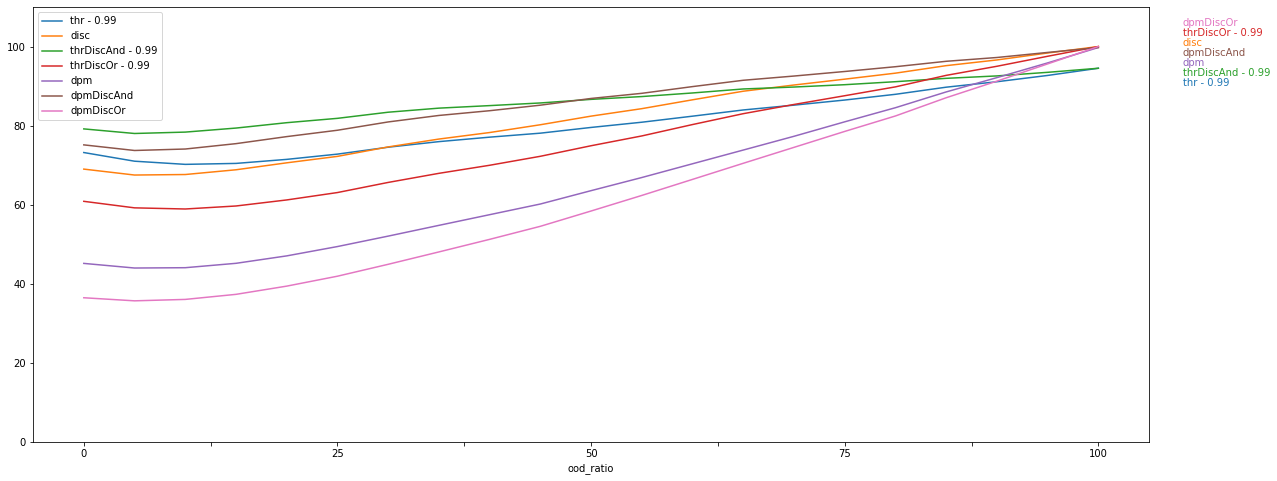

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  79.42   7.34
1               disc  82.51  11.00
2  thrDiscAnd - 0.99  85.22   4.72
3   thrDiscOr - 0.99  76.30  13.86
4                dpm  65.07  17.92
5         dpmDiscAnd  85.16   8.00
6          dpmDiscOr  61.55  21.45

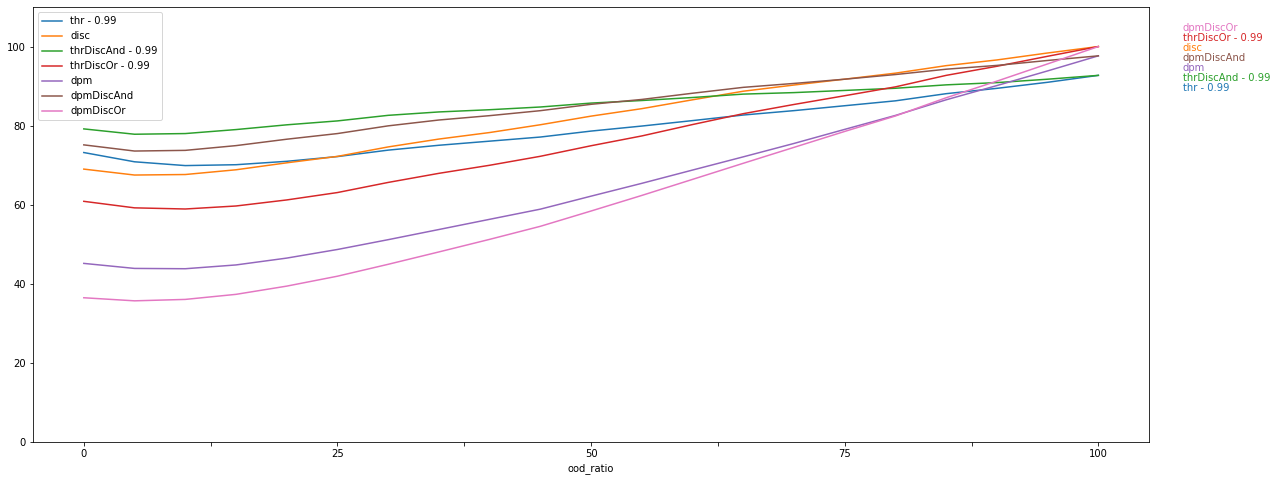

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  52.83  11.00
1               disc  82.51  11.00
2  thrDiscAnd - 0.99  57.20  13.07
3   thrDiscOr - 0.99  76.30  13.86
4                dpm  55.56  11.62
5         dpmDiscAnd  74.87   2.03
6          dpmDiscOr  61.55  21.45

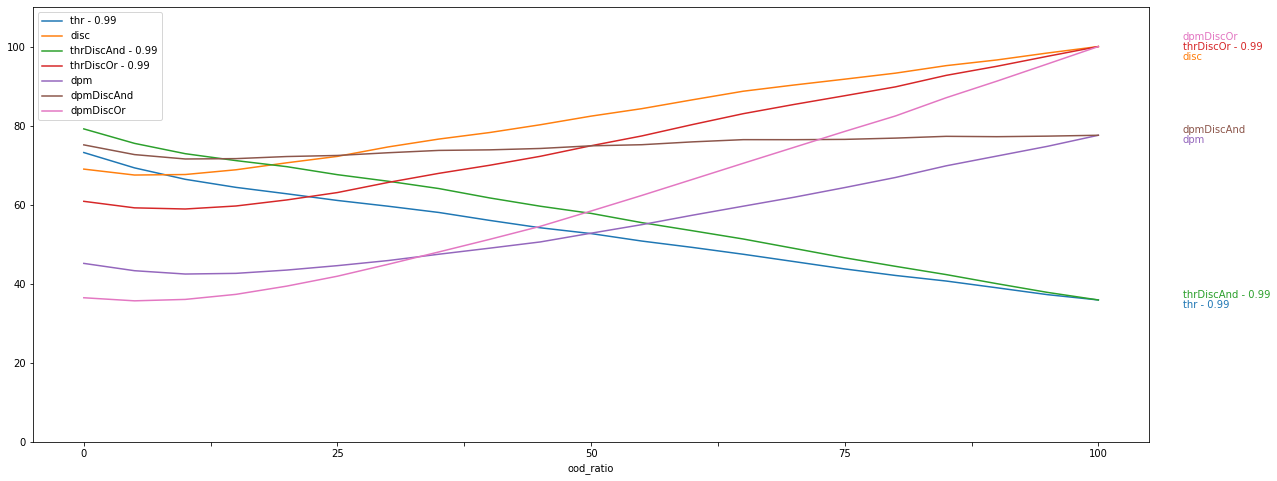

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  83.80   9.64
1               disc  82.51  11.00
2  thrDiscAnd - 0.99  89.69   7.07
3   thrDiscOr - 0.99  76.30  13.86
4                dpm  66.49  18.68
5         dpmDiscAnd  86.66   8.78
6          dpmDiscOr  61.55  21.45

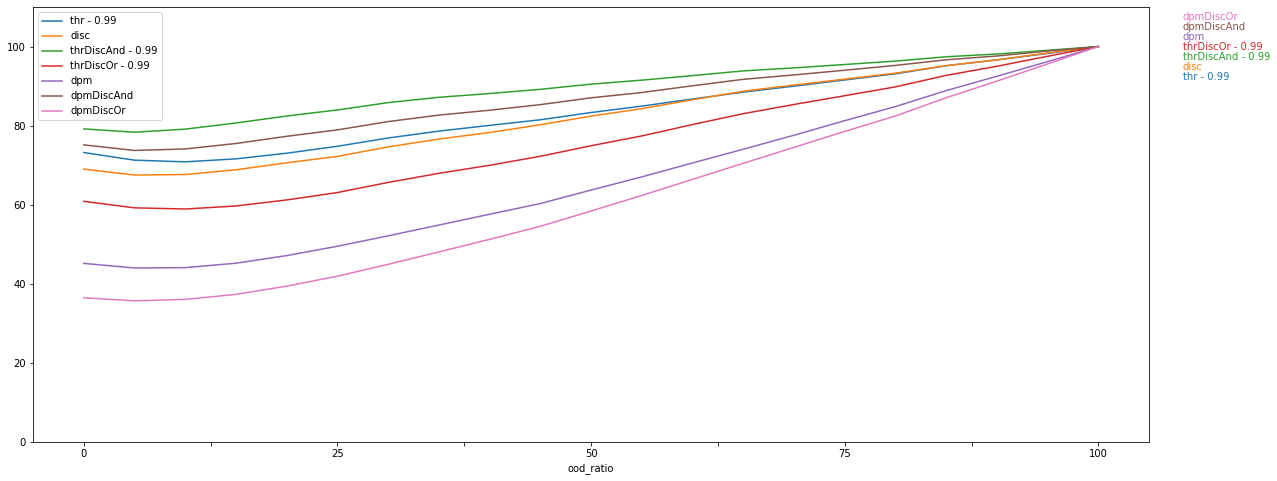

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot Acc vs. ratio (binary)

In [ ]:
y = 'acc_bin'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  83.72  10.19
1               disc  87.74   8.43
2  thrDiscAnd - 0.99  94.89   2.75
3   thrDiscOr - 0.99  76.58  15.87
4                dpm  68.17  20.66
5         dpmDiscAnd  91.87   5.80
6          dpmDiscOr  64.05  23.30

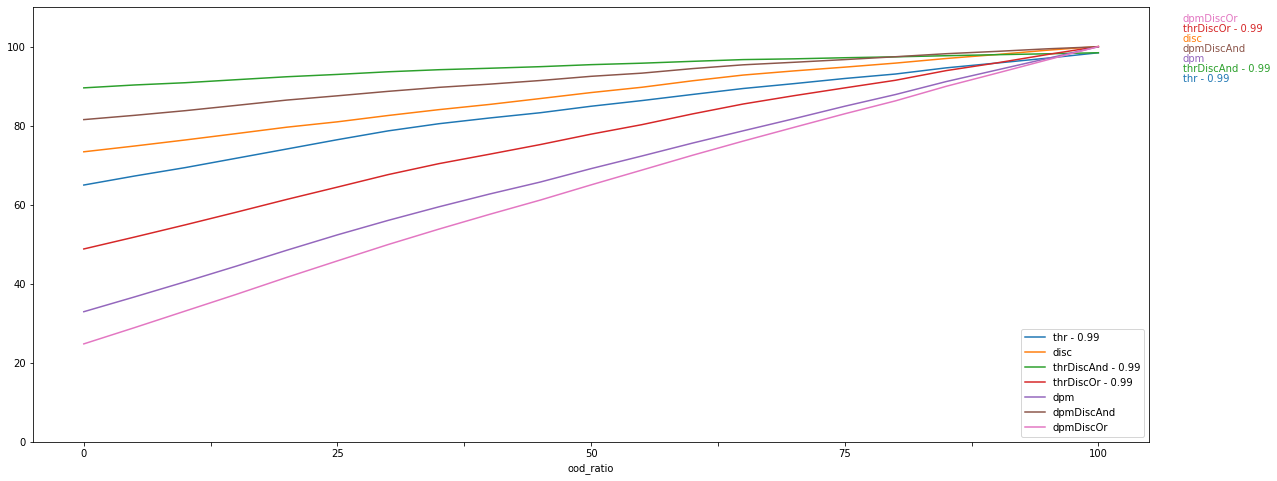

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  83.41   9.94
1               disc  87.74   8.43
2  thrDiscAnd - 0.99  94.57   2.50
3   thrDiscOr - 0.99  76.58  15.87
4                dpm  68.12  20.61
5         dpmDiscAnd  91.81   5.75
6          dpmDiscOr  64.05  23.30

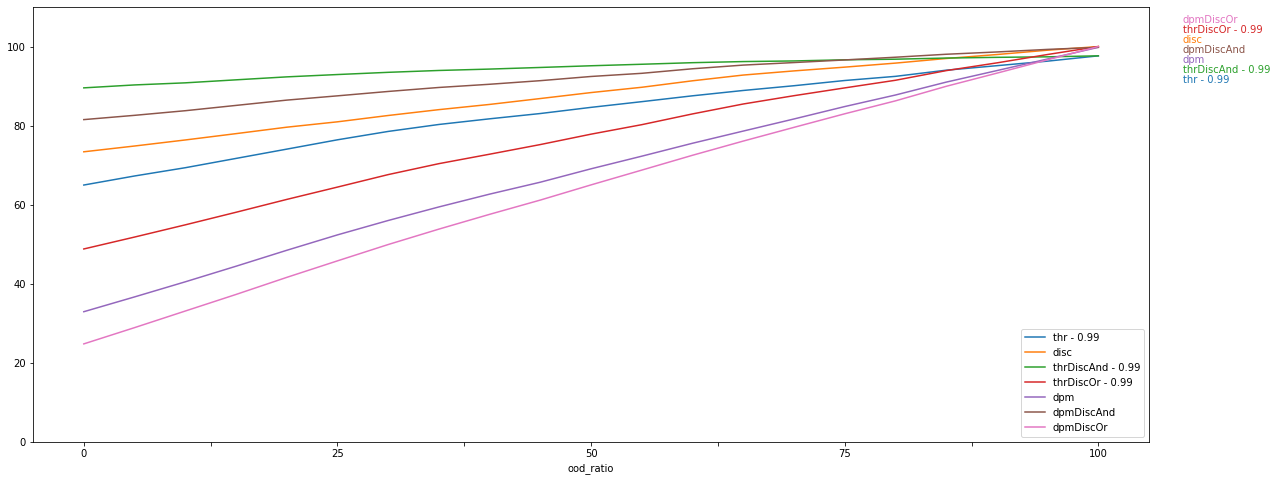

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  79.30   7.39
1               disc  87.75   8.43
2  thrDiscAnd - 0.99  90.46   0.52
3   thrDiscOr - 0.99  76.59  15.86
4                dpm  67.99  20.51
5         dpmDiscAnd  91.68   5.65
6          dpmDiscOr  64.06  23.29

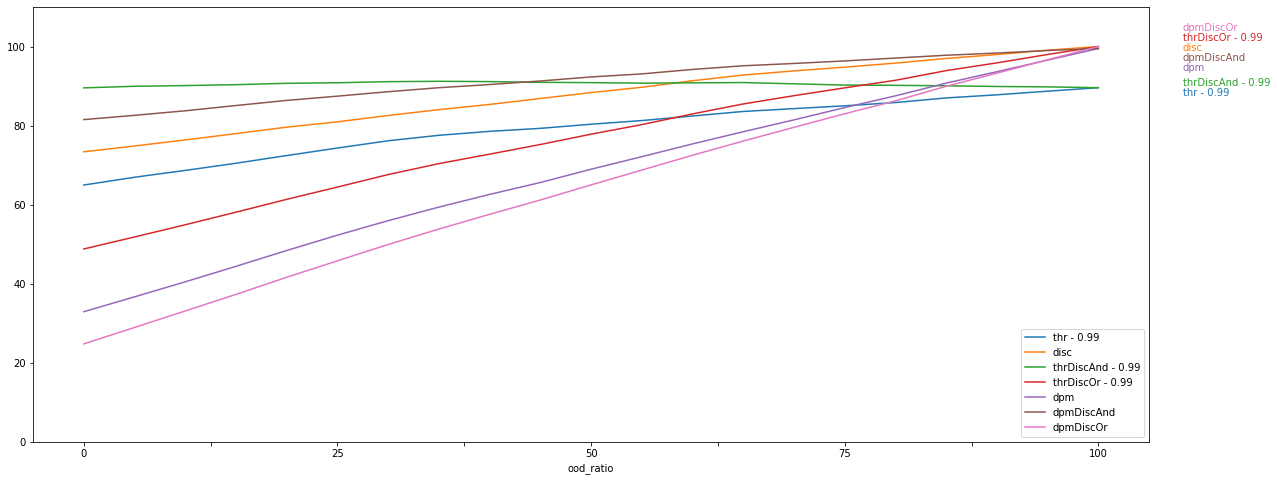

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  77.74   6.47
1               disc  87.75   8.43
2  thrDiscAnd - 0.99  88.90   1.19
3   thrDiscOr - 0.99  76.59  15.86
4                dpm  66.00  19.25
5         dpmDiscAnd  89.69   4.41
6          dpmDiscOr  64.06  23.29

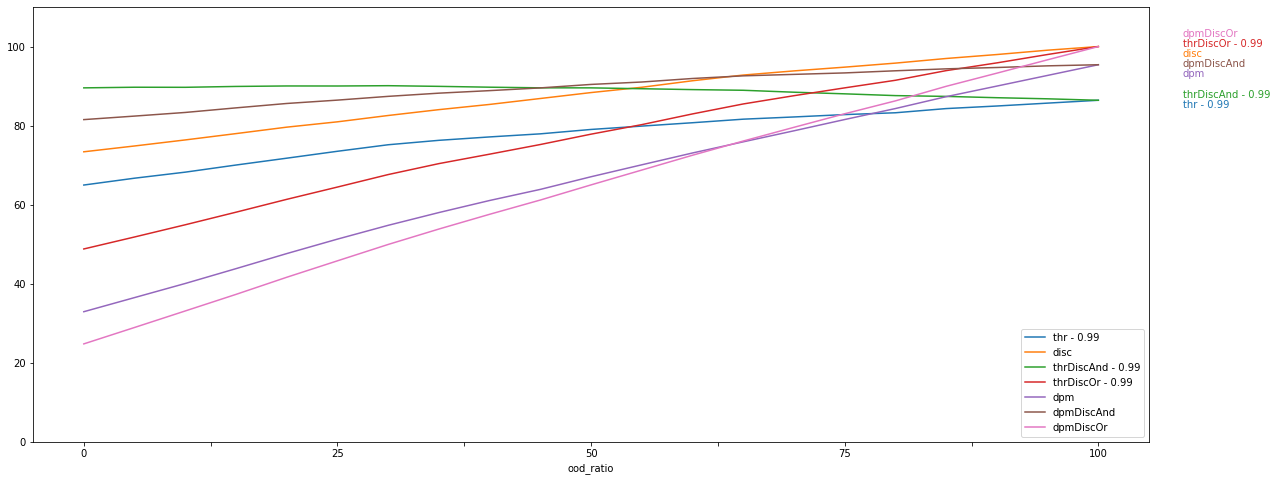

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  45.42  13.83
1               disc  87.75   8.43
2  thrDiscAnd - 0.99  56.57  21.19
3   thrDiscOr - 0.99  76.59  15.86
4                dpm  49.96   9.30
5         dpmDiscAnd  73.65   5.66
6          dpmDiscOr  64.06  23.29

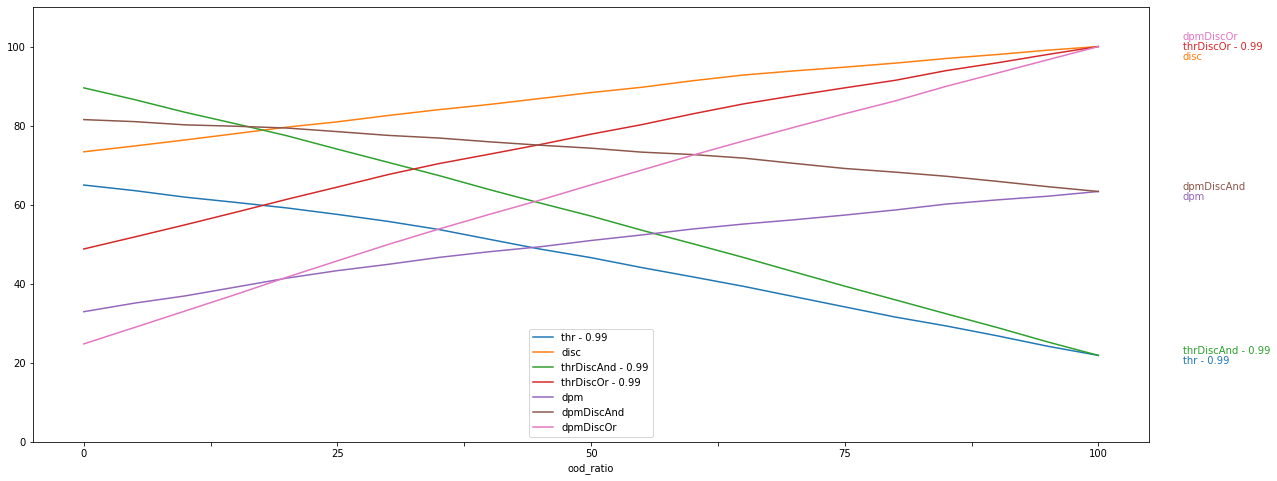

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  84.49  10.65
1               disc  87.75   8.43
2  thrDiscAnd - 0.99  95.64   3.21
3   thrDiscOr - 0.99  76.59  15.86
4                dpm  68.21  20.67
5         dpmDiscAnd  91.89   5.81
6          dpmDiscOr  64.06  23.29

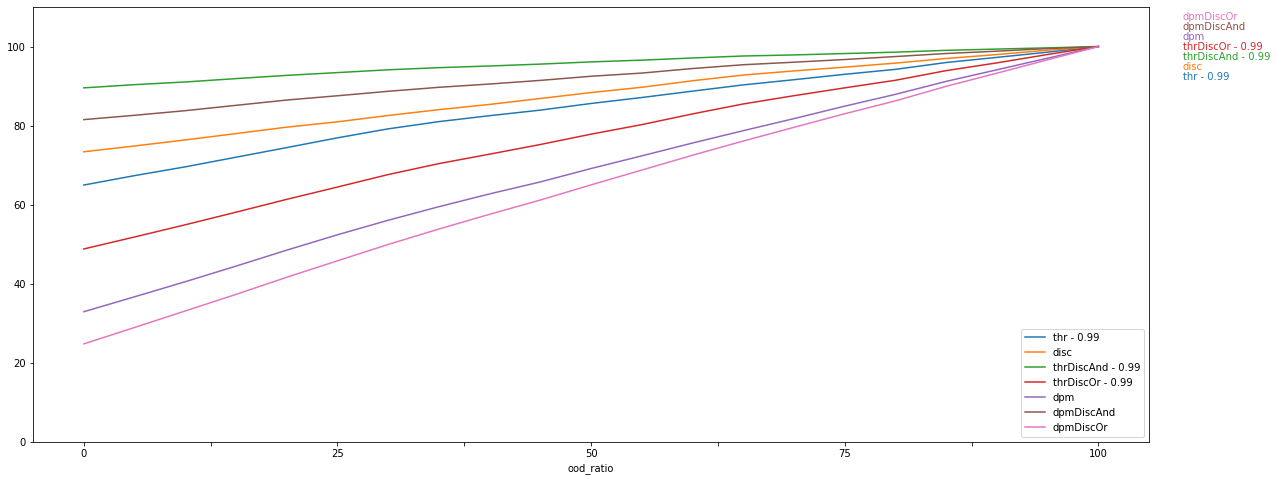

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot balanced Acc vs. ratio (binary)

In [ ]:
y = 'acc_balanced_bin'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  84.12   5.45
1               disc  88.30   4.39
2  thrDiscAnd - 0.99  95.13   1.57
3   thrDiscOr - 0.99  77.29   8.29
4                dpm  68.62  10.67
5         dpmDiscAnd  92.40   3.15
6          dpmDiscOr  64.52  11.96

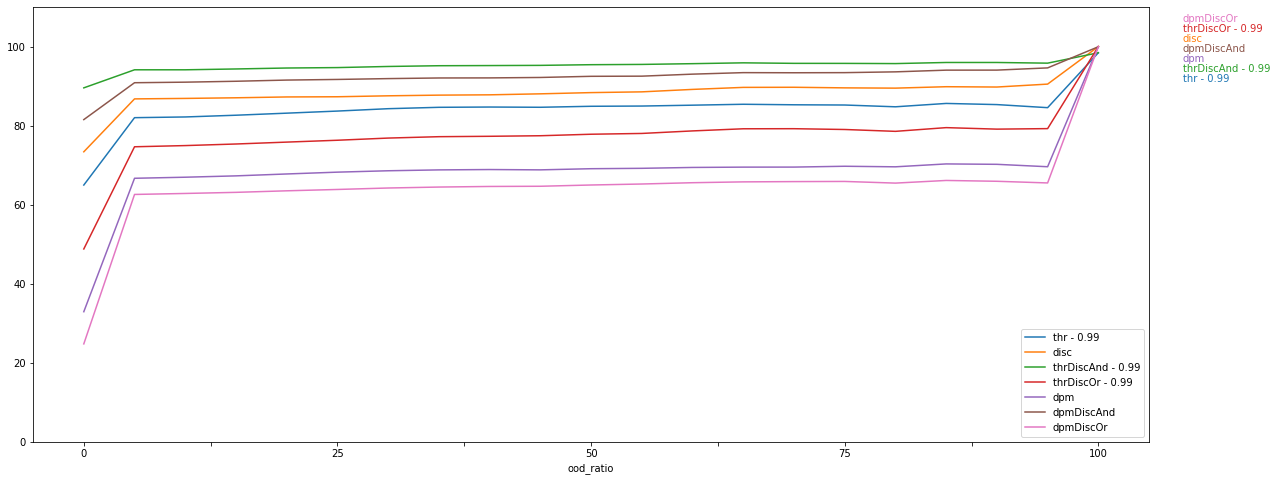

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  83.86   5.32
1               disc  88.30   4.39
2  thrDiscAnd - 0.99  94.87   1.43
3   thrDiscOr - 0.99  77.29   8.29
4                dpm  68.57  10.64
5         dpmDiscAnd  92.35   3.12
6          dpmDiscOr  64.52  11.96

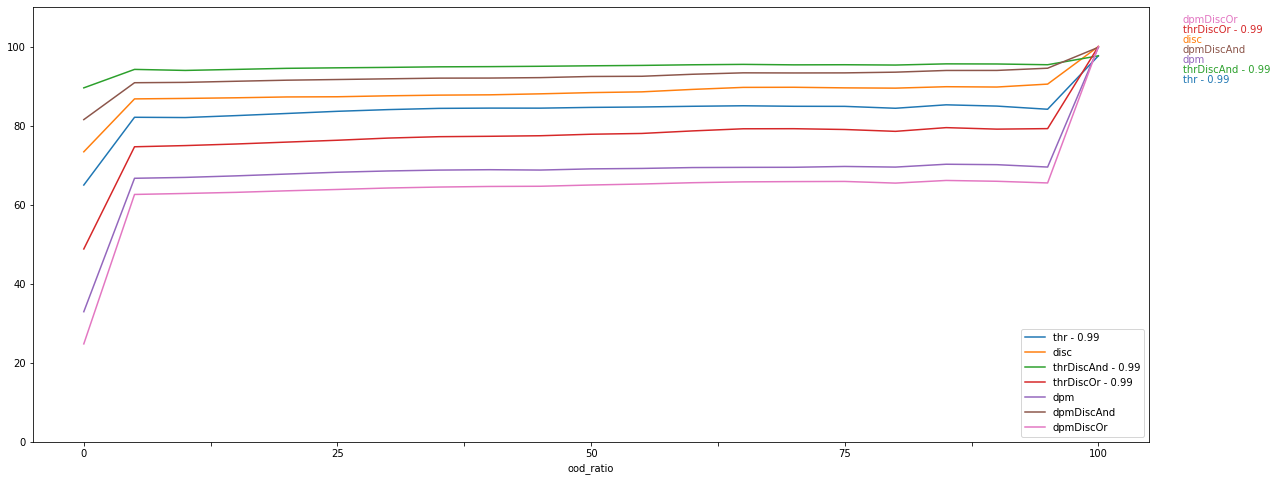

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  79.81   4.06
1               disc  88.30   4.39
2  thrDiscAnd - 0.99  90.83   0.55
3   thrDiscOr - 0.99  77.29   8.29
4                dpm  68.44  10.60
5         dpmDiscAnd  92.22   3.07
6          dpmDiscOr  64.52  11.96

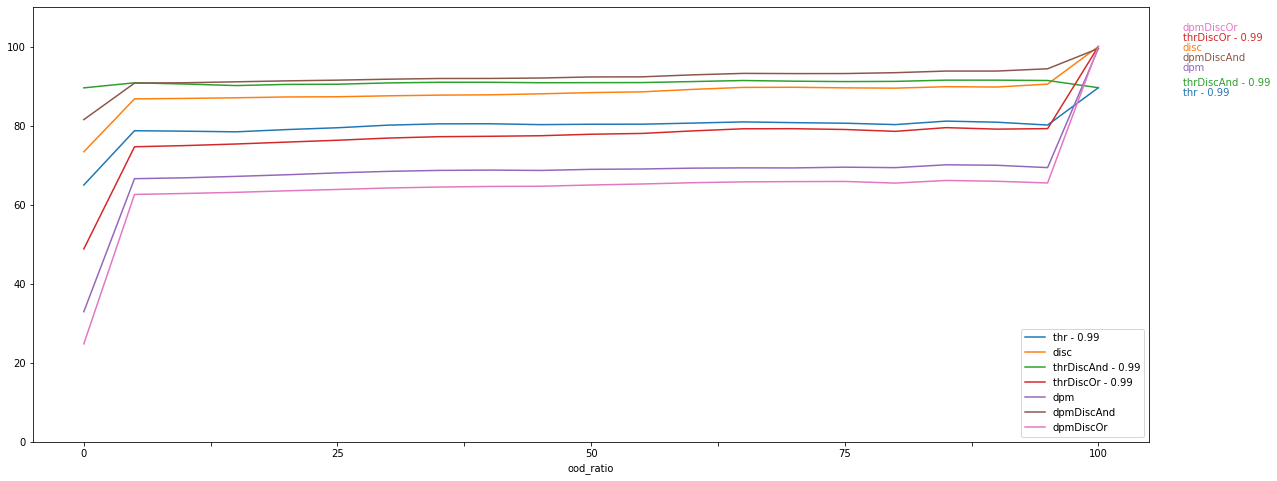

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  78.18   3.62
1               disc  88.30   4.39
2  thrDiscAnd - 0.99  89.20   0.81
3   thrDiscOr - 0.99  77.29   8.29
4                dpm  66.46   9.95
5         dpmDiscAnd  90.24   2.49
6          dpmDiscOr  64.52  11.96

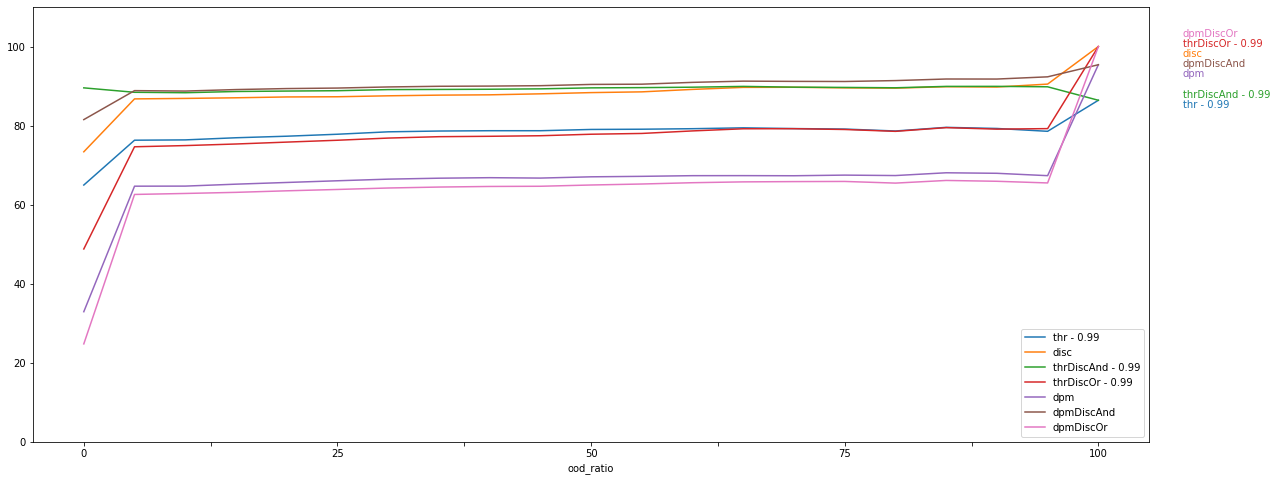

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  46.04   6.90
1               disc  88.30   4.39
2  thrDiscAnd - 0.99  57.05  10.71
3   thrDiscOr - 0.99  77.29   8.29
4                dpm  50.56   4.93
5         dpmDiscAnd  74.34   3.07
6          dpmDiscOr  64.52  11.96

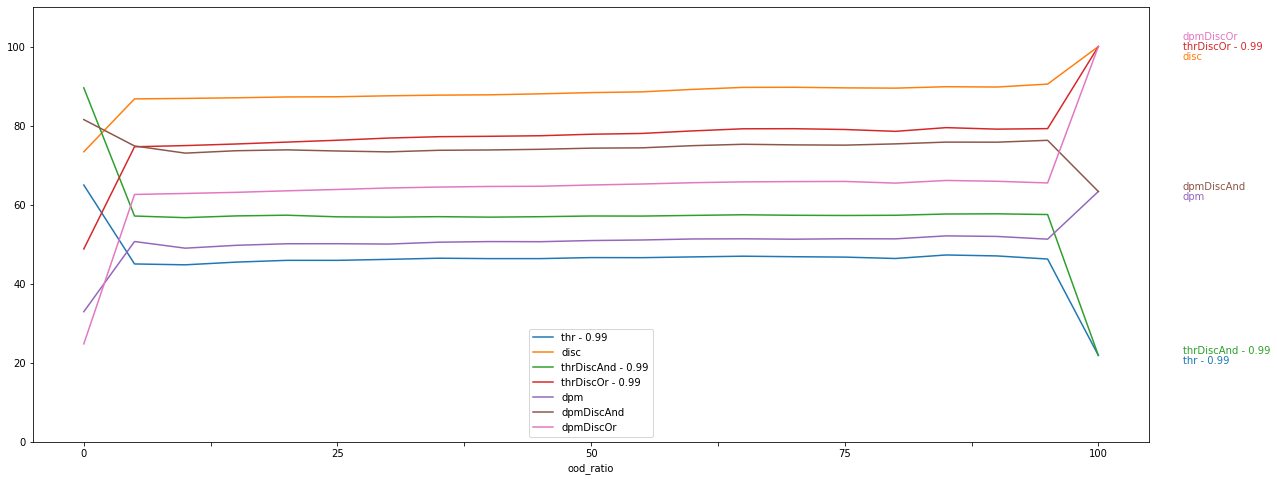

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  84.89   5.68
1               disc  88.30   4.39
2  thrDiscAnd - 0.99  95.90   1.78
3   thrDiscOr - 0.99  77.29   8.29
4                dpm  68.64  10.68
5         dpmDiscAnd  92.42   3.15
6          dpmDiscOr  64.52  11.96

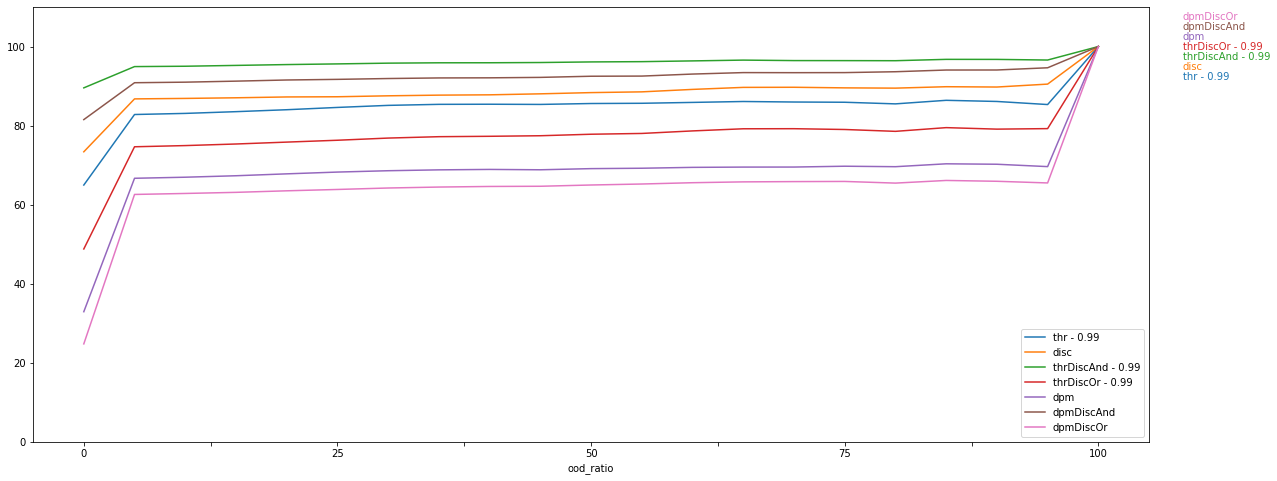

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot macro Precision vs. ratio (binary)

In [ ]:
y = 'P_macro_bin'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  79.34  14.37
1               disc  85.53  14.52
2  thrDiscAnd - 0.99  86.81  14.45
3   thrDiscOr - 0.99  81.14  15.39
4                dpm  76.19  15.73
5         dpmDiscAnd  85.55  15.79
6          dpmDiscOr  77.77  15.59

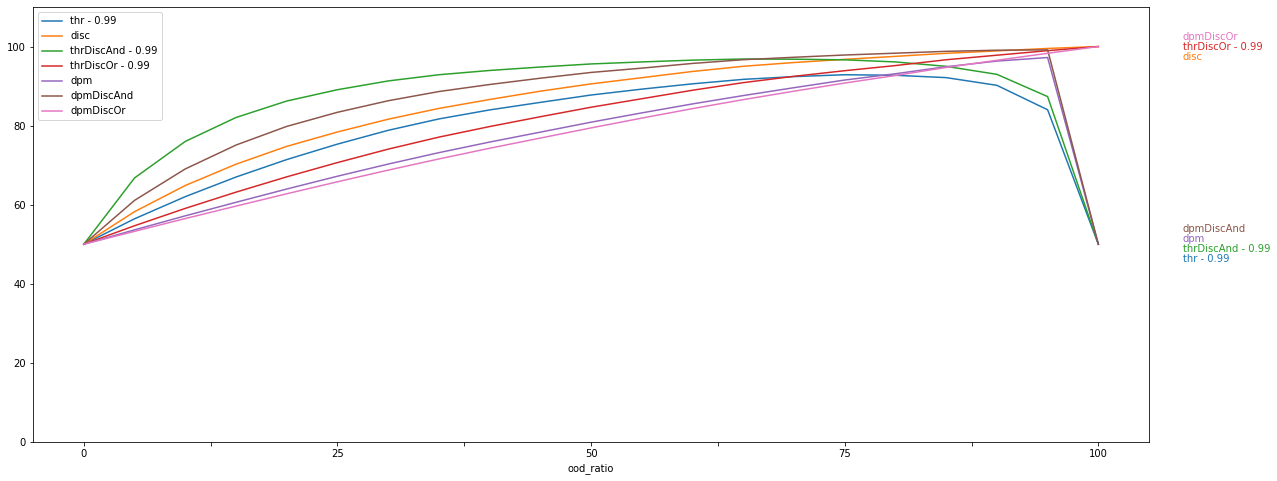

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  78.50  13.84
1               disc  85.53  14.52
2  thrDiscAnd - 0.99  86.12  14.19
3   thrDiscOr - 0.99  81.14  15.39
4                dpm  75.77  15.25
5         dpmDiscAnd  85.35  15.63
6          dpmDiscOr  77.77  15.59

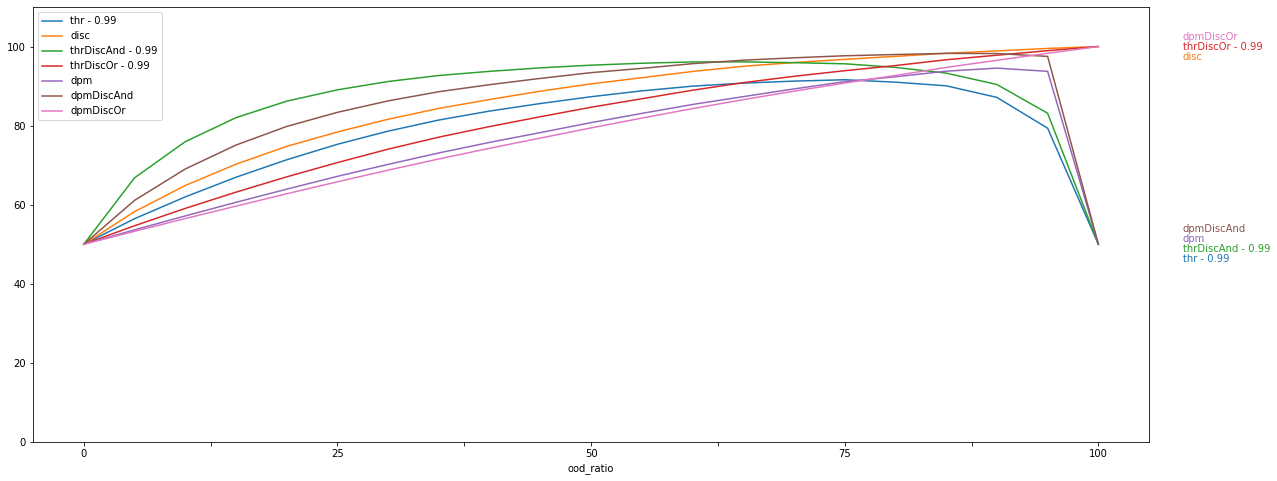

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  71.88  10.68
1               disc  85.54  14.50
2  thrDiscAnd - 0.99  80.49  12.79
3   thrDiscOr - 0.99  81.15  15.39
4                dpm  74.97  14.45
5         dpmDiscAnd  84.97  15.33
6          dpmDiscOr  77.78  15.58

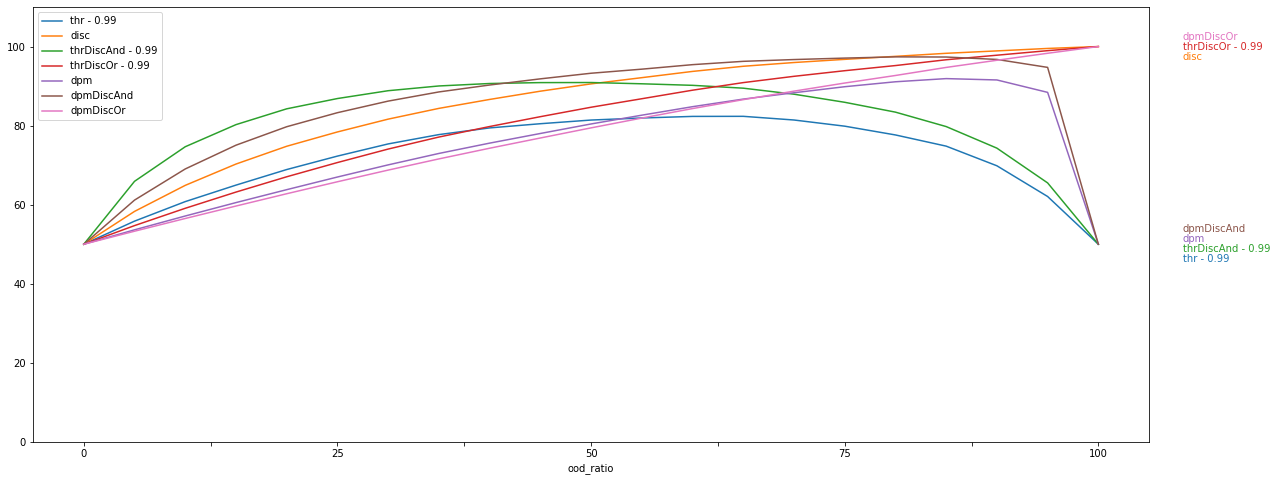

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  70.13  10.01
1               disc  85.54  14.50
2  thrDiscAnd - 0.99  78.96  12.53
3   thrDiscOr - 0.99  81.15  15.39
4                dpm  68.24   9.85
5         dpmDiscAnd  80.90  13.38
6          dpmDiscOr  77.78  15.58

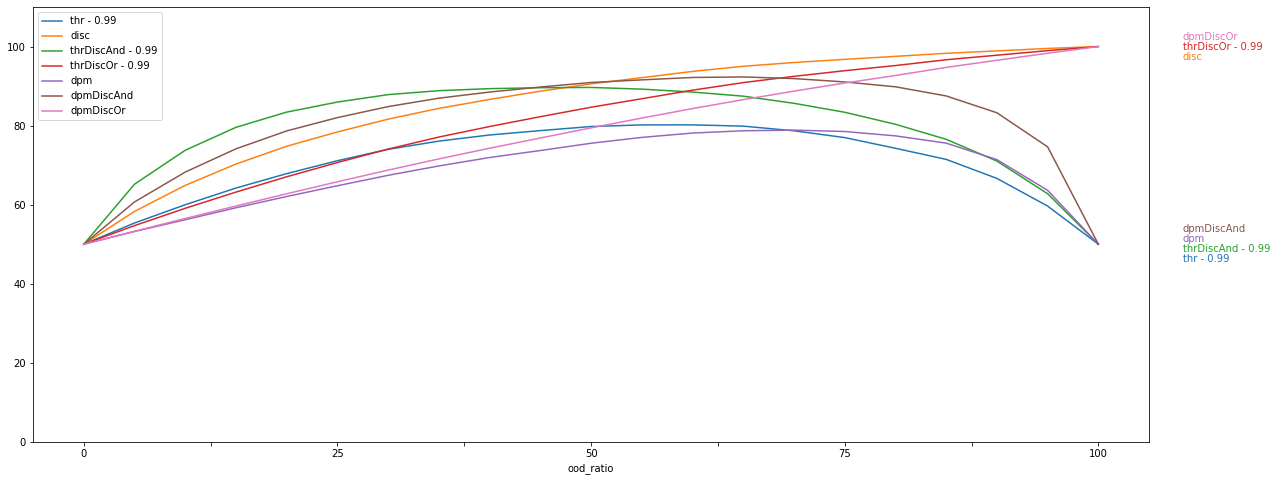

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  47.06   1.50
1               disc  85.54  14.50
2  thrDiscAnd - 0.99  59.02   4.80
3   thrDiscOr - 0.99  81.15  15.39
4                dpm  50.56   0.55
5         dpmDiscAnd  66.99   8.44
6          dpmDiscOr  77.78  15.58

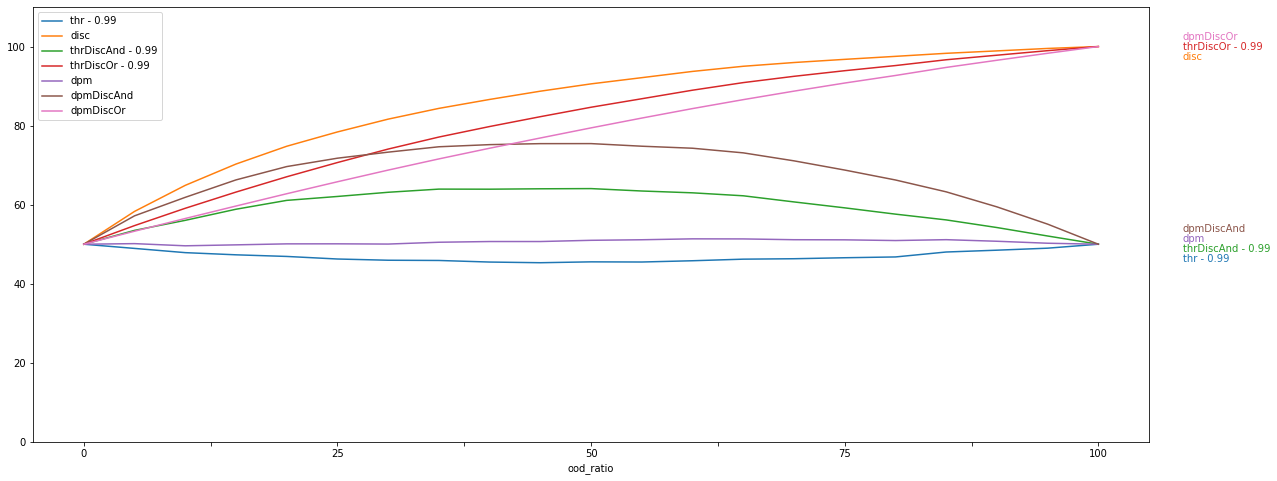

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  84.08  14.84
1               disc  85.54  14.50
2  thrDiscAnd - 0.99  91.06  12.75
3   thrDiscOr - 0.99  81.15  15.39
4                dpm  78.74  15.50
5         dpmDiscAnd  88.02  13.85
6          dpmDiscOr  77.78  15.58

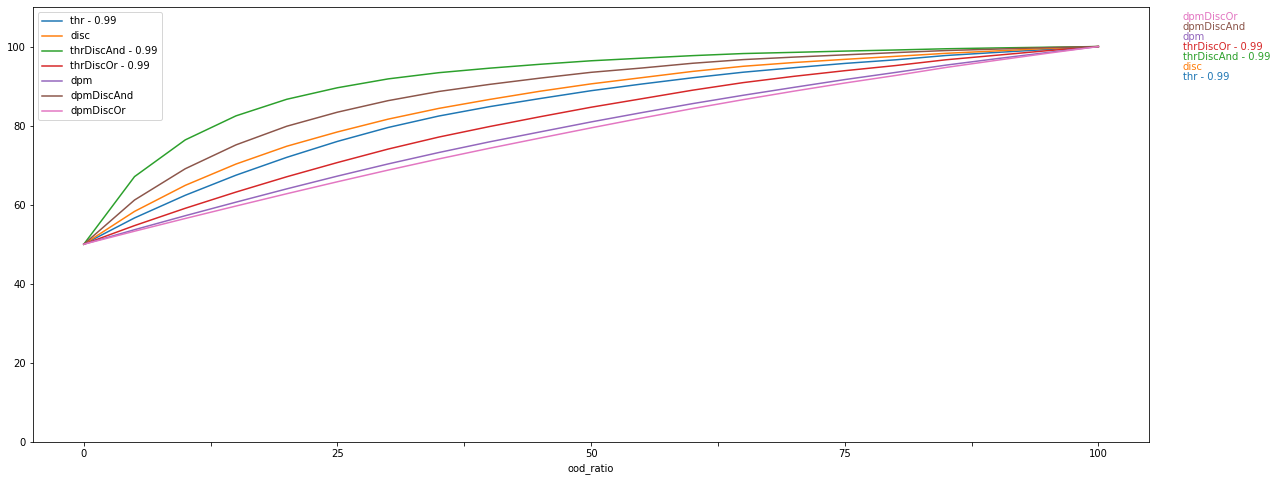

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot weighted Precision vs. ratio (binary)

In [ ]:
y = 'P_weighted_bin'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean   std
0         thr - 0.99  91.41  4.29
1               disc  93.51  3.80
2  thrDiscAnd - 0.99  96.38  1.77
3   thrDiscOr - 0.99  90.02  5.47
4                dpm  87.76  6.54
5         dpmDiscAnd  95.23  2.91
6          dpmDiscOr  86.94  6.99

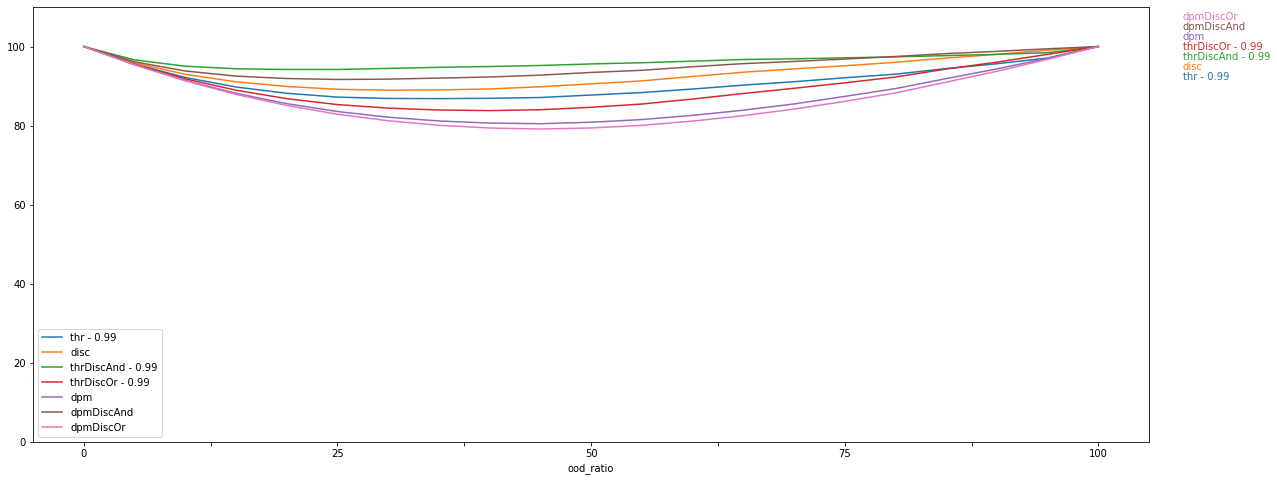

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  91.07  4.32
1               disc  93.51  3.80
2  thrDiscAnd - 0.99  96.12  1.74
3   thrDiscOr - 0.99  90.02  5.47
4                dpm  87.63  6.53
5         dpmDiscAnd  95.17  2.88
6          dpmDiscOr  86.94  6.99

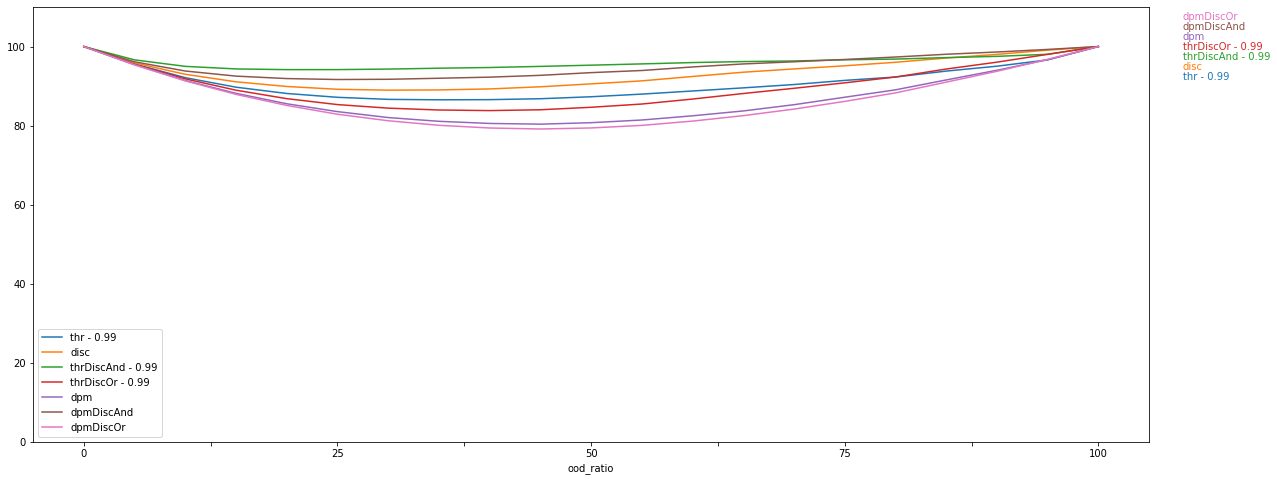

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  87.20  5.99
1               disc  93.50  3.80
2  thrDiscAnd - 0.99  93.10  2.79
3   thrDiscOr - 0.99  90.02  5.47
4                dpm  87.31  6.57
5         dpmDiscAnd  95.02  2.85
6          dpmDiscOr  86.93  6.98

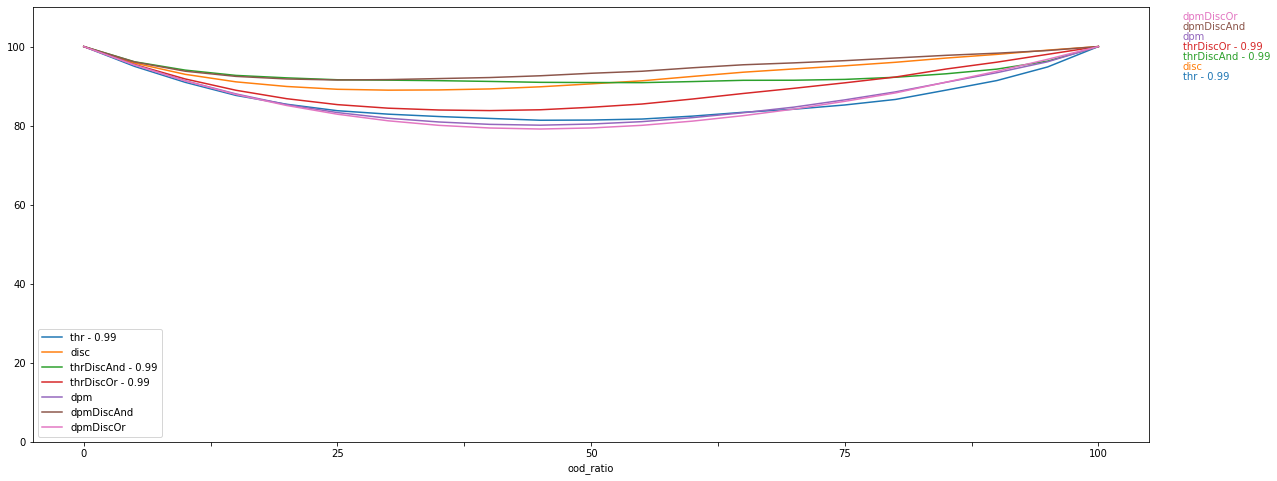

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  85.99  6.61
1               disc  93.50  3.80
2  thrDiscAnd - 0.99  92.15  3.25
3   thrDiscOr - 0.99  90.02  5.47
4                dpm  83.72  8.04
5         dpmDiscAnd  93.16  3.08
6          dpmDiscOr  86.93  6.98

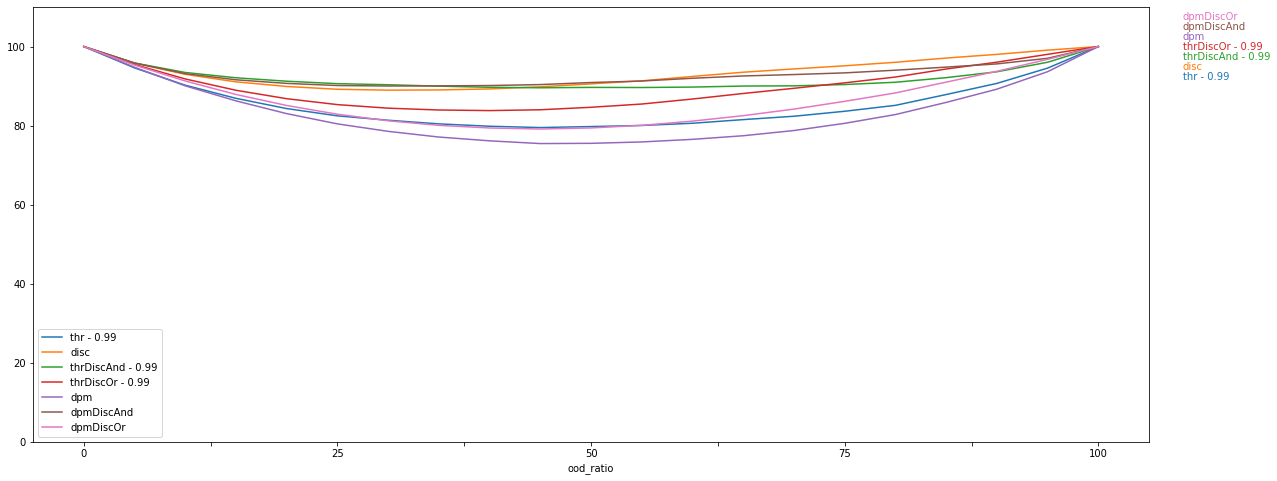

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  65.39  18.24
1               disc  93.50   3.80
2  thrDiscAnd - 0.99  76.87  12.13
3   thrDiscOr - 0.99  90.02   5.47
4                dpm  68.89  16.45
5         dpmDiscAnd  83.66   8.12
6          dpmDiscOr  86.93   6.98

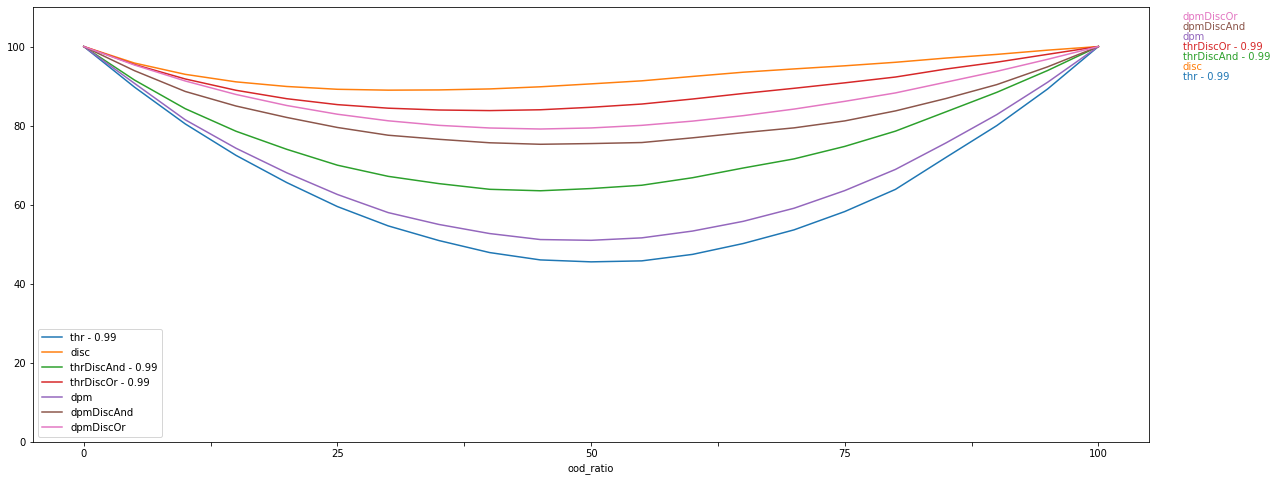

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  92.37  4.22
1               disc  93.50  3.80
2  thrDiscAnd - 0.99  97.10  1.85
3   thrDiscOr - 0.99  90.02  5.47
4                dpm  87.81  6.54
5         dpmDiscAnd  95.26  2.91
6          dpmDiscOr  86.93  6.98

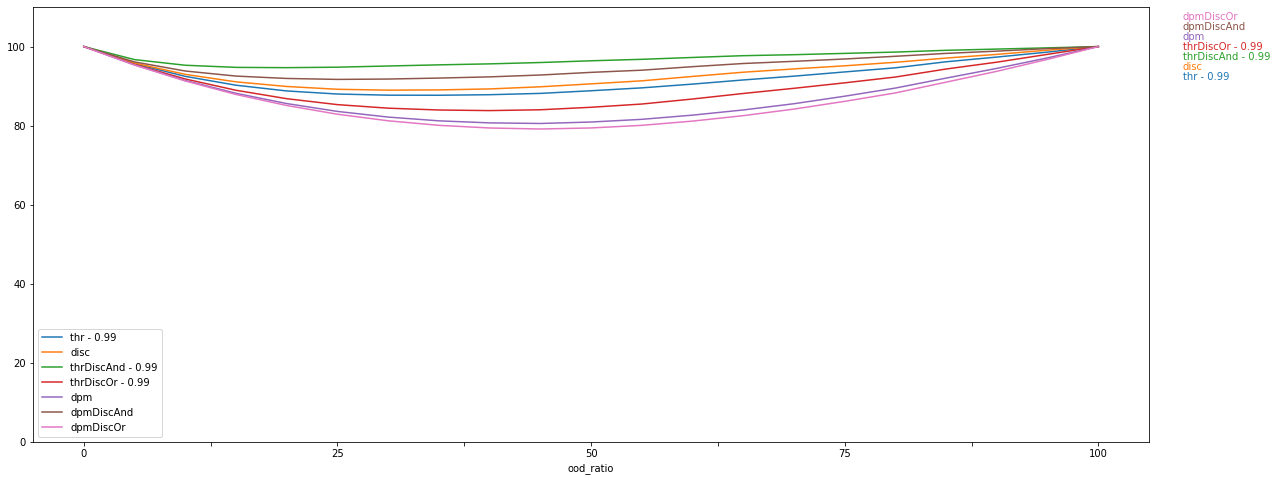

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot macro Recall vs. ratio (binary)

In [ ]:
y = 'R_macro_bin'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  80.22  13.40
1               disc  86.55  11.75
2  thrDiscAnd - 0.99  90.65  14.54
3   thrDiscOr - 0.99  76.12  12.90
4                dpm  65.46  12.00
5         dpmDiscAnd  88.08  14.31
6          dpmDiscOr  63.93  14.13

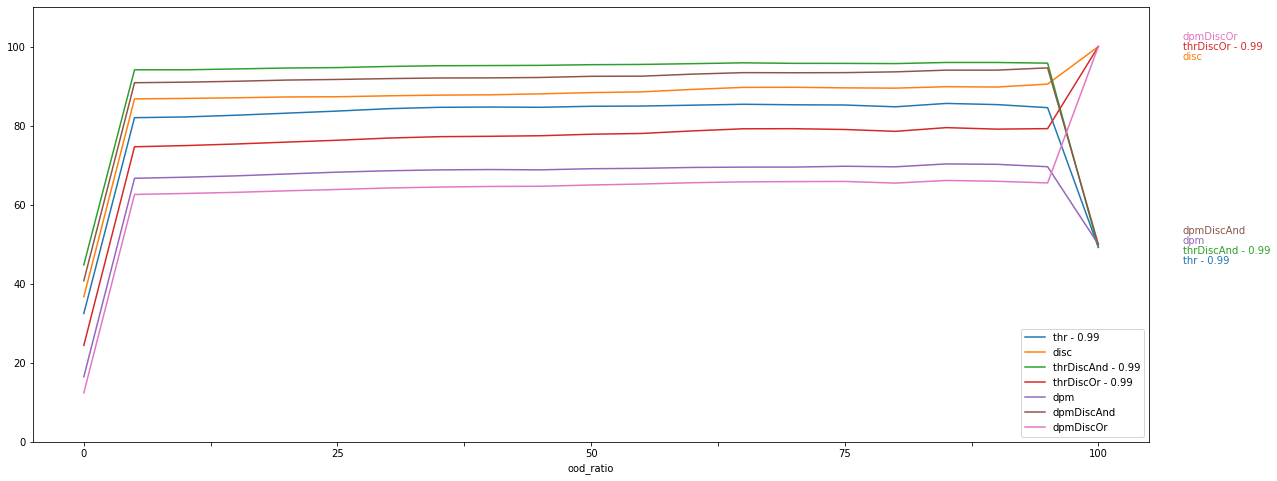

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  79.98  13.36
1               disc  86.55  11.75
2  thrDiscAnd - 0.99  90.41  14.52
3   thrDiscOr - 0.99  76.12  12.90
4                dpm  65.41  11.99
5         dpmDiscAnd  88.03  14.31
6          dpmDiscOr  63.93  14.13

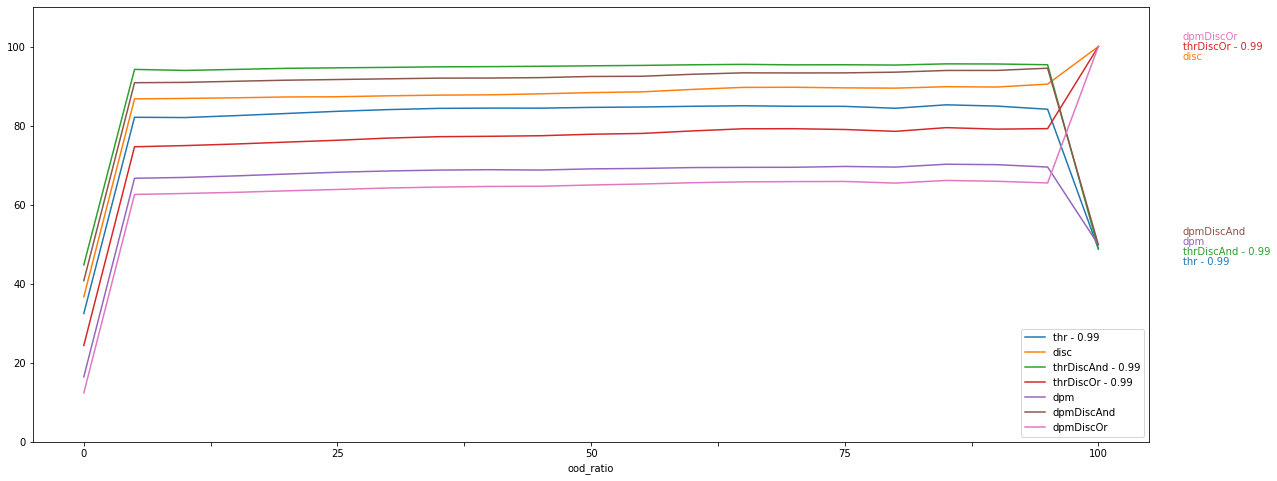

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  76.13  12.64
1               disc  86.55  11.75
2  thrDiscAnd - 0.99  86.56  13.89
3   thrDiscOr - 0.99  76.12  12.90
4                dpm  65.29  11.96
5         dpmDiscAnd  87.91  14.29
6          dpmDiscOr  63.93  14.13

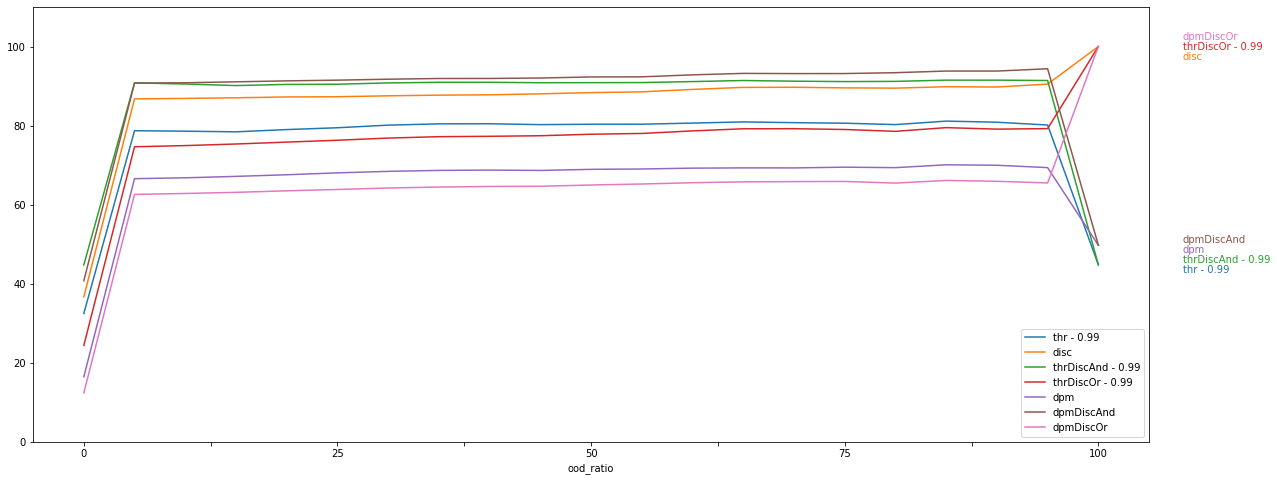

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  74.58  12.37
1               disc  86.55  11.75
2  thrDiscAnd - 0.99  85.01  13.65
3   thrDiscOr - 0.99  76.12  12.90
4                dpm  63.41  11.57
5         dpmDiscAnd  86.03  13.98
6          dpmDiscOr  63.93  14.13

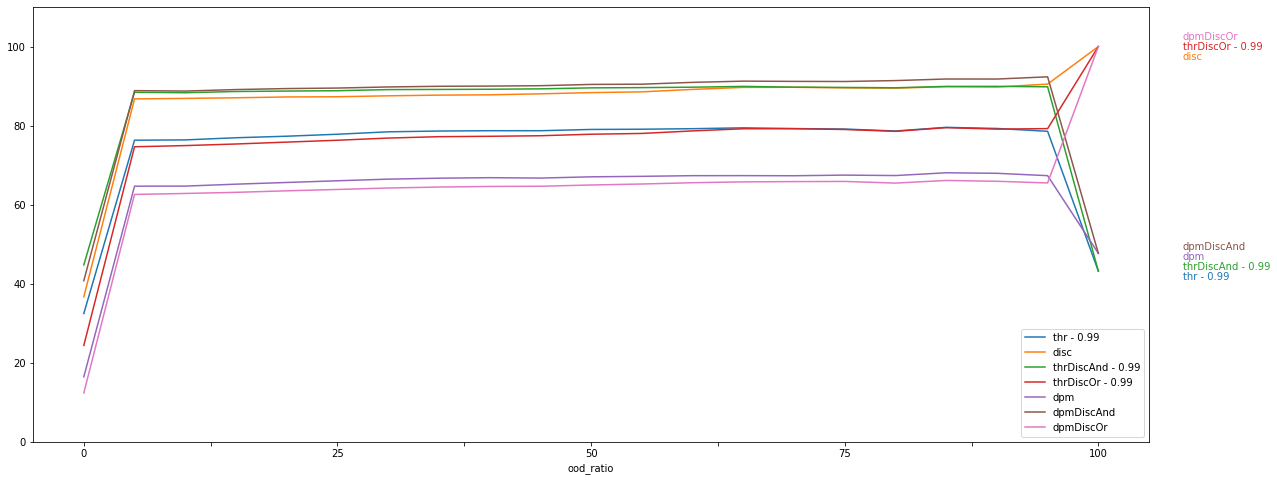

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  43.97   8.17
1               disc  86.55  11.75
2  thrDiscAnd - 0.99  54.40  10.32
3   thrDiscOr - 0.99  76.12  12.90
4                dpm  48.27   8.43
5         dpmDiscAnd  70.89  11.65
6          dpmDiscOr  63.93  14.13

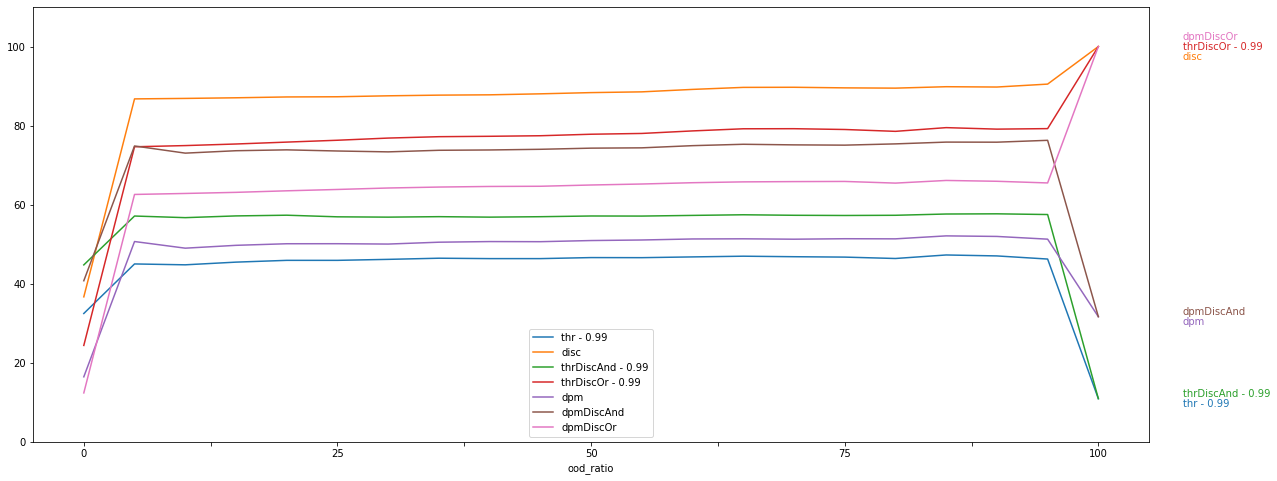

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  83.34  12.14
1               disc  86.55  11.75
2  thrDiscAnd - 0.99  93.77  11.27
3   thrDiscOr - 0.99  76.12  12.90
4                dpm  67.86  13.63
5         dpmDiscAnd  90.48  11.55
6          dpmDiscOr  63.93  14.13

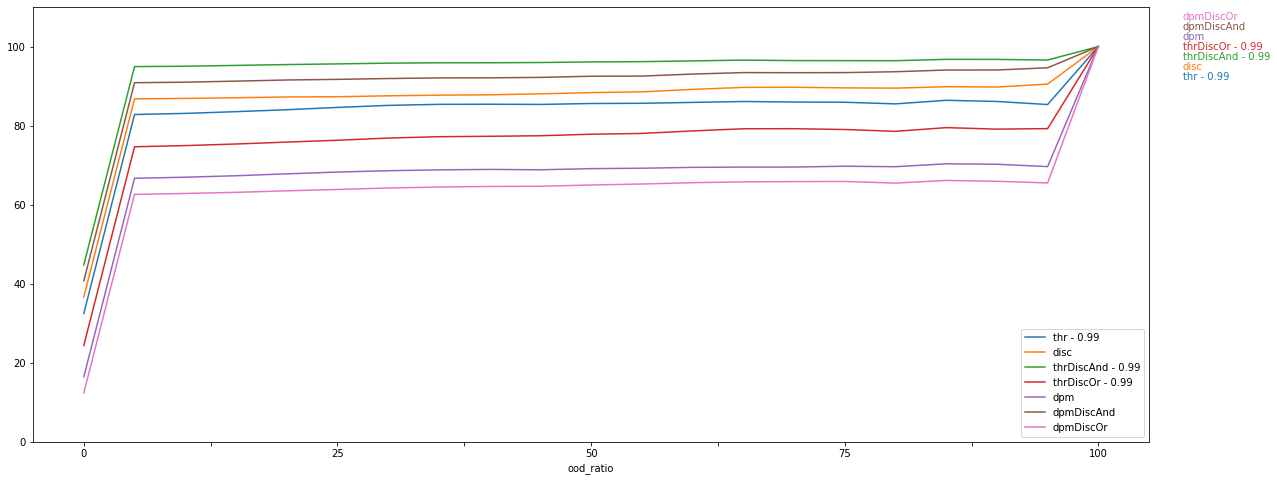

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot weighted Recall vs. ratio (binary)

In [ ]:
y = 'R_weighted_bin'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  83.72  10.19
1               disc  87.74   8.43
2  thrDiscAnd - 0.99  94.89   2.75
3   thrDiscOr - 0.99  76.58  15.87
4                dpm  68.17  20.66
5         dpmDiscAnd  91.87   5.80
6          dpmDiscOr  64.05  23.30

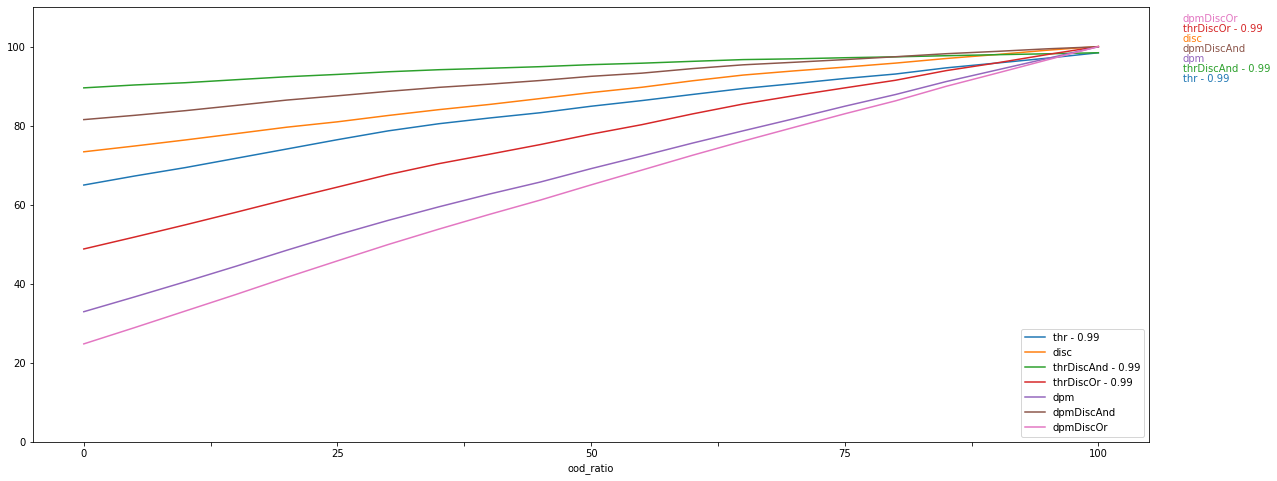

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  83.41   9.94
1               disc  87.74   8.43
2  thrDiscAnd - 0.99  94.57   2.50
3   thrDiscOr - 0.99  76.58  15.87
4                dpm  68.12  20.61
5         dpmDiscAnd  91.81   5.75
6          dpmDiscOr  64.05  23.30

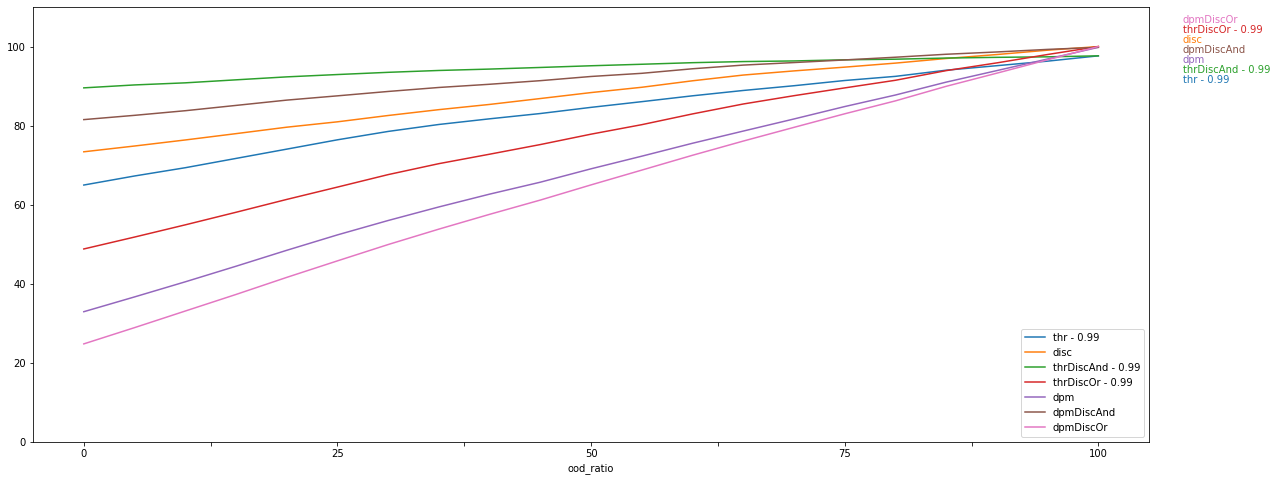

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  79.30   7.39
1               disc  87.75   8.43
2  thrDiscAnd - 0.99  90.46   0.52
3   thrDiscOr - 0.99  76.59  15.86
4                dpm  67.99  20.51
5         dpmDiscAnd  91.68   5.65
6          dpmDiscOr  64.06  23.29

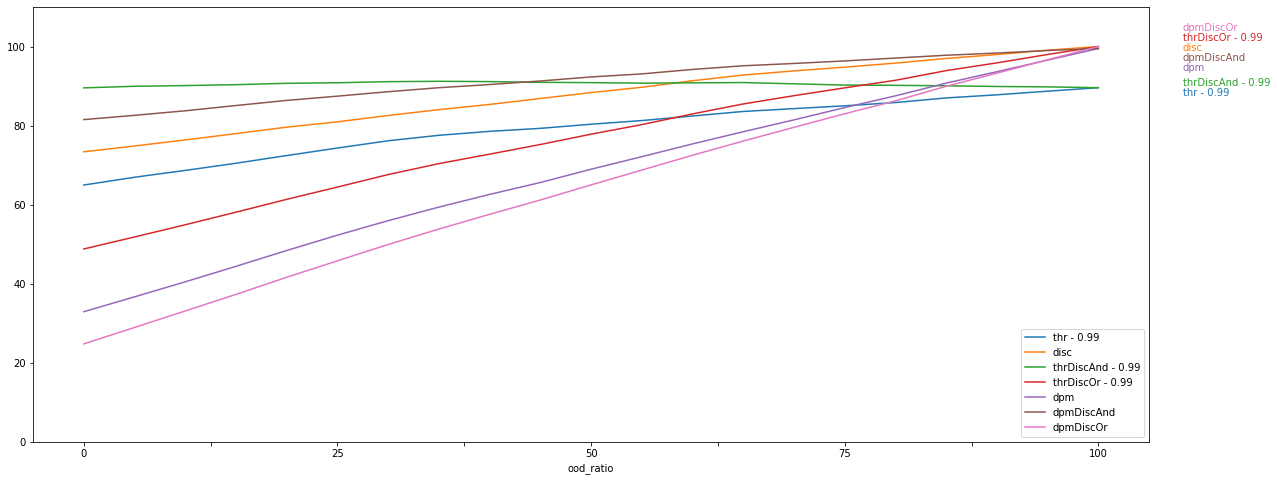

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  77.74   6.47
1               disc  87.75   8.43
2  thrDiscAnd - 0.99  88.90   1.19
3   thrDiscOr - 0.99  76.59  15.86
4                dpm  66.00  19.25
5         dpmDiscAnd  89.69   4.41
6          dpmDiscOr  64.06  23.29

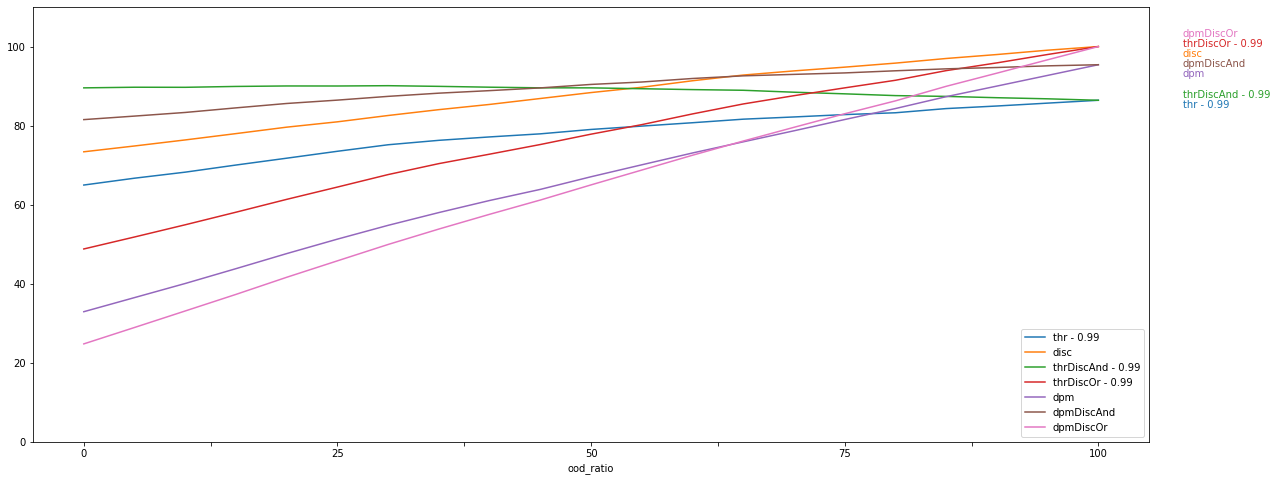

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  45.42  13.83
1               disc  87.75   8.43
2  thrDiscAnd - 0.99  56.57  21.19
3   thrDiscOr - 0.99  76.59  15.86
4                dpm  49.96   9.30
5         dpmDiscAnd  73.65   5.66
6          dpmDiscOr  64.06  23.29

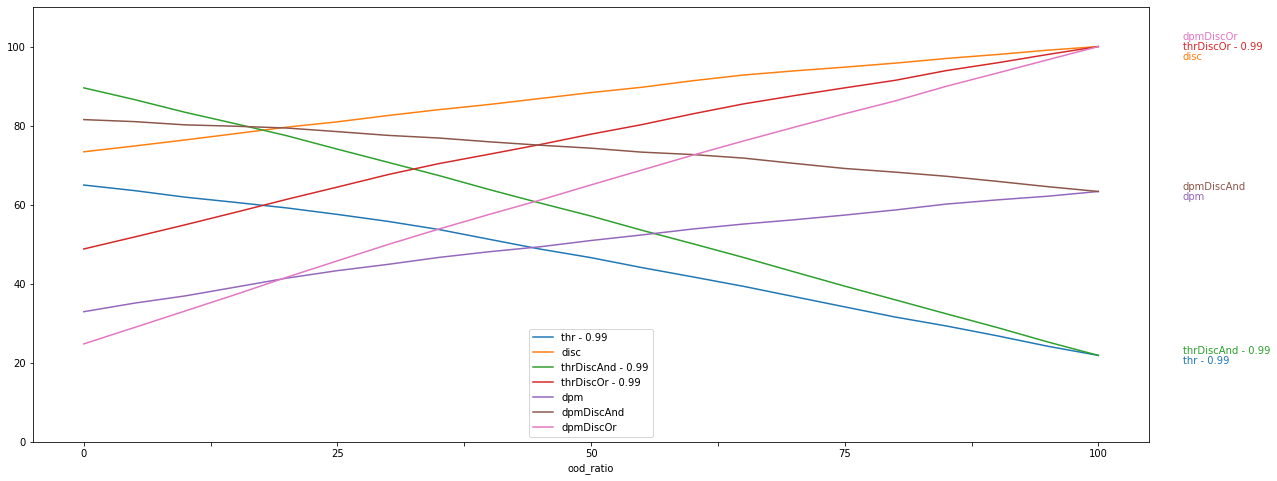

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  84.49  10.65
1               disc  87.75   8.43
2  thrDiscAnd - 0.99  95.64   3.21
3   thrDiscOr - 0.99  76.59  15.86
4                dpm  68.21  20.67
5         dpmDiscAnd  91.89   5.81
6          dpmDiscOr  64.06  23.29

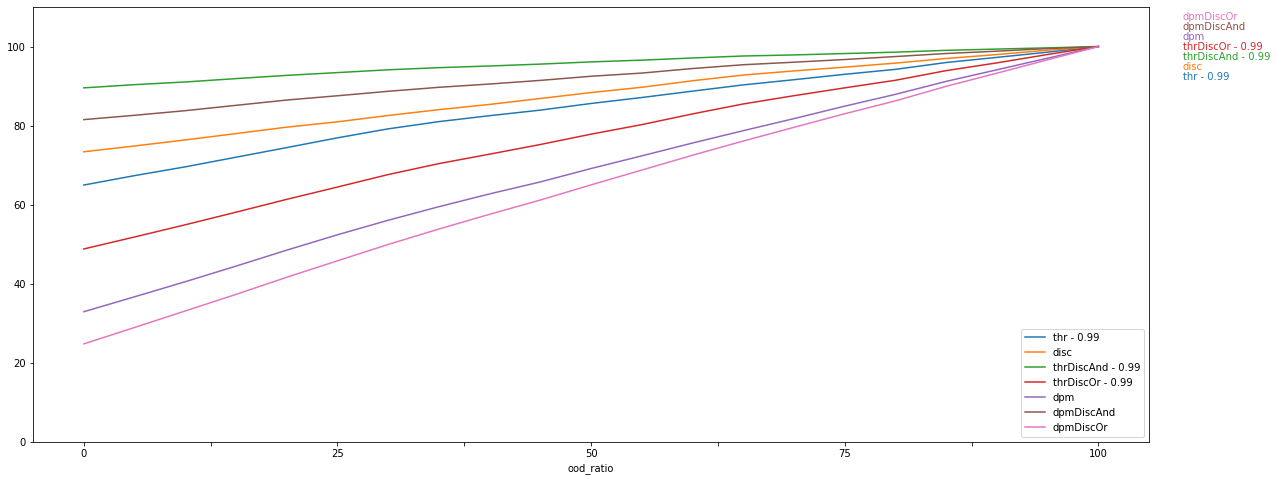

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot macro F1 vs. ratio (binary)

In [ ]:
y = 'F1_macro_bin'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  76.28  14.81
1               disc  83.17  14.16
2  thrDiscAnd - 0.99  87.91  14.38
3   thrDiscOr - 0.99  71.92  16.65
4                dpm  59.70  15.58
5         dpmDiscAnd  85.05  15.20
6          dpmDiscOr  56.82  18.63

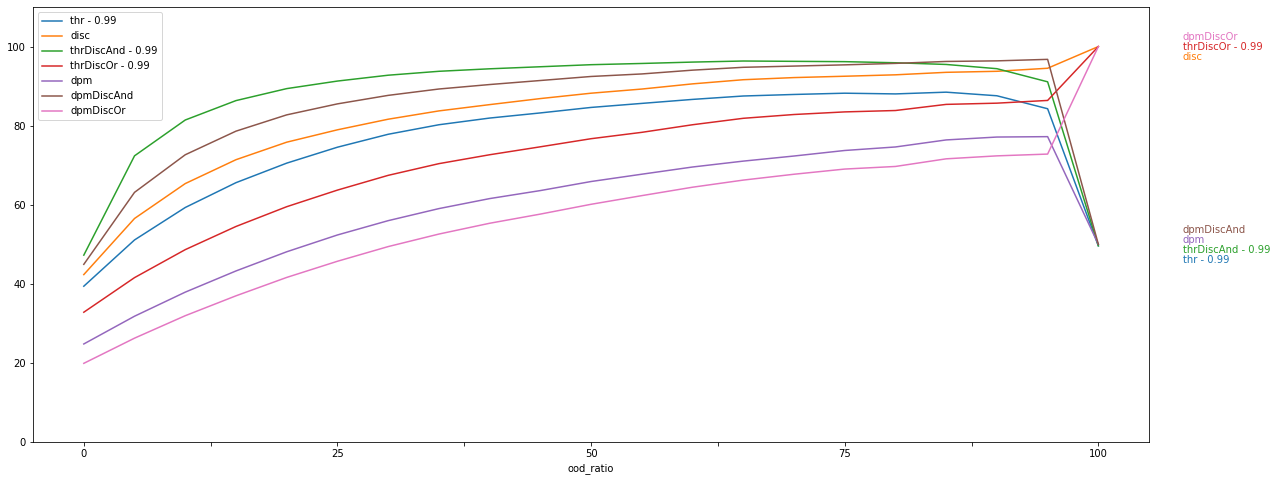

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  75.80  14.53
1               disc  83.17  14.16
2  thrDiscAnd - 0.99  87.42  14.20
3   thrDiscOr - 0.99  71.92  16.65
4                dpm  59.60  15.49
5         dpmDiscAnd  84.94  15.13
6          dpmDiscOr  56.82  18.63

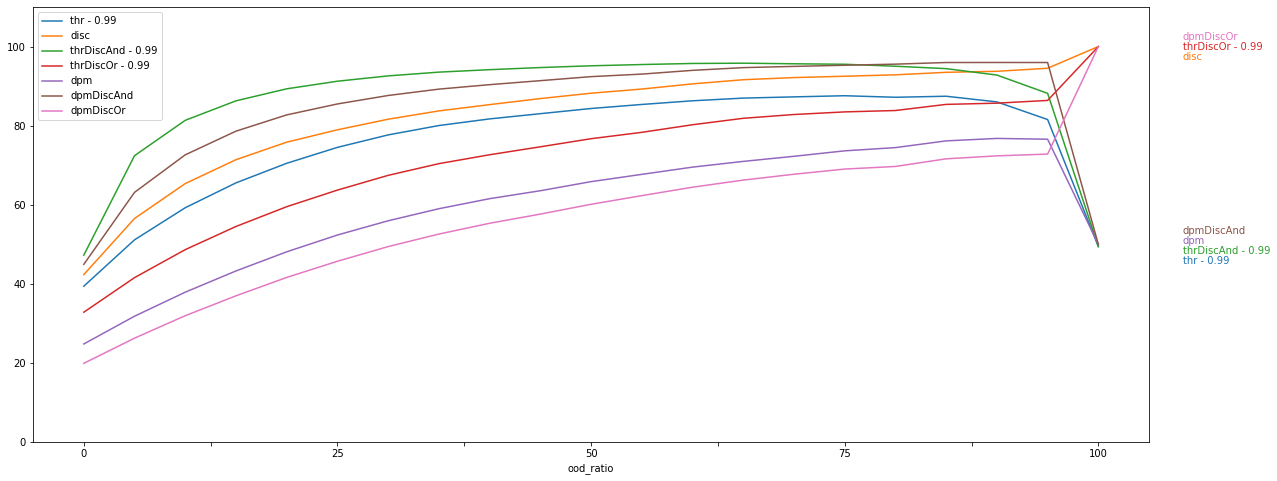

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  70.90  12.48
1               disc  83.19  14.14
2  thrDiscAnd - 0.99  82.17  13.10
3   thrDiscOr - 0.99  71.93  16.64
4                dpm  59.42  15.33
5         dpmDiscAnd  84.71  14.99
6          dpmDiscOr  56.84  18.62

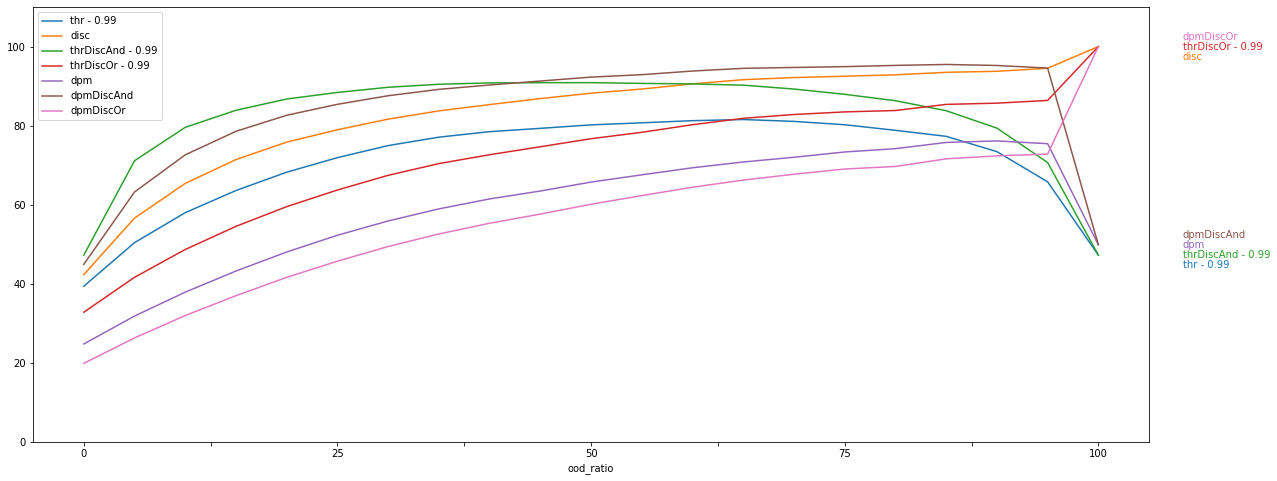

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  69.27  12.01
1               disc  83.19  14.14
2  thrDiscAnd - 0.99  80.40  12.92
3   thrDiscOr - 0.99  71.93  16.64
4                dpm  57.07  13.77
5         dpmDiscAnd  81.79  13.78
6          dpmDiscOr  56.84  18.62

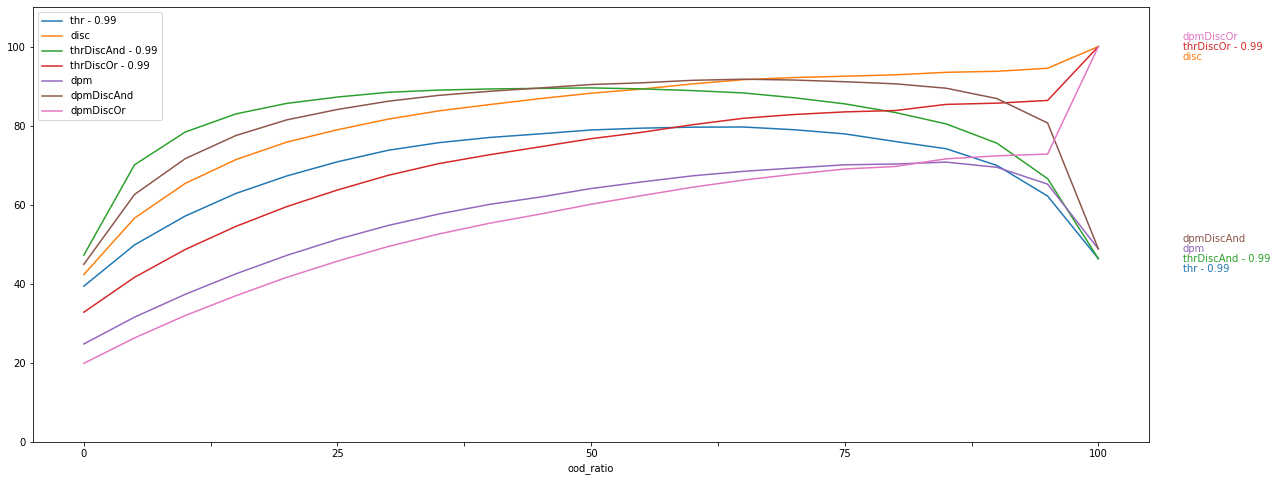

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  38.22   8.46
1               disc  83.19  14.14
2  thrDiscAnd - 0.99  45.71  12.04
3   thrDiscOr - 0.99  71.93  16.64
4                dpm  44.02   7.67
5         dpmDiscAnd  65.21  10.56
6          dpmDiscOr  56.84  18.62

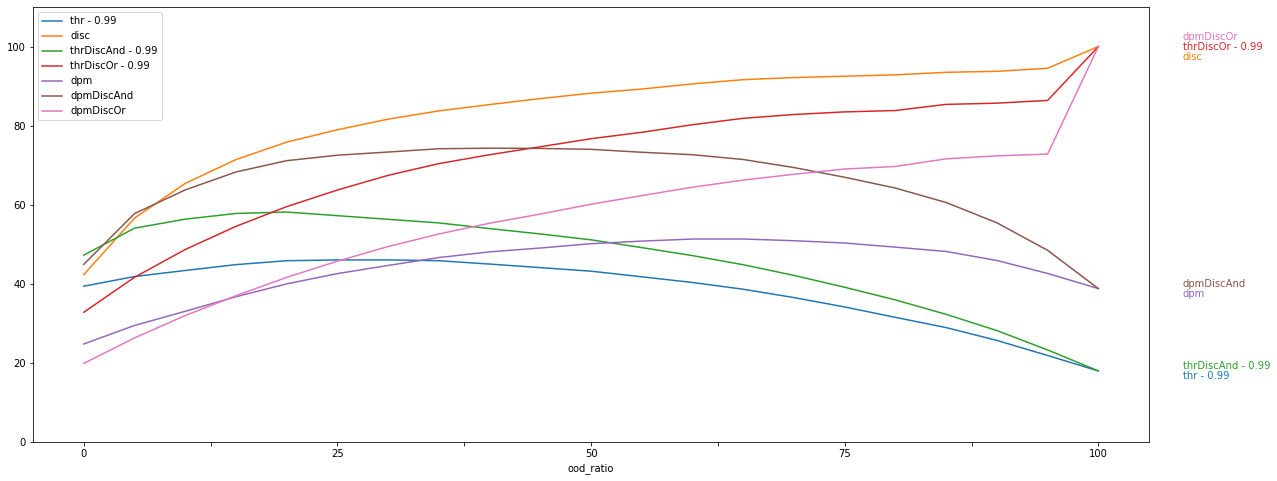

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  79.87  14.90
1               disc  83.19  14.14
2  thrDiscAnd - 0.99  91.56  12.02
3   thrDiscOr - 0.99  71.93  16.64
4                dpm  62.12  17.71
5         dpmDiscAnd  87.48  13.23
6          dpmDiscOr  56.84  18.62

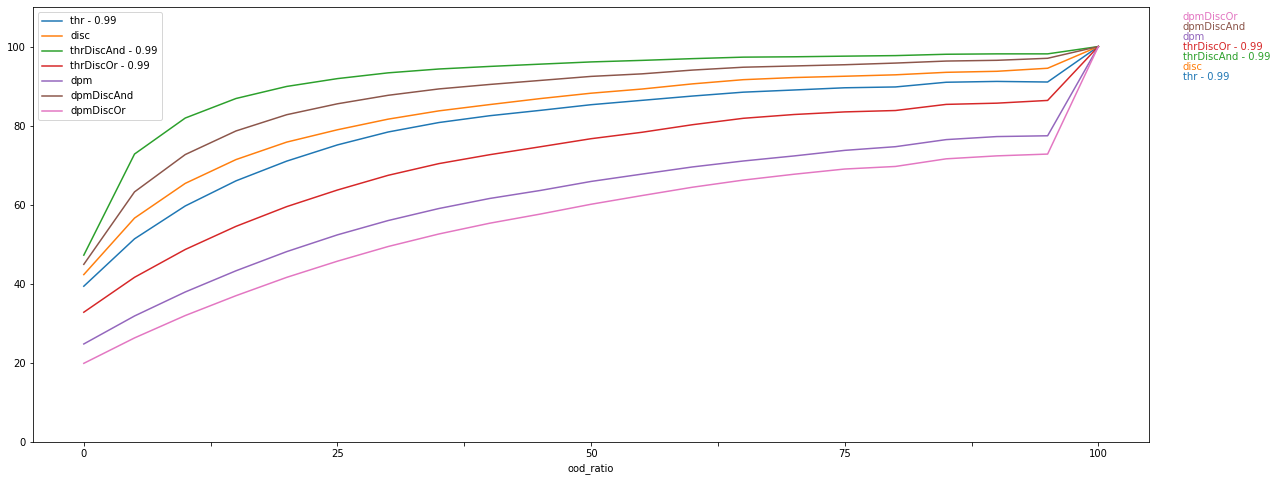

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot weighted F1 vs. ratio (binary)

In [ ]:
y = 'F1_weighted_bin'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean    std
0         thr - 0.99  85.45   7.62
1               disc  89.10   6.50
2  thrDiscAnd - 0.99  95.39   2.17
3   thrDiscOr - 0.99  78.35  12.47
4                dpm  68.69  17.30
5         dpmDiscAnd  92.80   4.49
6          dpmDiscOr  63.27  20.44

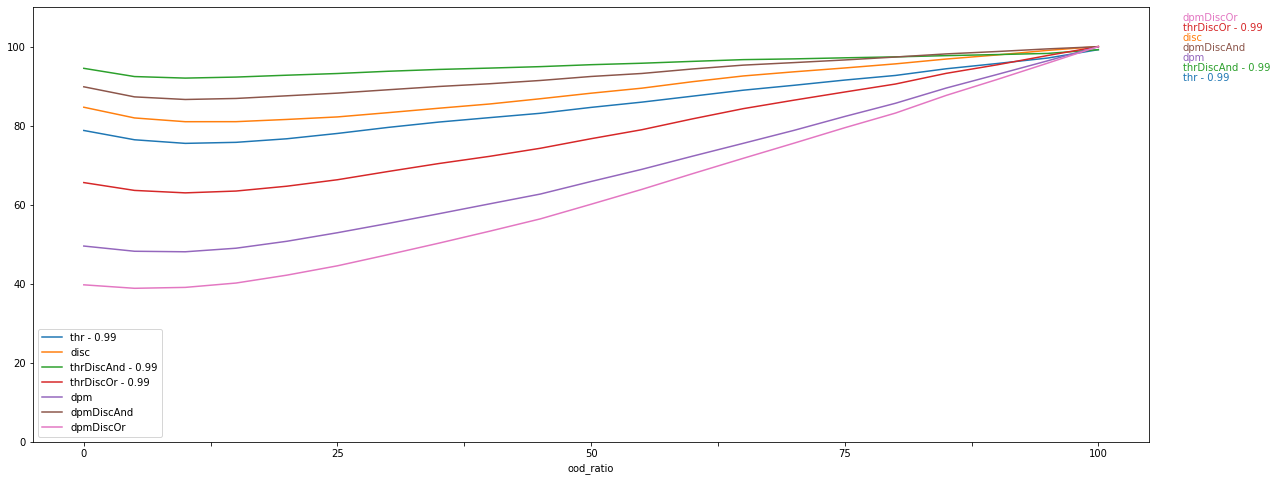

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  85.17   7.41
1               disc  89.10   6.50
2  thrDiscAnd - 0.99  95.10   1.96
3   thrDiscOr - 0.99  78.35  12.47
4                dpm  68.64  17.26
5         dpmDiscAnd  92.74   4.45
6          dpmDiscOr  63.27  20.44

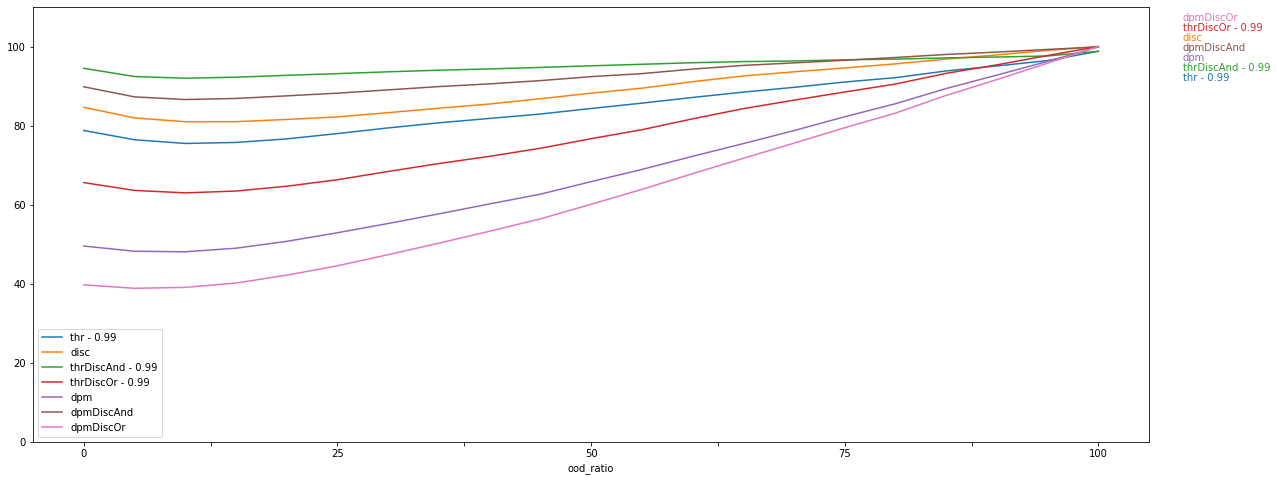

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  81.60   5.68
1               disc  89.10   6.50
2  thrDiscAnd - 0.99  91.42   1.09
3   thrDiscOr - 0.99  78.35  12.47
4                dpm  68.53  17.18
5         dpmDiscAnd  92.61   4.37
6          dpmDiscOr  63.28  20.44

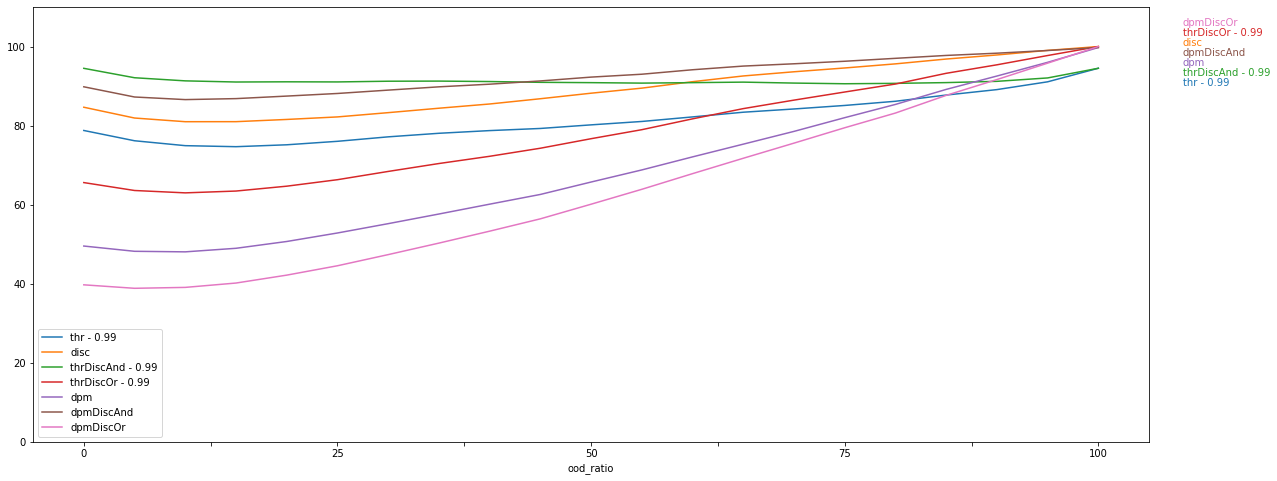

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  80.29   5.12
1               disc  89.10   6.50
2  thrDiscAnd - 0.99  90.06   1.48
3   thrDiscOr - 0.99  78.35  12.47
4                dpm  66.94  16.26
5         dpmDiscAnd  90.80   3.42
6          dpmDiscOr  63.28  20.44

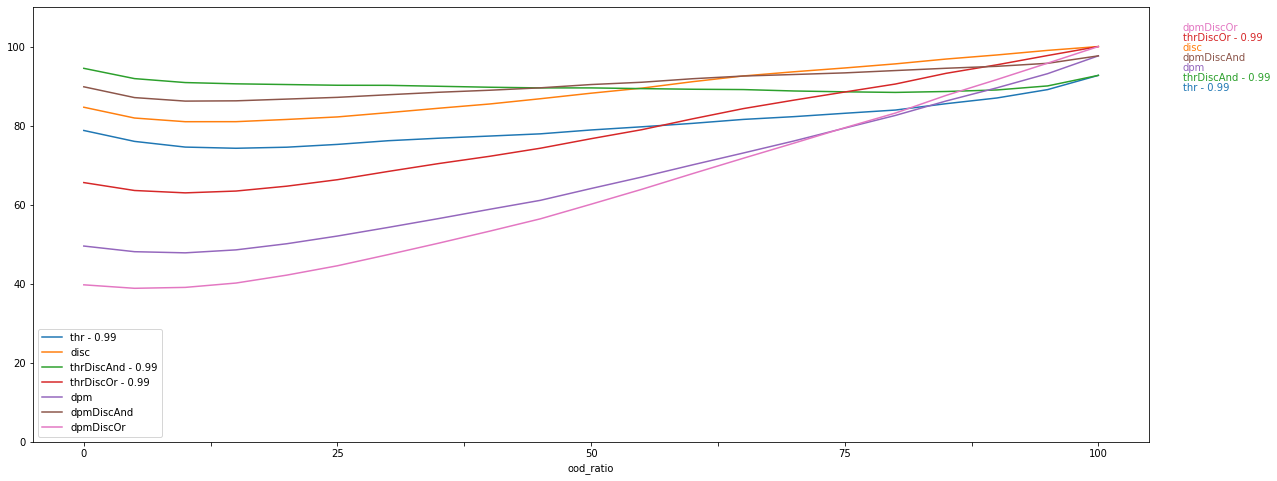

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  47.87  14.91
1               disc  89.10   6.50
2  thrDiscAnd - 0.99  55.69  19.89
3   thrDiscOr - 0.99  78.35  12.47
4                dpm  54.51   9.80
5         dpmDiscAnd  76.57   5.15
6          dpmDiscOr  63.28  20.44

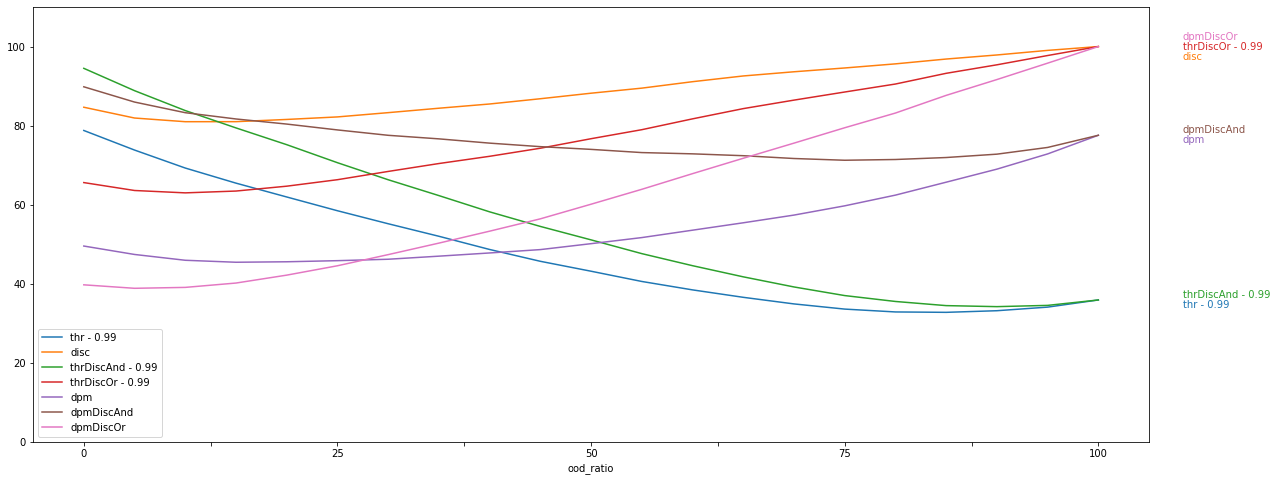

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean    std
0         thr - 0.99  86.14   8.00
1               disc  89.10   6.50
2  thrDiscAnd - 0.99  96.10   2.54
3   thrDiscOr - 0.99  78.35  12.47
4                dpm  68.71  17.32
5         dpmDiscAnd  92.82   4.51
6          dpmDiscOr  63.28  20.44

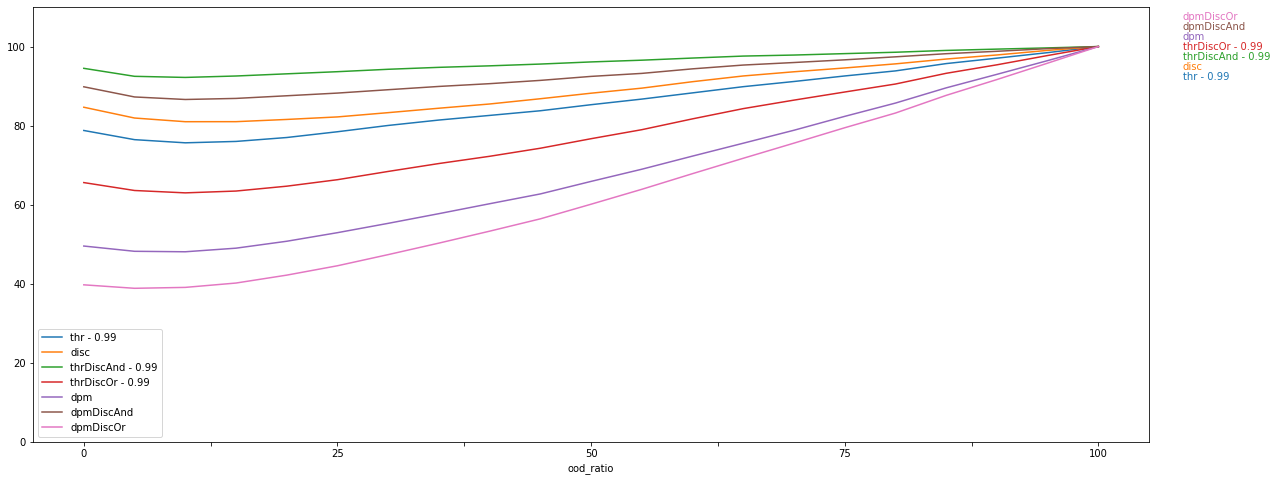

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot Sensitivity vs. ratio (binary)

In [ ]:
y = 'sensitivity'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp   mean   std
0         thr - 0.99  70.02  2.36
1               disc  76.75  2.46
2  thrDiscAnd - 0.99  91.92  1.24
3   thrDiscOr - 0.99  54.86  3.37
4                dpm  37.50  2.30
5         dpmDiscAnd  85.00  2.31
6          dpmDiscOr  29.25  2.41

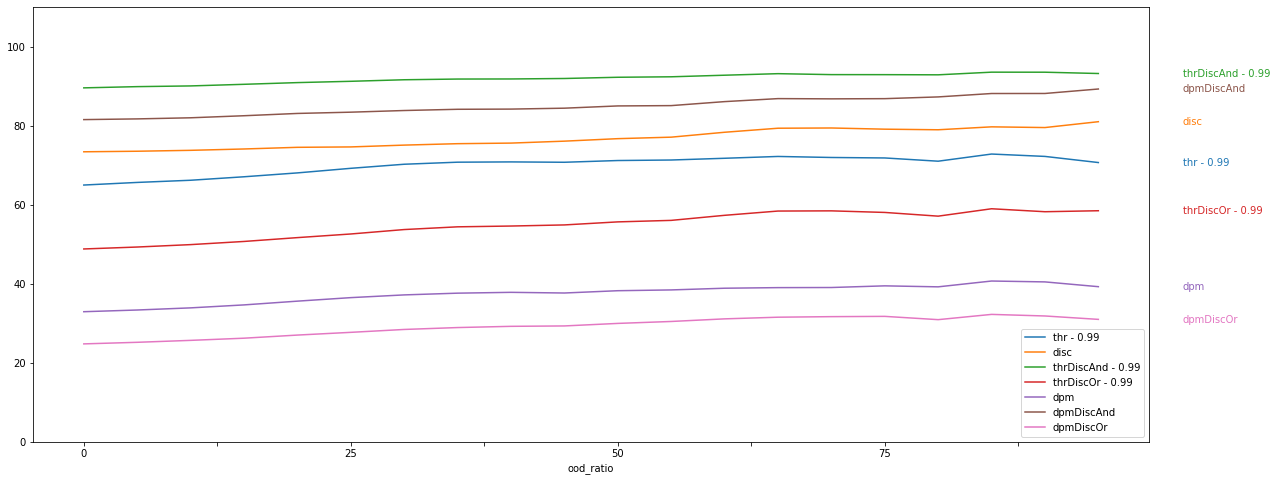

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  70.02  2.36
1               disc  76.75  2.46
2  thrDiscAnd - 0.99  91.92  1.24
3   thrDiscOr - 0.99  54.86  3.37
4                dpm  37.50  2.30
5         dpmDiscAnd  85.00  2.31
6          dpmDiscOr  29.25  2.41

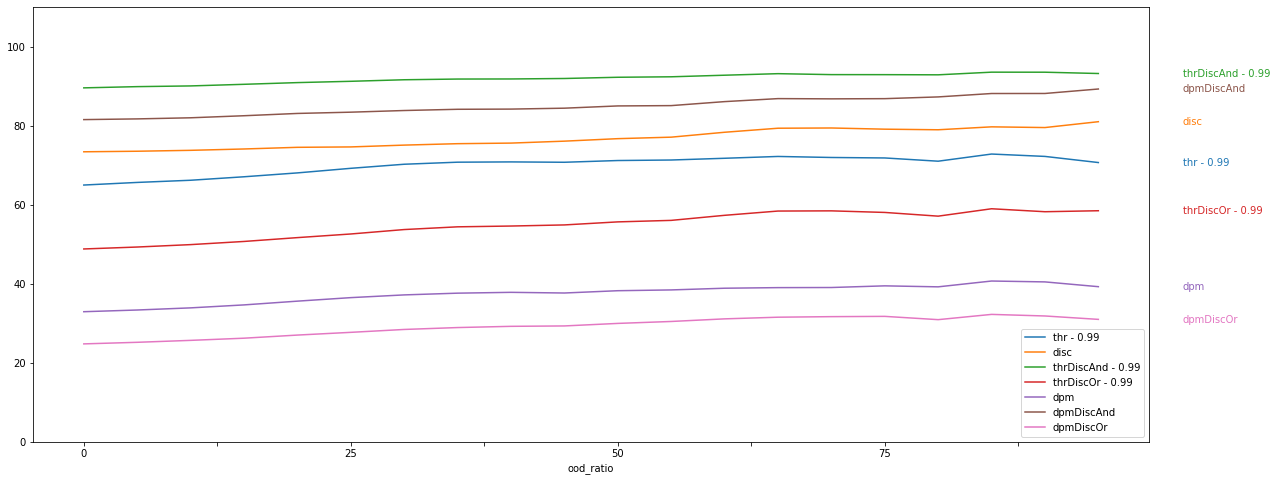

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  70.02  2.36
1               disc  76.75  2.46
2  thrDiscAnd - 0.99  91.92  1.24
3   thrDiscOr - 0.99  54.86  3.37
4                dpm  37.50  2.30
5         dpmDiscAnd  85.00  2.31
6          dpmDiscOr  29.25  2.41

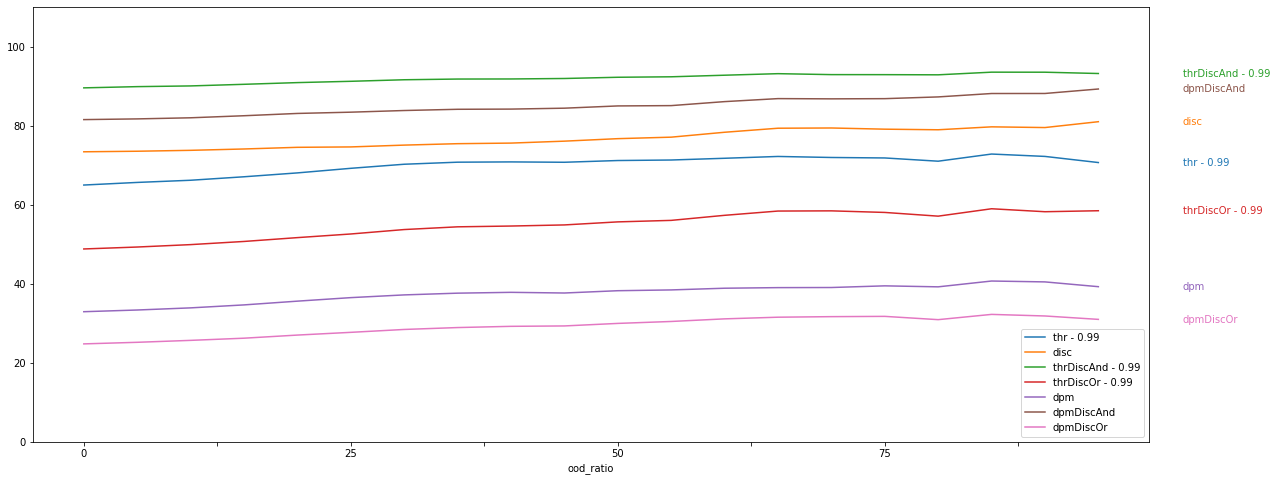

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  70.02  2.36
1               disc  76.75  2.46
2  thrDiscAnd - 0.99  91.92  1.24
3   thrDiscOr - 0.99  54.86  3.37
4                dpm  37.50  2.30
5         dpmDiscAnd  85.00  2.31
6          dpmDiscOr  29.25  2.41

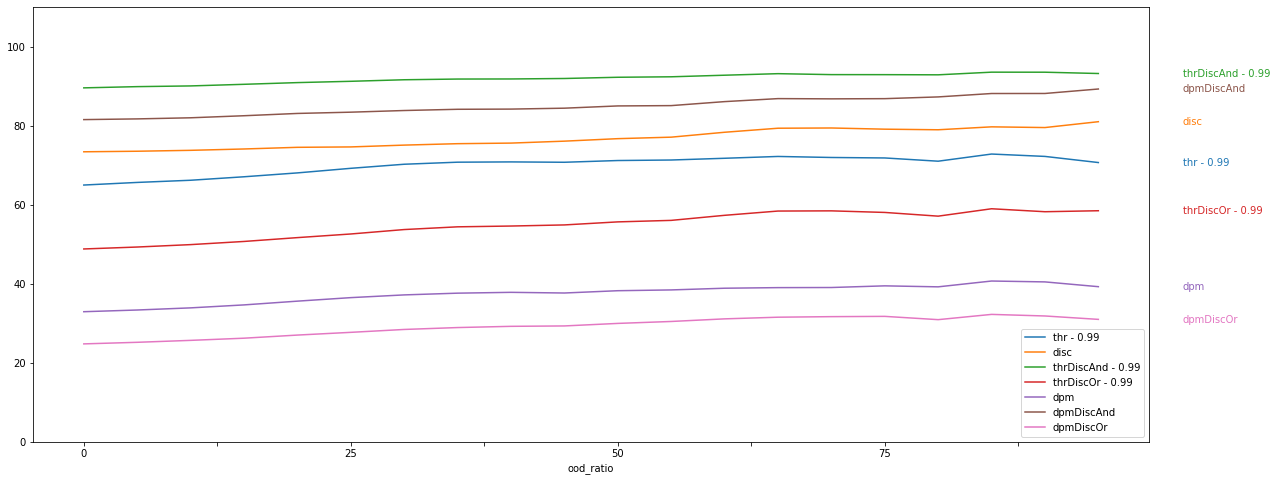

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  70.02  2.36
1               disc  76.75  2.46
2  thrDiscAnd - 0.99  91.92  1.24
3   thrDiscOr - 0.99  54.86  3.37
4                dpm  37.50  2.30
5         dpmDiscAnd  85.00  2.31
6          dpmDiscOr  29.25  2.41

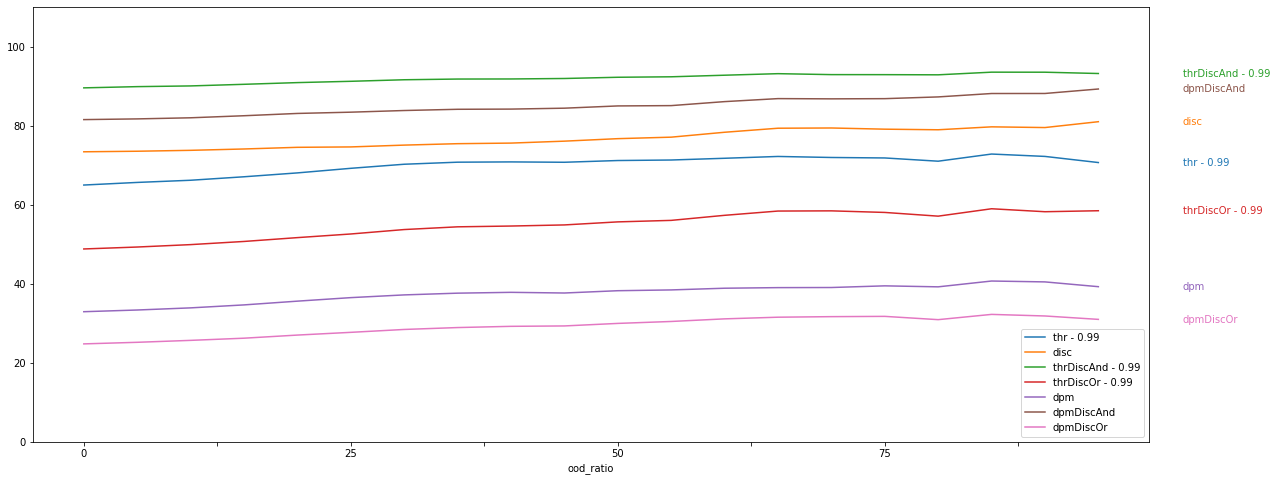

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean   std
0         thr - 0.99  70.02  2.36
1               disc  76.75  2.46
2  thrDiscAnd - 0.99  91.92  1.24
3   thrDiscOr - 0.99  54.86  3.37
4                dpm  37.50  2.30
5         dpmDiscAnd  85.00  2.31
6          dpmDiscOr  29.25  2.41

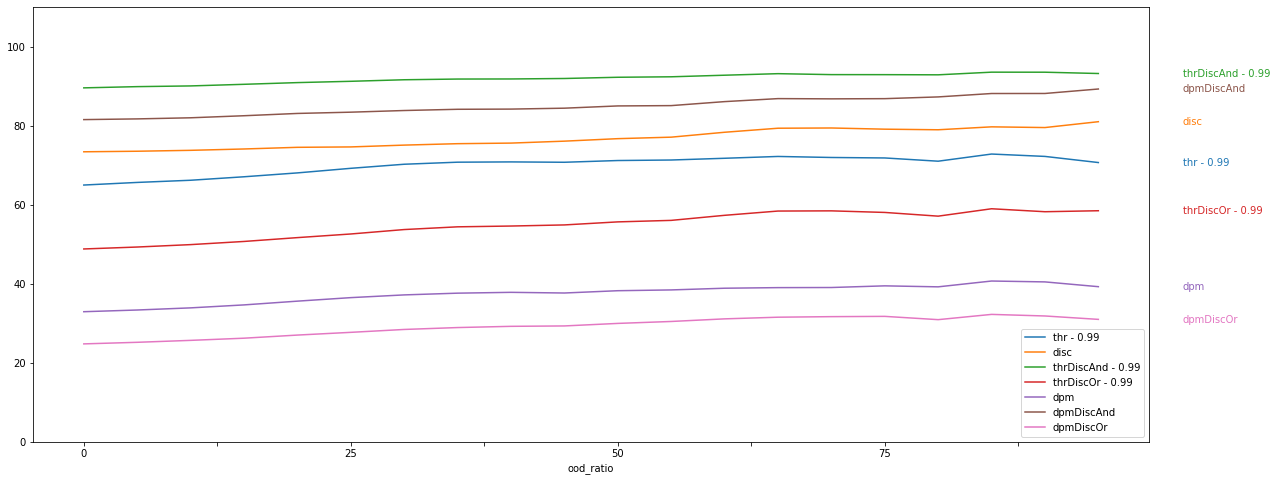

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Plot Specifity vs. ratio (binary)

In [ ]:
y = 'specifity'
exps = algorithms.copy()
target_thrs = ['0.99' ] #, '0.995', '0.999']

exp    mean   std
0         thr - 0.99   98.45  0.15
1               disc  100.00  0.00
2  thrDiscAnd - 0.99   98.45  0.15
3   thrDiscOr - 0.99  100.00  0.00
4                dpm   99.96  0.02
5         dpmDiscAnd   99.96  0.02
6          dpmDiscOr  100.00  0.00

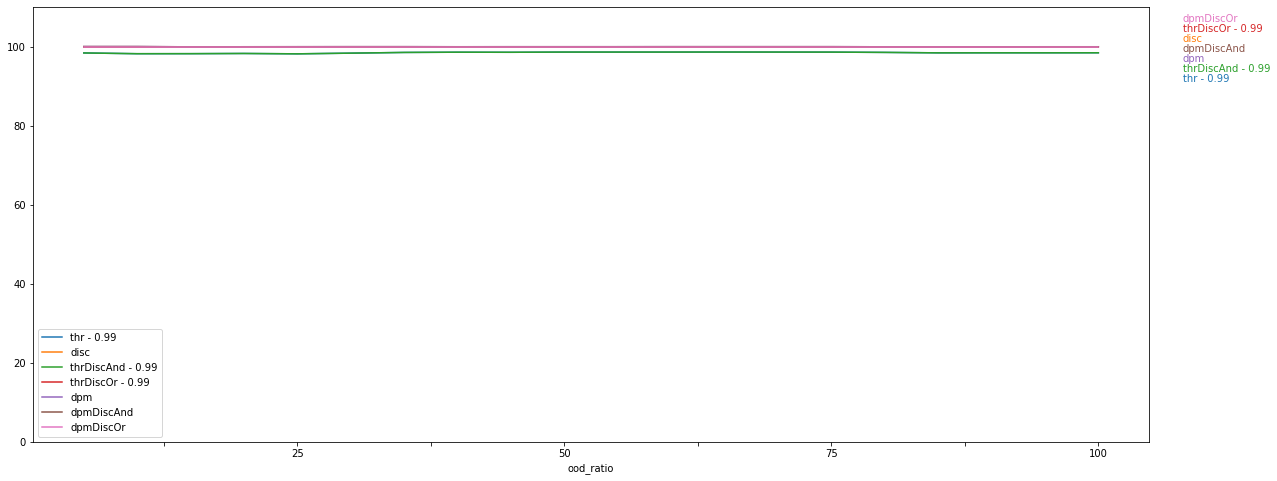

In [ ]:
ds_name = 'mnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp    mean   std
0         thr - 0.99   97.94  0.22
1               disc  100.00  0.00
2  thrDiscAnd - 0.99   97.94  0.22
3   thrDiscOr - 0.99  100.00  0.00
4                dpm   99.87  0.06
5         dpmDiscAnd   99.87  0.06
6          dpmDiscOr  100.00  0.00

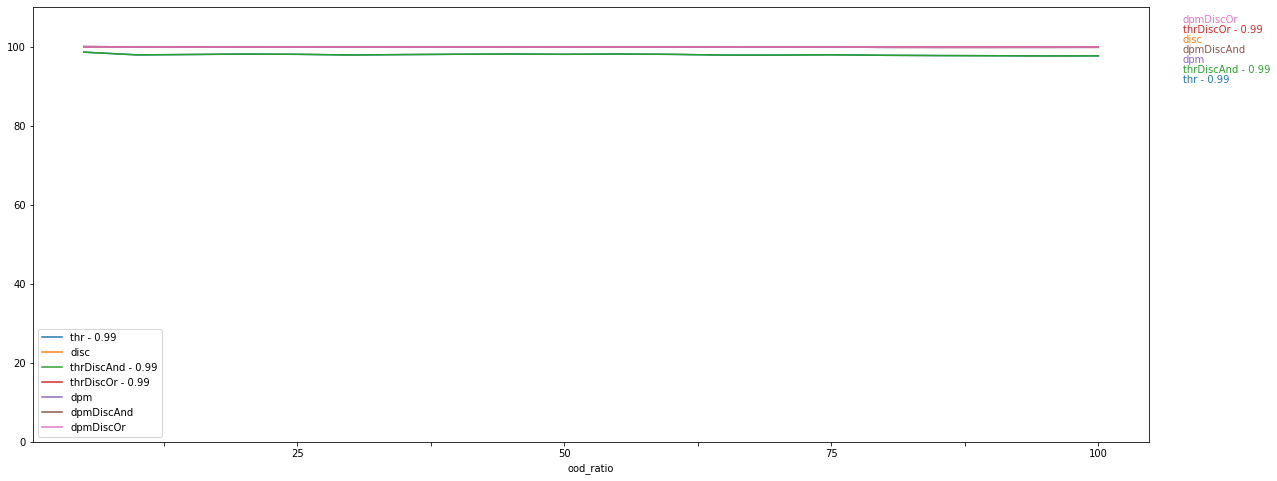

In [ ]:
ds_name = 'bmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp    mean   std
0         thr - 0.99   89.86  0.59
1               disc  100.00  0.00
2  thrDiscAnd - 0.99   89.86  0.59
3   thrDiscOr - 0.99  100.00  0.00
4                dpm   99.60  0.09
5         dpmDiscAnd   99.60  0.09
6          dpmDiscOr  100.00  0.00

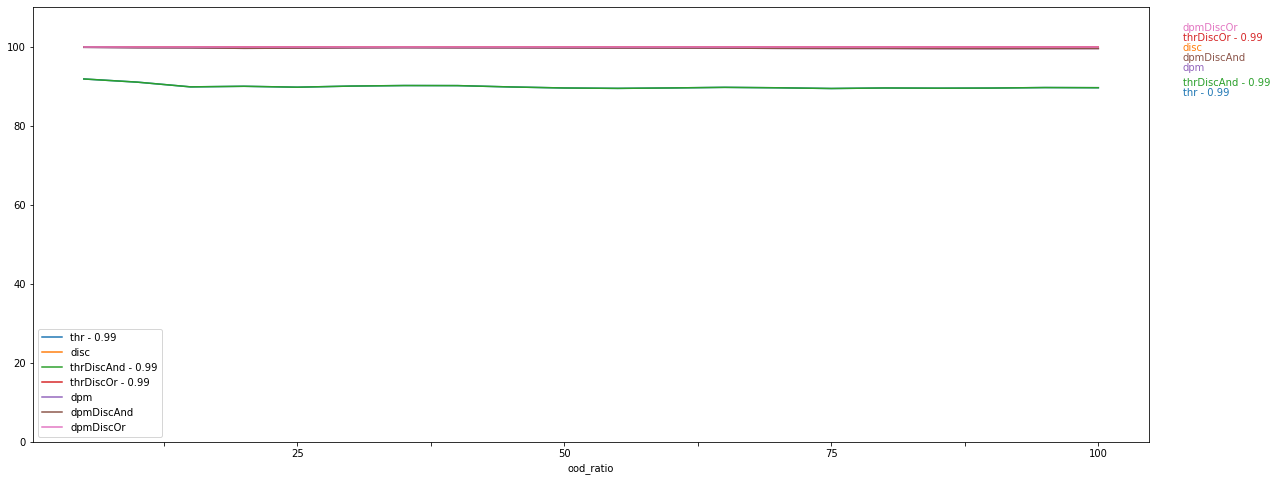

In [ ]:
ds_name = 'kmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp    mean   std
0         thr - 0.99   86.59  0.20
1               disc  100.00  0.00
2  thrDiscAnd - 0.99   86.59  0.20
3   thrDiscOr - 0.99  100.00  0.00
4                dpm   95.66  0.18
5         dpmDiscAnd   95.66  0.18
6          dpmDiscOr  100.00  0.00

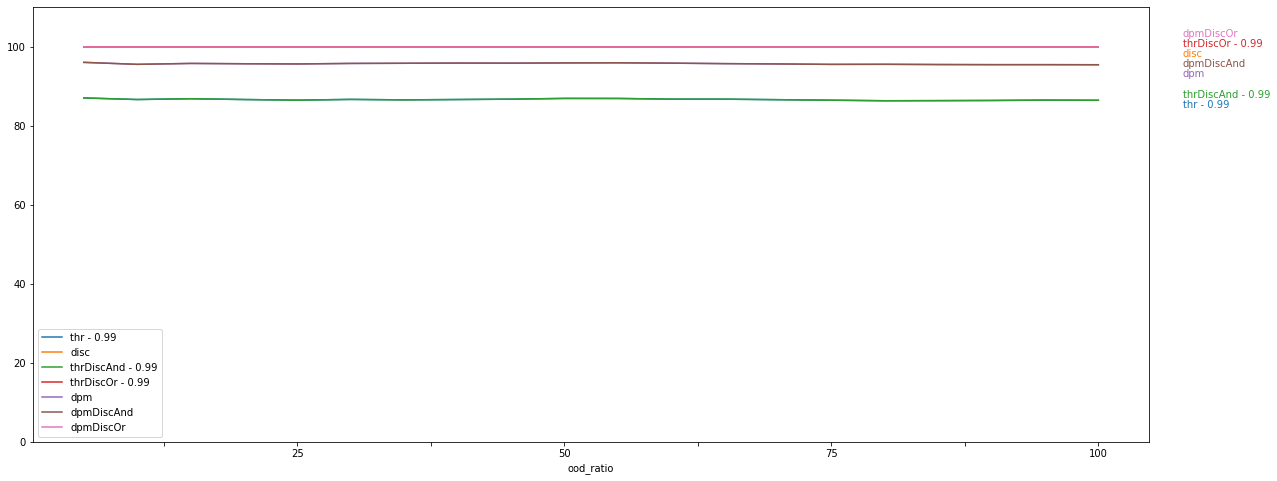

In [ ]:
ds_name = 'fmnist'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp    mean   std
0         thr - 0.99   22.32  0.84
1               disc  100.00  0.00
2  thrDiscAnd - 0.99   22.32  0.84
3   thrDiscOr - 0.99  100.00  0.00
4                dpm   63.88  1.06
5         dpmDiscAnd   63.88  1.06
6          dpmDiscOr  100.00  0.00

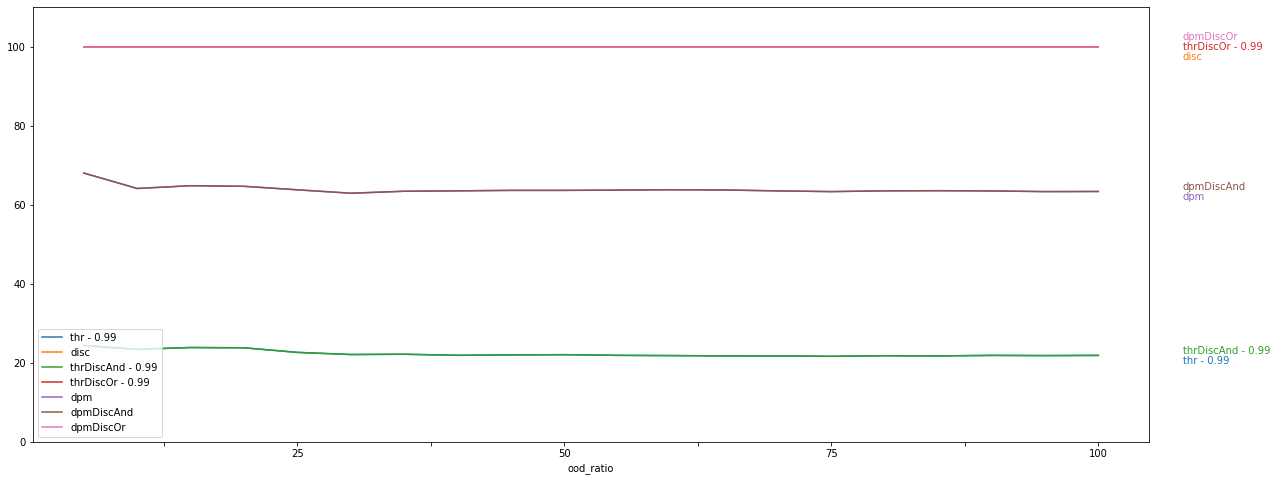

In [ ]:
ds_name = 'arabic'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

exp   mean  std
0         thr - 0.99  100.0  0.0
1               disc  100.0  0.0
2  thrDiscAnd - 0.99  100.0  0.0
3   thrDiscOr - 0.99  100.0  0.0
4                dpm  100.0  0.0
5         dpmDiscAnd  100.0  0.0
6          dpmDiscOr  100.0  0.0

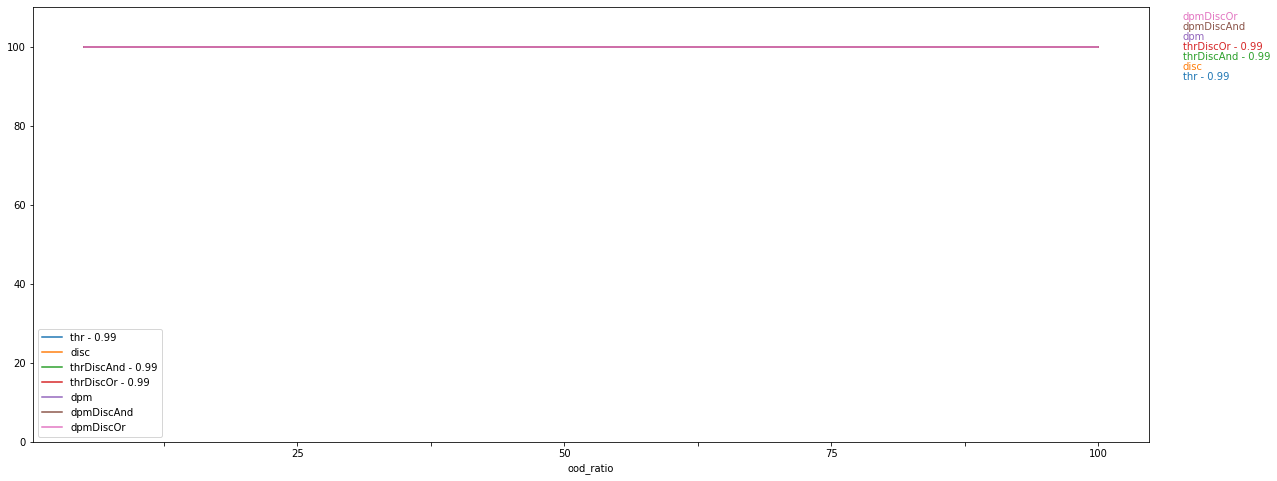

In [ ]:
ds_name = 'rnd'

plotVsRatio(exps=exps, results_df=results_df, ds_name=ds_name, y=y, thrs=target_thrs)

### Seperator


### Seperator
